# OU jump 12

In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
np.random.seed(12001)


# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  alpha = alpha
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  Lambda = matrix(c(lambda11, lambda12, lambda21, lambda22), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef

def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series1.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) 
    
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, 
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3])
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3']
    
    return stats_data



def loss_function(params):
    """n_real_stats is a global amount calculated outside the function"""
    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=alpha, 
        beta1=beta1, beta2=beta2, 
        delta0=delta0, 
        mu1=mu1, mu2=mu2, 
        lambda11=lambda11, lambda12=lambda12, 
        lambda21=lambda21, lambda22=lambda22,
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)


    moment_loss = (n_real_stats - n_sim_stats)**2
    mse = np.mean(moment_loss)
    
    mse[0] = mse[0]*10 # return_mean1
    mse[1] = mse[1]*10 # return_mean2
    mse[2] = mse[2]*10 # return_sd1
    mse[3] = mse[3]*10 # return_sd2
    mse[4] = mse[4]*10 # return_skew1
    mse[5] = mse[5]*10 # return_skew2    
    mse[6] = mse[6]/3 # return_kurtosis1
    mse[7] = mse[7]/5 # return_kurtosis2 
    
    mse[8] = mse[8]*1000 # return_autocorrelation_ts1_lag1
    mse[11] = mse[11]*1000 # return_autocorrelation_ts2_lag1
    
    mse[21] = mse[21]*1000 # return_autocorrelation_ts2_lag1
    mse[24] = mse[24]*1000 # return_autocorrelation_ts2_lag1
    
    sum_mse = np.sum(mse)

    print(mse)
    print(sum_mse)
    print('----------')

    return sum_mse



real_price = pd.read_csv("sp500_20180101_20181231_pair_prices.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv("sp500_20180101_20181231_pair_returns.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats


alpha = 2
beta1 = 0
beta2 = 0
delta0 = 0.55
mu1 = 0
mu2 = 0
lambda11 = 1
lambda12 = 0
lambda21 = 0
lambda22 = 1


initial0 = [1, 1, 1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1]  1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1

return_mean1                          9.547392
return_mean2                          8.652049
return_sd1                           28.396374
return_sd2                           27.264625
return_skew1                          8.848363
return_skew2                          8.848363
return_kurtosis1                     10.857155
return_kurtosis2                     10.276967
return_autocorrelation_ts1_lag1       8.361581
return_autocorrelation_ts1_lag2       0.009658
return_autocorrelation_ts1_lag3       0.007357
return_autocorrelation_ts2_lag1       7.439843
return_autocorrelation_ts2_lag2       0.009687
return_autocorrelation_ts2_lag3       0.008287
return_correlation_ts1_lag_0          0.430792
return_correlation_ts1_lag_1          0.007398
return_correlation_ts1_lag_2          0.008060
return_correlation_ts1_lag_3          0.008873
return_correlation_ts2_lag_1          0.009362
return_correlation_ts2_lag_2          0.0

return_mean1                          3.624417
return_mean2                          8.536131
return_sd1                           29.491623
return_sd2                           27.468081
return_skew1                          8.779115
return_skew2                          8.779115
return_kurtosis1                     10.896697
return_kurtosis2                     10.261227
return_autocorrelation_ts1_lag1       8.451683
return_autocorrelation_ts1_lag2       0.012486
return_autocorrelation_ts1_lag3       0.007518
return_autocorrelation_ts2_lag1       8.106059
return_autocorrelation_ts2_lag2       0.009900
return_autocorrelation_ts2_lag3       0.008125
return_correlation_ts1_lag_0          0.428623
return_correlation_ts1_lag_1          0.007826
return_correlation_ts1_lag_2          0.009598
return_correlation_ts1_lag_3          0.008277
return_correlation_ts2_lag_1          0.009075
return_correlation_ts2_lag_2          0.010361
return_correlation_ts2_lag_3          0.008572
sqreturn_auto

return_mean1                          3.528811
return_mean2                          8.323236
return_sd1                           29.257054
return_sd2                           27.430813
return_skew1                          9.865958
return_skew2                          9.865958
return_kurtosis1                     11.383723
return_kurtosis2                     10.423472
return_autocorrelation_ts1_lag1       9.983996
return_autocorrelation_ts1_lag2       0.011510
return_autocorrelation_ts1_lag3       0.006917
return_autocorrelation_ts2_lag1       9.105759
return_autocorrelation_ts2_lag2       0.008299
return_autocorrelation_ts2_lag3       0.008991
return_correlation_ts1_lag_0          0.428605
return_correlation_ts1_lag_1          0.007809
return_correlation_ts1_lag_2          0.008186
return_correlation_ts1_lag_3          0.008264
return_correlation_ts2_lag_1          0.009719
return_correlation_ts2_lag_2          0.009984
return_correlation_ts2_lag_3          0.008874
sqreturn_auto

return_mean1                         59.088109
return_mean2                          8.760343
return_sd1                           30.790921
return_sd2                           27.400622
return_skew1                          9.543153
return_skew2                          9.543153
return_kurtosis1                     11.216356
return_kurtosis2                     10.411582
return_autocorrelation_ts1_lag1      12.498415
return_autocorrelation_ts1_lag2       0.013077
return_autocorrelation_ts1_lag3       0.007332
return_autocorrelation_ts2_lag1       8.442153
return_autocorrelation_ts2_lag2       0.009034
return_autocorrelation_ts2_lag3       0.008818
return_correlation_ts1_lag_0          0.418164
return_correlation_ts1_lag_1          0.008179
return_correlation_ts1_lag_2          0.008023
return_correlation_ts1_lag_3          0.009111
return_correlation_ts2_lag_1          0.009977
return_correlation_ts2_lag_2          0.008664
return_correlation_ts2_lag_3          0.008003
sqreturn_auto

return_mean1                          1.587792
return_mean2                          8.451819
return_sd1                           28.447213
return_sd2                           26.932268
return_skew1                          9.368595
return_skew2                          9.368595
return_kurtosis1                     10.794392
return_kurtosis2                     10.157714
return_autocorrelation_ts1_lag1       9.273384
return_autocorrelation_ts1_lag2       0.011080
return_autocorrelation_ts1_lag3       0.007913
return_autocorrelation_ts2_lag1       8.179487
return_autocorrelation_ts2_lag2       0.009571
return_autocorrelation_ts2_lag3       0.009051
return_correlation_ts1_lag_0          0.430164
return_correlation_ts1_lag_1          0.007603
return_correlation_ts1_lag_2          0.008832
return_correlation_ts1_lag_3          0.009783
return_correlation_ts2_lag_1          0.008745
return_correlation_ts2_lag_2          0.009392
return_correlation_ts2_lag_3          0.008230
sqreturn_auto

return_mean1                          0.829878
return_mean2                          8.814201
return_sd1                           29.053819
return_sd2                           27.931175
return_skew1                          8.785213
return_skew2                          8.785213
return_kurtosis1                     10.839632
return_kurtosis2                     10.064149
return_autocorrelation_ts1_lag1       9.205565
return_autocorrelation_ts1_lag2       0.010150
return_autocorrelation_ts1_lag3       0.007351
return_autocorrelation_ts2_lag1       8.184044
return_autocorrelation_ts2_lag2       0.009868
return_autocorrelation_ts2_lag3       0.008845
return_correlation_ts1_lag_0          0.430609
return_correlation_ts1_lag_1          0.007365
return_correlation_ts1_lag_2          0.008134
return_correlation_ts1_lag_3          0.009114
return_correlation_ts2_lag_1          0.008846
return_correlation_ts2_lag_2          0.010622
return_correlation_ts2_lag_3          0.008915
sqreturn_auto

return_mean1                          0.788127
return_mean2                          8.374992
return_sd1                           28.784199
return_sd2                           27.542628
return_skew1                          9.894576
return_skew2                          9.894576
return_kurtosis1                     11.926572
return_kurtosis2                     10.672593
return_autocorrelation_ts1_lag1      10.103002
return_autocorrelation_ts1_lag2       0.009020
return_autocorrelation_ts1_lag3       0.008535
return_autocorrelation_ts2_lag1       8.947272
return_autocorrelation_ts2_lag2       0.008918
return_autocorrelation_ts2_lag3       0.009527
return_correlation_ts1_lag_0          0.430623
return_correlation_ts1_lag_1          0.007788
return_correlation_ts1_lag_2          0.008374
return_correlation_ts1_lag_3          0.008738
return_correlation_ts2_lag_1          0.009426
return_correlation_ts2_lag_2          0.009337
return_correlation_ts2_lag_3          0.009662
sqreturn_auto

return_mean1                          0.922276
return_mean2                          6.266128
return_sd1                           29.282512
return_sd2                           28.134265
return_skew1                          9.091226
return_skew2                          9.091226
return_kurtosis1                     10.774102
return_kurtosis2                     10.264053
return_autocorrelation_ts1_lag1       8.759285
return_autocorrelation_ts1_lag2       0.010089
return_autocorrelation_ts1_lag3       0.008011
return_autocorrelation_ts2_lag1       9.100287
return_autocorrelation_ts2_lag2       0.009086
return_autocorrelation_ts2_lag3       0.007484
return_correlation_ts1_lag_0          0.430859
return_correlation_ts1_lag_1          0.007485
return_correlation_ts1_lag_2          0.007990
return_correlation_ts1_lag_3          0.008053
return_correlation_ts2_lag_1          0.010222
return_correlation_ts2_lag_2          0.009163
return_correlation_ts2_lag_3          0.008668
sqreturn_auto

return_mean1                          0.762413
return_mean2                          4.186891
return_sd1                           28.995845
return_sd2                           28.428393
return_skew1                          9.184266
return_skew2                          9.184266
return_kurtosis1                     11.096839
return_kurtosis2                     10.307560
return_autocorrelation_ts1_lag1       8.820282
return_autocorrelation_ts1_lag2       0.010397
return_autocorrelation_ts1_lag3       0.006934
return_autocorrelation_ts2_lag1       9.743609
return_autocorrelation_ts2_lag2       0.008819
return_autocorrelation_ts2_lag3       0.008412
return_correlation_ts1_lag_0          0.430490
return_correlation_ts1_lag_1          0.008227
return_correlation_ts1_lag_2          0.007967
return_correlation_ts1_lag_3          0.007168
return_correlation_ts2_lag_1          0.009866
return_correlation_ts2_lag_2          0.010284
return_correlation_ts2_lag_3          0.007576
sqreturn_auto

return_mean1                          0.806212
return_mean2                          4.356914
return_sd1                           29.098193
return_sd2                           28.371733
return_skew1                          8.894698
return_skew2                          8.894698
return_kurtosis1                     10.839043
return_kurtosis2                     10.188506
return_autocorrelation_ts1_lag1       9.421980
return_autocorrelation_ts1_lag2       0.010015
return_autocorrelation_ts1_lag3       0.007128
return_autocorrelation_ts2_lag1       8.513793
return_autocorrelation_ts2_lag2       0.009642
return_autocorrelation_ts2_lag3       0.008981
return_correlation_ts1_lag_0          0.430503
return_correlation_ts1_lag_1          0.008054
return_correlation_ts1_lag_2          0.008775
return_correlation_ts1_lag_3          0.008513
return_correlation_ts2_lag_1          0.009732
return_correlation_ts2_lag_2          0.008980
return_correlation_ts2_lag_3          0.008379
sqreturn_auto

return_mean1                          0.680774
return_mean2                          4.048228
return_sd1                           28.859071
return_sd2                           28.242289
return_skew1                          9.109920
return_skew2                          9.109920
return_kurtosis1                     10.800427
return_kurtosis2                     10.216272
return_autocorrelation_ts1_lag1       7.667537
return_autocorrelation_ts1_lag2       0.009689
return_autocorrelation_ts1_lag3       0.008596
return_autocorrelation_ts2_lag1       8.268949
return_autocorrelation_ts2_lag2       0.009545
return_autocorrelation_ts2_lag3       0.008922
return_correlation_ts1_lag_0          0.430540
return_correlation_ts1_lag_1          0.006831
return_correlation_ts1_lag_2          0.008427
return_correlation_ts1_lag_3          0.009099
return_correlation_ts2_lag_1          0.007780
return_correlation_ts2_lag_2          0.009418
return_correlation_ts2_lag_3          0.008875
sqreturn_auto

return_mean1                          0.849449
return_mean2                          0.557968
return_sd1                           28.702068
return_sd2                           27.144311
return_skew1                          8.473725
return_skew2                          8.473725
return_kurtosis1                     10.779951
return_kurtosis2                     10.244431
return_autocorrelation_ts1_lag1       9.491807
return_autocorrelation_ts1_lag2       0.010132
return_autocorrelation_ts1_lag3       0.007523
return_autocorrelation_ts2_lag1       9.141943
return_autocorrelation_ts2_lag2       0.009032
return_autocorrelation_ts2_lag3       0.009175
return_correlation_ts1_lag_0          0.430658
return_correlation_ts1_lag_1          0.007235
return_correlation_ts1_lag_2          0.008864
return_correlation_ts1_lag_3          0.010071
return_correlation_ts2_lag_1          0.009780
return_correlation_ts2_lag_2          0.010145
return_correlation_ts2_lag_3          0.008715
sqreturn_auto

return_mean1                          0.734115
return_mean2                          0.876480
return_sd1                           28.488380
return_sd2                           27.329010
return_skew1                          9.128305
return_skew2                          9.128305
return_kurtosis1                     11.012156
return_kurtosis2                     10.214824
return_autocorrelation_ts1_lag1       8.928114
return_autocorrelation_ts1_lag2       0.009578
return_autocorrelation_ts1_lag3       0.007235
return_autocorrelation_ts2_lag1       7.710007
return_autocorrelation_ts2_lag2       0.009153
return_autocorrelation_ts2_lag3       0.008798
return_correlation_ts1_lag_0          0.430862
return_correlation_ts1_lag_1          0.006989
return_correlation_ts1_lag_2          0.008676
return_correlation_ts1_lag_3          0.009311
return_correlation_ts2_lag_1          0.009236
return_correlation_ts2_lag_2          0.009074
return_correlation_ts2_lag_3          0.008221
sqreturn_auto

return_mean1                          0.719723
return_mean2                          0.870732
return_sd1                           28.651423
return_sd2                           27.193609
return_skew1                          9.372012
return_skew2                          9.372012
return_kurtosis1                     10.747769
return_kurtosis2                     10.251427
return_autocorrelation_ts1_lag1       8.992599
return_autocorrelation_ts1_lag2       0.010143
return_autocorrelation_ts1_lag3       0.006983
return_autocorrelation_ts2_lag1       8.123715
return_autocorrelation_ts2_lag2       0.009991
return_autocorrelation_ts2_lag3       0.008120
return_correlation_ts1_lag_0          0.430858
return_correlation_ts1_lag_1          0.006605
return_correlation_ts1_lag_2          0.009544
return_correlation_ts1_lag_3          0.008116
return_correlation_ts2_lag_1          0.008399
return_correlation_ts2_lag_2          0.009499
return_correlation_ts2_lag_3          0.008428
sqreturn_auto

return_mean1                          0.708257
return_mean2                          0.953182
return_sd1                            9.898521
return_sd2                           27.463962
return_skew1                         10.828169
return_skew2                         10.828169
return_kurtosis1                     13.698623
return_kurtosis2                     10.068364
return_autocorrelation_ts1_lag1       9.124473
return_autocorrelation_ts1_lag2       0.013215
return_autocorrelation_ts1_lag3       0.009520
return_autocorrelation_ts2_lag1       7.721785
return_autocorrelation_ts2_lag2       0.010092
return_autocorrelation_ts2_lag3       0.009041
return_correlation_ts1_lag_0          0.338540
return_correlation_ts1_lag_1          0.006790
return_correlation_ts1_lag_2          0.009465
return_correlation_ts1_lag_3          0.009899
return_correlation_ts2_lag_1          0.008420
return_correlation_ts2_lag_2          0.010763
return_correlation_ts2_lag_3          0.008908
sqreturn_auto

return_mean1                          0.622439
return_mean2                          0.874837
return_sd1                            7.607910
return_sd2                           27.097163
return_skew1                          9.368319
return_skew2                          9.368319
return_kurtosis1                     10.874726
return_kurtosis2                     10.207184
return_autocorrelation_ts1_lag1       9.821585
return_autocorrelation_ts1_lag2       0.011557
return_autocorrelation_ts1_lag3       0.008502
return_autocorrelation_ts2_lag1       8.156096
return_autocorrelation_ts2_lag2       0.008811
return_autocorrelation_ts2_lag3       0.008904
return_correlation_ts1_lag_0          0.250077
return_correlation_ts1_lag_1          0.007636
return_correlation_ts1_lag_2          0.007475
return_correlation_ts1_lag_3          0.009521
return_correlation_ts2_lag_1          0.008451
return_correlation_ts2_lag_2          0.010070
return_correlation_ts2_lag_3          0.008191
sqreturn_auto

return_mean1                          0.625282
return_mean2                          0.866947
return_sd1                            7.541792
return_sd2                           27.066374
return_skew1                          9.666445
return_skew2                          9.666445
return_kurtosis1                     11.253302
return_kurtosis2                     10.207834
return_autocorrelation_ts1_lag1       9.366028
return_autocorrelation_ts1_lag2       0.011244
return_autocorrelation_ts1_lag3       0.007825
return_autocorrelation_ts2_lag1       8.179488
return_autocorrelation_ts2_lag2       0.009518
return_autocorrelation_ts2_lag3       0.009038
return_correlation_ts1_lag_0          0.249770
return_correlation_ts1_lag_1          0.008436
return_correlation_ts1_lag_2          0.008330
return_correlation_ts1_lag_3          0.008788
return_correlation_ts2_lag_1          0.009907
return_correlation_ts2_lag_2          0.009792
return_correlation_ts2_lag_3          0.008084
sqreturn_auto

return_mean1                          0.631290
return_mean2                          0.842259
return_sd1                            7.583456
return_sd2                           26.965710
return_skew1                          8.856058
return_skew2                          8.856058
return_kurtosis1                     10.823223
return_kurtosis2                     10.237809
return_autocorrelation_ts1_lag1      10.603290
return_autocorrelation_ts1_lag2       0.010758
return_autocorrelation_ts1_lag3       0.008916
return_autocorrelation_ts2_lag1       8.090797
return_autocorrelation_ts2_lag2       0.009210
return_autocorrelation_ts2_lag3       0.008316
return_correlation_ts1_lag_0          0.250652
return_correlation_ts1_lag_1          0.007782
return_correlation_ts1_lag_2          0.009470
return_correlation_ts1_lag_3          0.008036
return_correlation_ts2_lag_1          0.009203
return_correlation_ts2_lag_2          0.008503
return_correlation_ts2_lag_3          0.008568
sqreturn_auto

return_mean1                          0.724478
return_mean2                          0.814273
return_sd1                           33.567807
return_sd2                           27.187337
return_skew1                          9.345550
return_skew2                          9.345550
return_kurtosis1                     10.999748
return_kurtosis2                     10.287498
return_autocorrelation_ts1_lag1       7.704078
return_autocorrelation_ts1_lag2       0.009949
return_autocorrelation_ts1_lag3       0.009153
return_autocorrelation_ts2_lag1       9.242012
return_autocorrelation_ts2_lag2       0.009478
return_autocorrelation_ts2_lag3       0.008036
return_correlation_ts1_lag_0          0.218832
return_correlation_ts1_lag_1          0.008817
return_correlation_ts1_lag_2          0.007750
return_correlation_ts1_lag_3          0.007625
return_correlation_ts2_lag_1          0.008617
return_correlation_ts2_lag_2          0.009326
return_correlation_ts2_lag_3          0.009137
sqreturn_auto

return_mean1                          0.685553
return_mean2                          1.002914
return_sd1                            8.309617
return_sd2                           27.431415
return_skew1                          9.519471
return_skew2                          9.519471
return_kurtosis1                     10.729399
return_kurtosis2                     10.274861
return_autocorrelation_ts1_lag1      10.658901
return_autocorrelation_ts1_lag2       0.011786
return_autocorrelation_ts1_lag3       0.007245
return_autocorrelation_ts2_lag1       7.956576
return_autocorrelation_ts2_lag2       0.009857
return_autocorrelation_ts2_lag3       0.007523
return_correlation_ts1_lag_0          0.250813
return_correlation_ts1_lag_1          0.007921
return_correlation_ts1_lag_2          0.008678
return_correlation_ts1_lag_3          0.008968
return_correlation_ts2_lag_1          0.009742
return_correlation_ts2_lag_2          0.008711
return_correlation_ts2_lag_3          0.008775
sqreturn_auto

return_mean1                          0.637982
return_mean2                          0.868749
return_sd1                            7.818920
return_sd2                           27.487680
return_skew1                          8.966997
return_skew2                          8.966997
return_kurtosis1                     10.869563
return_kurtosis2                     10.212086
return_autocorrelation_ts1_lag1       8.939007
return_autocorrelation_ts1_lag2       0.012869
return_autocorrelation_ts1_lag3       0.007631
return_autocorrelation_ts2_lag1       8.459265
return_autocorrelation_ts2_lag2       0.009450
return_autocorrelation_ts2_lag3       0.008217
return_correlation_ts1_lag_0          0.252700
return_correlation_ts1_lag_1          0.007877
return_correlation_ts1_lag_2          0.009943
return_correlation_ts1_lag_3          0.008130
return_correlation_ts2_lag_1          0.009975
return_correlation_ts2_lag_2          0.008920
return_correlation_ts2_lag_3          0.007805
sqreturn_auto

return_mean1                          0.627613
return_mean2                          0.893463
return_sd1                            7.506735
return_sd2                           26.731039
return_skew1                          8.597686
return_skew2                          8.597686
return_kurtosis1                      9.911816
return_kurtosis2                      9.946431
return_autocorrelation_ts1_lag1      10.298198
return_autocorrelation_ts1_lag2       0.012306
return_autocorrelation_ts1_lag3       0.007533
return_autocorrelation_ts2_lag1       8.922923
return_autocorrelation_ts2_lag2       0.010588
return_autocorrelation_ts2_lag3       0.009327
return_correlation_ts1_lag_0          0.250178
return_correlation_ts1_lag_1          0.008419
return_correlation_ts1_lag_2          0.009000
return_correlation_ts1_lag_3          0.008071
return_correlation_ts2_lag_1          0.009491
return_correlation_ts2_lag_2          0.010801
return_correlation_ts2_lag_3          0.008874
sqreturn_auto

return_mean1                          0.631605
return_mean2                          0.899050
return_sd1                            7.577403
return_sd2                           27.406236
return_skew1                          8.932033
return_skew2                          8.932033
return_kurtosis1                     10.826889
return_kurtosis2                     10.185030
return_autocorrelation_ts1_lag1       9.469763
return_autocorrelation_ts1_lag2       0.011048
return_autocorrelation_ts1_lag3       0.007248
return_autocorrelation_ts2_lag1       8.905003
return_autocorrelation_ts2_lag2       0.009677
return_autocorrelation_ts2_lag3       0.008085
return_correlation_ts1_lag_0          0.251384
return_correlation_ts1_lag_1          0.007402
return_correlation_ts1_lag_2          0.008038
return_correlation_ts1_lag_3          0.007661
return_correlation_ts2_lag_1          0.010226
return_correlation_ts2_lag_2          0.009950
return_correlation_ts2_lag_3          0.007851
sqreturn_auto

return_mean1                          0.758539
return_mean2                          0.960056
return_sd1                            7.719130
return_sd2                           27.466731
return_skew1                         10.160987
return_skew2                         10.160987
return_kurtosis1                     12.373783
return_kurtosis2                     10.319953
return_autocorrelation_ts1_lag1      10.096453
return_autocorrelation_ts1_lag2       0.012530
return_autocorrelation_ts1_lag3       0.007581
return_autocorrelation_ts2_lag1       7.517371
return_autocorrelation_ts2_lag2       0.008827
return_autocorrelation_ts2_lag3       0.008302
return_correlation_ts1_lag_0          0.252568
return_correlation_ts1_lag_1          0.007898
return_correlation_ts1_lag_2          0.009235
return_correlation_ts1_lag_3          0.008895
return_correlation_ts2_lag_1          0.008860
return_correlation_ts2_lag_2          0.009771
return_correlation_ts2_lag_3          0.008411
sqreturn_auto

return_mean1                          0.538687
return_mean2                          0.688153
return_sd1                            7.689460
return_sd2                            7.279148
return_skew1                          9.208854
return_skew2                          9.208854
return_kurtosis1                      9.921060
return_kurtosis2                     10.150268
return_autocorrelation_ts1_lag1       8.372995
return_autocorrelation_ts1_lag2       0.010275
return_autocorrelation_ts1_lag3       0.008388
return_autocorrelation_ts2_lag1       8.102545
return_autocorrelation_ts2_lag2       0.009920
return_autocorrelation_ts2_lag3       0.009596
return_correlation_ts1_lag_0          0.430602
return_correlation_ts1_lag_1          0.006916
return_correlation_ts1_lag_2          0.008723
return_correlation_ts1_lag_3          0.009735
return_correlation_ts2_lag_1          0.008345
return_correlation_ts2_lag_2          0.008764
return_correlation_ts2_lag_3          0.010473
sqreturn_auto

return_mean1                          0.666874
return_mean2                          0.760843
return_sd1                            7.748833
return_sd2                            7.400295
return_skew1                          9.724435
return_skew2                          9.724435
return_kurtosis1                     11.432419
return_kurtosis2                     10.277332
return_autocorrelation_ts1_lag1       9.374065
return_autocorrelation_ts1_lag2       0.011293
return_autocorrelation_ts1_lag3       0.007640
return_autocorrelation_ts2_lag1       8.789975
return_autocorrelation_ts2_lag2       0.009813
return_autocorrelation_ts2_lag3       0.006854
return_correlation_ts1_lag_0          0.430544
return_correlation_ts1_lag_1          0.006979
return_correlation_ts1_lag_2          0.008673
return_correlation_ts1_lag_3          0.009074
return_correlation_ts2_lag_1          0.009872
return_correlation_ts2_lag_2          0.010653
return_correlation_ts2_lag_3          0.008837
sqreturn_auto

return_mean1                          0.696475
return_mean2                          0.826962
return_sd1                            7.518633
return_sd2                            7.191133
return_skew1                          9.561571
return_skew2                          9.561571
return_kurtosis1                     10.677522
return_kurtosis2                      9.768813
return_autocorrelation_ts1_lag1       9.070489
return_autocorrelation_ts1_lag2       0.011922
return_autocorrelation_ts1_lag3       0.009076
return_autocorrelation_ts2_lag1       7.968570
return_autocorrelation_ts2_lag2       0.009488
return_autocorrelation_ts2_lag3       0.009340
return_correlation_ts1_lag_0          0.430601
return_correlation_ts1_lag_1          0.007131
return_correlation_ts1_lag_2          0.008404
return_correlation_ts1_lag_3          0.009432
return_correlation_ts2_lag_1          0.008909
return_correlation_ts2_lag_2          0.010565
return_correlation_ts2_lag_3          0.009620
sqreturn_auto

return_mean1                          0.638736
return_mean2                          0.780287
return_sd1                            7.867781
return_sd2                            7.364406
return_skew1                          9.094956
return_skew2                          9.094956
return_kurtosis1                     11.150307
return_kurtosis2                     10.195516
return_autocorrelation_ts1_lag1       9.672406
return_autocorrelation_ts1_lag2       0.010998
return_autocorrelation_ts1_lag3       0.008124
return_autocorrelation_ts2_lag1       8.544032
return_autocorrelation_ts2_lag2       0.009980
return_autocorrelation_ts2_lag3       0.008264
return_correlation_ts1_lag_0          0.430611
return_correlation_ts1_lag_1          0.007468
return_correlation_ts1_lag_2          0.009202
return_correlation_ts1_lag_3          0.009435
return_correlation_ts2_lag_1          0.008816
return_correlation_ts2_lag_2          0.010762
return_correlation_ts2_lag_3          0.008850
sqreturn_auto

return_mean1                          0.581061
return_mean2                          0.674474
return_sd1                            7.807528
return_sd2                            4.202145
return_skew1                          9.433789
return_skew2                          9.433789
return_kurtosis1                     10.306996
return_kurtosis2                     11.395268
return_autocorrelation_ts1_lag1       8.988328
return_autocorrelation_ts1_lag2       0.010771
return_autocorrelation_ts1_lag3       0.007402
return_autocorrelation_ts2_lag1      12.215743
return_autocorrelation_ts2_lag2       0.014393
return_autocorrelation_ts2_lag3       0.010180
return_correlation_ts1_lag_0          0.404589
return_correlation_ts1_lag_1          0.008500
return_correlation_ts1_lag_2          0.009661
return_correlation_ts1_lag_3          0.008590
return_correlation_ts2_lag_1          0.009876
return_correlation_ts2_lag_2          0.012098
return_correlation_ts2_lag_3          0.008596
sqreturn_auto

return_mean1                          0.684390
return_mean2                          0.746194
return_sd1                            7.698452
return_sd2                            3.046767
return_skew1                          9.463629
return_skew2                          9.463629
return_kurtosis1                     11.080154
return_kurtosis2                     11.177252
return_autocorrelation_ts1_lag1      10.093662
return_autocorrelation_ts1_lag2       0.010948
return_autocorrelation_ts1_lag3       0.007817
return_autocorrelation_ts2_lag1      11.249355
return_autocorrelation_ts2_lag2       0.011942
return_autocorrelation_ts2_lag3       0.009399
return_correlation_ts1_lag_0          0.424898
return_correlation_ts1_lag_1          0.008816
return_correlation_ts1_lag_2          0.009323
return_correlation_ts1_lag_3          0.009191
return_correlation_ts2_lag_1          0.010047
return_correlation_ts2_lag_2          0.011106
return_correlation_ts2_lag_3          0.008851
sqreturn_auto

return_mean1                          0.707480
return_mean2                          0.748053
return_sd1                            7.872522
return_sd2                            3.109321
return_skew1                         11.291427
return_skew2                         11.291427
return_kurtosis1                     15.446511
return_kurtosis2                     14.295572
return_autocorrelation_ts1_lag1       9.299294
return_autocorrelation_ts1_lag2       0.010063
return_autocorrelation_ts1_lag3       0.007533
return_autocorrelation_ts2_lag1       9.695623
return_autocorrelation_ts2_lag2       0.009723
return_autocorrelation_ts2_lag3       0.008832
return_correlation_ts1_lag_0          0.425613
return_correlation_ts1_lag_1          0.007527
return_correlation_ts1_lag_2          0.008680
return_correlation_ts1_lag_3          0.009117
return_correlation_ts2_lag_1          0.008844
return_correlation_ts2_lag_2          0.010243
return_correlation_ts2_lag_3          0.008830
sqreturn_auto

return_mean1                           0.742408
return_mean2                           0.791489
return_sd1                            18.643195
return_sd2                             3.068512
return_skew1                          53.581113
return_skew2                          53.581113
return_kurtosis1                     125.952745
return_kurtosis2                      10.235778
return_autocorrelation_ts1_lag1        9.585438
return_autocorrelation_ts1_lag2        0.010588
return_autocorrelation_ts1_lag3        0.008507
return_autocorrelation_ts2_lag1       10.308900
return_autocorrelation_ts2_lag2        0.012346
return_autocorrelation_ts2_lag3        0.010311
return_correlation_ts1_lag_0           0.357950
return_correlation_ts1_lag_1           0.008576
return_correlation_ts1_lag_2           0.009373
return_correlation_ts1_lag_3           0.008964
return_correlation_ts2_lag_1           0.009170
return_correlation_ts2_lag_2           0.010406
return_correlation_ts2_lag_3           0

return_mean1                          0.617614
return_mean2                          0.653776
return_sd1                            7.518635
return_sd2                            3.170455
return_skew1                          9.417876
return_skew2                          9.417876
return_kurtosis1                     11.295657
return_kurtosis2                     11.811265
return_autocorrelation_ts1_lag1       9.944188
return_autocorrelation_ts1_lag2       0.011929
return_autocorrelation_ts1_lag3       0.008162
return_autocorrelation_ts2_lag1      10.667049
return_autocorrelation_ts2_lag2       0.011994
return_autocorrelation_ts2_lag3       0.008678
return_correlation_ts1_lag_0          0.394702
return_correlation_ts1_lag_1          0.007592
return_correlation_ts1_lag_2          0.011264
return_correlation_ts1_lag_3          0.008843
return_correlation_ts2_lag_1          0.010947
return_correlation_ts2_lag_2          0.011721
return_correlation_ts2_lag_3          0.009066
sqreturn_auto

return_mean1                          0.535913
return_mean2                          0.661362
return_sd1                            7.480998
return_sd2                            3.027450
return_skew1                          9.199176
return_skew2                          9.199176
return_kurtosis1                     11.060047
return_kurtosis2                     12.371500
return_autocorrelation_ts1_lag1       9.522865
return_autocorrelation_ts1_lag2       0.012337
return_autocorrelation_ts1_lag3       0.008724
return_autocorrelation_ts2_lag1      10.109761
return_autocorrelation_ts2_lag2       0.011468
return_autocorrelation_ts2_lag3       0.008824
return_correlation_ts1_lag_0          0.392363
return_correlation_ts1_lag_1          0.008474
return_correlation_ts1_lag_2          0.009714
return_correlation_ts1_lag_3          0.009028
return_correlation_ts2_lag_1          0.010324
return_correlation_ts2_lag_2          0.011969
return_correlation_ts2_lag_3          0.008870
sqreturn_auto

return_mean1                           0.660770
return_mean2                           0.695881
return_sd1                            19.456173
return_sd2                             3.104056
return_skew1                          64.816864
return_skew2                          64.816864
return_kurtosis1                     134.692046
return_kurtosis2                      11.579679
return_autocorrelation_ts1_lag1        8.956434
return_autocorrelation_ts1_lag2        0.011799
return_autocorrelation_ts1_lag3        0.007742
return_autocorrelation_ts2_lag1        8.916975
return_autocorrelation_ts2_lag2        0.012738
return_autocorrelation_ts2_lag3        0.007926
return_correlation_ts1_lag_0           0.206119
return_correlation_ts1_lag_1           0.007500
return_correlation_ts1_lag_2           0.010236
return_correlation_ts1_lag_3           0.007995
return_correlation_ts2_lag_1           0.009469
return_correlation_ts2_lag_2           0.011298
return_correlation_ts2_lag_3           0

return_mean1                          0.658949
return_mean2                          0.673764
return_sd1                            7.185396
return_sd2                            2.982478
return_skew1                          8.604108
return_skew2                          8.604108
return_kurtosis1                     10.916654
return_kurtosis2                     10.682233
return_autocorrelation_ts1_lag1       9.982122
return_autocorrelation_ts1_lag2       0.011934
return_autocorrelation_ts1_lag3       0.007898
return_autocorrelation_ts2_lag1      10.025704
return_autocorrelation_ts2_lag2       0.012737
return_autocorrelation_ts2_lag3       0.009324
return_correlation_ts1_lag_0          0.385592
return_correlation_ts1_lag_1          0.008785
return_correlation_ts1_lag_2          0.010409
return_correlation_ts1_lag_3          0.009995
return_correlation_ts2_lag_1          0.009055
return_correlation_ts2_lag_2          0.011869
return_correlation_ts2_lag_3          0.009700
sqreturn_auto

return_mean1                          0.631598
return_mean2                          0.701860
return_sd1                            7.170034
return_sd2                            3.045462
return_skew1                          8.690515
return_skew2                          8.690515
return_kurtosis1                     10.597622
return_kurtosis2                     10.982826
return_autocorrelation_ts1_lag1       9.127722
return_autocorrelation_ts1_lag2       0.011892
return_autocorrelation_ts1_lag3       0.007009
return_autocorrelation_ts2_lag1       9.824126
return_autocorrelation_ts2_lag2       0.011848
return_autocorrelation_ts2_lag3       0.009695
return_correlation_ts1_lag_0          0.375189
return_correlation_ts1_lag_1          0.007884
return_correlation_ts1_lag_2          0.010884
return_correlation_ts1_lag_3          0.009447
return_correlation_ts2_lag_1          0.009480
return_correlation_ts2_lag_2          0.010228
return_correlation_ts2_lag_3          0.008628
sqreturn_auto

return_mean1                          0.620139
return_mean2                          0.661714
return_sd1                            7.205889
return_sd2                            3.079790
return_skew1                          9.118867
return_skew2                          9.118867
return_kurtosis1                     10.894698
return_kurtosis2                     10.895583
return_autocorrelation_ts1_lag1      10.689775
return_autocorrelation_ts1_lag2       0.012491
return_autocorrelation_ts1_lag3       0.007942
return_autocorrelation_ts2_lag1      10.709992
return_autocorrelation_ts2_lag2       0.012210
return_autocorrelation_ts2_lag3       0.009266
return_correlation_ts1_lag_0          0.387564
return_correlation_ts1_lag_1          0.008808
return_correlation_ts1_lag_2          0.009631
return_correlation_ts1_lag_3          0.010385
return_correlation_ts2_lag_1          0.009458
return_correlation_ts2_lag_2          0.012559
return_correlation_ts2_lag_3          0.008745
sqreturn_auto

return_mean1                           0.626252
return_mean2                           0.820316
return_sd1                             7.399156
return_sd2                            11.579425
return_skew1                           8.696536
return_skew2                           8.696536
return_kurtosis1                      10.924504
return_kurtosis2                     116.562238
return_autocorrelation_ts1_lag1       11.430240
return_autocorrelation_ts1_lag2        0.011819
return_autocorrelation_ts1_lag3        0.008274
return_autocorrelation_ts2_lag1        9.064929
return_autocorrelation_ts2_lag2        0.009331
return_autocorrelation_ts2_lag3        0.008389
return_correlation_ts1_lag_0           0.249995
return_correlation_ts1_lag_1           0.008890
return_correlation_ts1_lag_2           0.008483
return_correlation_ts1_lag_3           0.009926
return_correlation_ts2_lag_1           0.009289
return_correlation_ts2_lag_2           0.011151
return_correlation_ts2_lag_3           0

return_mean1                          0.607336
return_mean2                          0.665579
return_sd1                            7.256236
return_sd2                            2.909102
return_skew1                          8.829384
return_skew2                          8.829384
return_kurtosis1                     10.940092
return_kurtosis2                     10.605392
return_autocorrelation_ts1_lag1       9.193645
return_autocorrelation_ts1_lag2       0.011395
return_autocorrelation_ts1_lag3       0.007048
return_autocorrelation_ts2_lag1       9.552809
return_autocorrelation_ts2_lag2       0.011085
return_autocorrelation_ts2_lag3       0.008748
return_correlation_ts1_lag_0          0.403415
return_correlation_ts1_lag_1          0.008215
return_correlation_ts1_lag_2          0.009885
return_correlation_ts1_lag_3          0.008296
return_correlation_ts2_lag_1          0.009688
return_correlation_ts2_lag_2          0.010682
return_correlation_ts2_lag_3          0.007868
sqreturn_auto

return_mean1                          0.606840
return_mean2                          0.657267
return_sd1                            7.325705
return_sd2                            3.104170
return_skew1                          9.257878
return_skew2                          9.257878
return_kurtosis1                     10.845937
return_kurtosis2                     10.442999
return_autocorrelation_ts1_lag1      10.506141
return_autocorrelation_ts1_lag2       0.014116
return_autocorrelation_ts1_lag3       0.007596
return_autocorrelation_ts2_lag1       9.375835
return_autocorrelation_ts2_lag2       0.012774
return_autocorrelation_ts2_lag3       0.007655
return_correlation_ts1_lag_0          0.407657
return_correlation_ts1_lag_1          0.008597
return_correlation_ts1_lag_2          0.011172
return_correlation_ts1_lag_3          0.009358
return_correlation_ts2_lag_1          0.009114
return_correlation_ts2_lag_2          0.013225
return_correlation_ts2_lag_3          0.008492
sqreturn_auto

return_mean1                          0.629894
return_mean2                          0.672387
return_sd1                            7.310519
return_sd2                            3.206464
return_skew1                          8.988174
return_skew2                          8.988174
return_kurtosis1                     10.978272
return_kurtosis2                     10.205690
return_autocorrelation_ts1_lag1       9.443244
return_autocorrelation_ts1_lag2       0.011641
return_autocorrelation_ts1_lag3       0.007378
return_autocorrelation_ts2_lag1      10.594913
return_autocorrelation_ts2_lag2       0.011507
return_autocorrelation_ts2_lag3       0.009222
return_correlation_ts1_lag_0          0.404561
return_correlation_ts1_lag_1          0.007961
return_correlation_ts1_lag_2          0.009830
return_correlation_ts1_lag_3          0.009144
return_correlation_ts2_lag_1          0.008952
return_correlation_ts2_lag_2          0.010880
return_correlation_ts2_lag_3          0.009435
sqreturn_auto

return_mean1                           0.548185
return_mean2                           1.117353
return_sd1                             7.271123
return_sd2                           142.879201
return_skew1                           9.155297
return_skew2                           9.155297
return_kurtosis1                      10.917023
return_kurtosis2                     401.527702
return_autocorrelation_ts1_lag1        9.907825
return_autocorrelation_ts1_lag2        0.011622
return_autocorrelation_ts1_lag3        0.007050
return_autocorrelation_ts2_lag1        7.864805
return_autocorrelation_ts2_lag2        0.007489
return_autocorrelation_ts2_lag3        0.007307
return_correlation_ts1_lag_0           0.061500
return_correlation_ts1_lag_1           0.007194
return_correlation_ts1_lag_2           0.008746
return_correlation_ts1_lag_3           0.008568
return_correlation_ts2_lag_1           0.009570
return_correlation_ts2_lag_2           0.010134
return_correlation_ts2_lag_3           0

return_mean1                          0.661008
return_mean2                          0.725200
return_sd1                            7.107726
return_sd2                            2.964939
return_skew1                          9.222016
return_skew2                          9.222016
return_kurtosis1                     11.006261
return_kurtosis2                     10.268390
return_autocorrelation_ts1_lag1       8.958951
return_autocorrelation_ts1_lag2       0.010382
return_autocorrelation_ts1_lag3       0.007426
return_autocorrelation_ts2_lag1       9.492536
return_autocorrelation_ts2_lag2       0.011215
return_autocorrelation_ts2_lag3       0.009901
return_correlation_ts1_lag_0          0.402023
return_correlation_ts1_lag_1          0.008093
return_correlation_ts1_lag_2          0.008629
return_correlation_ts1_lag_3          0.009544
return_correlation_ts2_lag_1          0.008751
return_correlation_ts2_lag_2          0.010963
return_correlation_ts2_lag_3          0.009829
sqreturn_auto

return_mean1                          0.582767
return_mean2                          0.626497
return_sd1                            7.293704
return_sd2                            3.072882
return_skew1                          9.128092
return_skew2                          9.128092
return_kurtosis1                     10.844662
return_kurtosis2                     10.236651
return_autocorrelation_ts1_lag1       9.229875
return_autocorrelation_ts1_lag2       0.011363
return_autocorrelation_ts1_lag3       0.008196
return_autocorrelation_ts2_lag1       9.989534
return_autocorrelation_ts2_lag2       0.011319
return_autocorrelation_ts2_lag3       0.008788
return_correlation_ts1_lag_0          0.414453
return_correlation_ts1_lag_1          0.008119
return_correlation_ts1_lag_2          0.009868
return_correlation_ts1_lag_3          0.009327
return_correlation_ts2_lag_1          0.008739
return_correlation_ts2_lag_2          0.010482
return_correlation_ts2_lag_3          0.009248
sqreturn_auto

return_mean1                          0.633011
return_mean2                          0.689598
return_sd1                            7.250325
return_sd2                            2.894674
return_skew1                          8.775362
return_skew2                          8.775362
return_kurtosis1                     11.030724
return_kurtosis2                     10.284114
return_autocorrelation_ts1_lag1       9.948354
return_autocorrelation_ts1_lag2       0.011398
return_autocorrelation_ts1_lag3       0.007594
return_autocorrelation_ts2_lag1      10.316325
return_autocorrelation_ts2_lag2       0.012690
return_autocorrelation_ts2_lag3       0.008807
return_correlation_ts1_lag_0          0.413905
return_correlation_ts1_lag_1          0.008402
return_correlation_ts1_lag_2          0.010466
return_correlation_ts1_lag_3          0.008861
return_correlation_ts2_lag_1          0.009859
return_correlation_ts2_lag_2          0.010973
return_correlation_ts2_lag_3          0.007544
sqreturn_auto

return_mean1                          0.638642
return_mean2                          0.715492
return_sd1                            7.212485
return_sd2                            2.955043
return_skew1                          8.625003
return_skew2                          8.625003
return_kurtosis1                     11.062307
return_kurtosis2                     10.310584
return_autocorrelation_ts1_lag1      10.325915
return_autocorrelation_ts1_lag2       0.012575
return_autocorrelation_ts1_lag3       0.007676
return_autocorrelation_ts2_lag1      10.126287
return_autocorrelation_ts2_lag2       0.012297
return_autocorrelation_ts2_lag3       0.008428
return_correlation_ts1_lag_0          0.413646
return_correlation_ts1_lag_1          0.008286
return_correlation_ts1_lag_2          0.009920
return_correlation_ts1_lag_3          0.009042
return_correlation_ts2_lag_1          0.009862
return_correlation_ts2_lag_2          0.011487
return_correlation_ts2_lag_3          0.008975
sqreturn_auto

return_mean1                          7.440342
return_mean2                          0.704986
return_sd1                            6.591889
return_sd2                            2.986647
return_skew1                          9.076443
return_skew2                          9.076443
return_kurtosis1                     10.819550
return_kurtosis2                     10.268060
return_autocorrelation_ts1_lag1       7.505033
return_autocorrelation_ts1_lag2       0.008646
return_autocorrelation_ts1_lag3       0.007417
return_autocorrelation_ts2_lag1       9.640545
return_autocorrelation_ts2_lag2       0.012252
return_autocorrelation_ts2_lag3       0.007771
return_correlation_ts1_lag_0          0.393624
return_correlation_ts1_lag_1          0.007271
return_correlation_ts1_lag_2          0.008316
return_correlation_ts1_lag_3          0.009188
return_correlation_ts2_lag_1          0.008144
return_correlation_ts2_lag_2          0.008322
return_correlation_ts2_lag_3          0.007514
sqreturn_auto

return_mean1                          2.109720
return_mean2                          0.690878
return_sd1                            7.016238
return_sd2                            3.048049
return_skew1                          8.893912
return_skew2                          8.893912
return_kurtosis1                     10.893399
return_kurtosis2                     10.511187
return_autocorrelation_ts1_lag1       9.209263
return_autocorrelation_ts1_lag2       0.010368
return_autocorrelation_ts1_lag3       0.008205
return_autocorrelation_ts2_lag1      11.172412
return_autocorrelation_ts2_lag2       0.010886
return_autocorrelation_ts2_lag3       0.008300
return_correlation_ts1_lag_0          0.409147
return_correlation_ts1_lag_1          0.008192
return_correlation_ts1_lag_2          0.008221
return_correlation_ts1_lag_3          0.008190
return_correlation_ts2_lag_1          0.009336
return_correlation_ts2_lag_2          0.010343
return_correlation_ts2_lag_3          0.007865
sqreturn_auto

return_mean1                         12.923668
return_mean2                          0.691582
return_sd1                            8.444865
return_sd2                            2.941371
return_skew1                          8.758802
return_skew2                          8.758802
return_kurtosis1                     11.001538
return_kurtosis2                     10.275686
return_autocorrelation_ts1_lag1      16.069231
return_autocorrelation_ts1_lag2       0.020562
return_autocorrelation_ts1_lag3       0.008904
return_autocorrelation_ts2_lag1       9.979255
return_autocorrelation_ts2_lag2       0.010724
return_autocorrelation_ts2_lag3       0.008972
return_correlation_ts1_lag_0          0.410173
return_correlation_ts1_lag_1          0.009183
return_correlation_ts1_lag_2          0.011135
return_correlation_ts1_lag_3          0.008684
return_correlation_ts2_lag_1          0.010403
return_correlation_ts2_lag_2          0.014995
return_correlation_ts2_lag_3          0.007850
sqreturn_auto

return_mean1                          0.491156
return_mean2                          0.679547
return_sd1                            6.733571
return_sd2                            2.992529
return_skew1                          9.119118
return_skew2                          9.119118
return_kurtosis1                     10.980349
return_kurtosis2                     10.309419
return_autocorrelation_ts1_lag1       7.735122
return_autocorrelation_ts1_lag2       0.009369
return_autocorrelation_ts1_lag3       0.008327
return_autocorrelation_ts2_lag1      10.932195
return_autocorrelation_ts2_lag2       0.012596
return_autocorrelation_ts2_lag3       0.009208
return_correlation_ts1_lag_0          0.405587
return_correlation_ts1_lag_1          0.007320
return_correlation_ts1_lag_2          0.009382
return_correlation_ts1_lag_3          0.008327
return_correlation_ts2_lag_1          0.007766
return_correlation_ts2_lag_2          0.009976
return_correlation_ts2_lag_3          0.008634
sqreturn_auto

return_mean1                          0.560284
return_mean2                          0.724913
return_sd1                            6.701840
return_sd2                            2.947332
return_skew1                          8.378376
return_skew2                          8.378376
return_kurtosis1                     10.841491
return_kurtosis2                     10.288654
return_autocorrelation_ts1_lag1       7.750895
return_autocorrelation_ts1_lag2       0.009335
return_autocorrelation_ts1_lag3       0.008606
return_autocorrelation_ts2_lag1       9.388629
return_autocorrelation_ts2_lag2       0.012180
return_autocorrelation_ts2_lag3       0.007665
return_correlation_ts1_lag_0          0.404985
return_correlation_ts1_lag_1          0.007386
return_correlation_ts1_lag_2          0.008455
return_correlation_ts1_lag_3          0.008719
return_correlation_ts2_lag_1          0.008881
return_correlation_ts2_lag_2          0.009639
return_correlation_ts2_lag_3          0.008049
sqreturn_auto

return_mean1                          0.506844
return_mean2                          0.700834
return_sd1                            6.881059
return_sd2                            3.010578
return_skew1                          9.061116
return_skew2                          9.061116
return_kurtosis1                     10.923480
return_kurtosis2                     10.396595
return_autocorrelation_ts1_lag1       8.144395
return_autocorrelation_ts1_lag2       0.009752
return_autocorrelation_ts1_lag3       0.008922
return_autocorrelation_ts2_lag1       8.508217
return_autocorrelation_ts2_lag2       0.011344
return_autocorrelation_ts2_lag3       0.009221
return_correlation_ts1_lag_0          0.403437
return_correlation_ts1_lag_1          0.006651
return_correlation_ts1_lag_2          0.008328
return_correlation_ts1_lag_3          0.009374
return_correlation_ts2_lag_1          0.007997
return_correlation_ts2_lag_2          0.009290
return_correlation_ts2_lag_3          0.008016
sqreturn_auto

return_mean1                          0.559973
return_mean2                          0.730854
return_sd1                            6.714554
return_sd2                            3.157893
return_skew1                          8.899072
return_skew2                          8.899072
return_kurtosis1                     10.870622
return_kurtosis2                     10.245175
return_autocorrelation_ts1_lag1       8.992442
return_autocorrelation_ts1_lag2       0.008867
return_autocorrelation_ts1_lag3       0.009120
return_autocorrelation_ts2_lag1      11.196589
return_autocorrelation_ts2_lag2       0.011532
return_autocorrelation_ts2_lag3       0.010493
return_correlation_ts1_lag_0          0.405998
return_correlation_ts1_lag_1          0.007973
return_correlation_ts1_lag_2          0.008510
return_correlation_ts1_lag_3          0.010000
return_correlation_ts2_lag_1          0.009118
return_correlation_ts2_lag_2          0.009280
return_correlation_ts2_lag_3          0.009171
sqreturn_auto

return_mean1                          0.513681
return_mean2                          0.481584
return_sd1                            6.840853
return_sd2                            2.951061
return_skew1                          9.263449
return_skew2                          9.263449
return_kurtosis1                     10.899634
return_kurtosis2                     10.226411
return_autocorrelation_ts1_lag1       7.430543
return_autocorrelation_ts1_lag2       0.009918
return_autocorrelation_ts1_lag3       0.008637
return_autocorrelation_ts2_lag1       9.294226
return_autocorrelation_ts2_lag2       0.012367
return_autocorrelation_ts2_lag3       0.008636
return_correlation_ts1_lag_0          0.403006
return_correlation_ts1_lag_1          0.006925
return_correlation_ts1_lag_2          0.008878
return_correlation_ts1_lag_3          0.009808
return_correlation_ts2_lag_1          0.008198
return_correlation_ts2_lag_2          0.009863
return_correlation_ts2_lag_3          0.008666
sqreturn_auto

return_mean1                          0.549042
return_mean2                          0.798259
return_sd1                            6.941628
return_sd2                            3.053859
return_skew1                          8.607238
return_skew2                          8.607238
return_kurtosis1                     10.806561
return_kurtosis2                     10.271422
return_autocorrelation_ts1_lag1       8.185363
return_autocorrelation_ts1_lag2       0.010012
return_autocorrelation_ts1_lag3       0.009416
return_autocorrelation_ts2_lag1       9.297000
return_autocorrelation_ts2_lag2       0.012541
return_autocorrelation_ts2_lag3       0.009537
return_correlation_ts1_lag_0          0.406231
return_correlation_ts1_lag_1          0.006835
return_correlation_ts1_lag_2          0.008528
return_correlation_ts1_lag_3          0.008929
return_correlation_ts2_lag_1          0.008604
return_correlation_ts2_lag_2          0.010878
return_correlation_ts2_lag_3          0.009252
sqreturn_auto

return_mean1                          0.498196
return_mean2                          0.762171
return_sd1                            6.781015
return_sd2                            3.029121
return_skew1                          9.354030
return_skew2                          9.354030
return_kurtosis1                     10.866170
return_kurtosis2                     10.272318
return_autocorrelation_ts1_lag1       9.069101
return_autocorrelation_ts1_lag2       0.009984
return_autocorrelation_ts1_lag3       0.008388
return_autocorrelation_ts2_lag1       8.831776
return_autocorrelation_ts2_lag2       0.010804
return_autocorrelation_ts2_lag3       0.008237
return_correlation_ts1_lag_0          0.406841
return_correlation_ts1_lag_1          0.008253
return_correlation_ts1_lag_2          0.008258
return_correlation_ts1_lag_3          0.008096
return_correlation_ts2_lag_1          0.009357
return_correlation_ts2_lag_2          0.009733
return_correlation_ts2_lag_3          0.008723
sqreturn_auto

return_mean1                          0.546236
return_mean2                          0.833491
return_sd1                            6.771186
return_sd2                            3.016842
return_skew1                          8.934287
return_skew2                          8.934287
return_kurtosis1                     10.985031
return_kurtosis2                     10.191322
return_autocorrelation_ts1_lag1       8.697006
return_autocorrelation_ts1_lag2       0.010481
return_autocorrelation_ts1_lag3       0.009907
return_autocorrelation_ts2_lag1       9.898510
return_autocorrelation_ts2_lag2       0.010250
return_autocorrelation_ts2_lag3       0.009764
return_correlation_ts1_lag_0          0.406892
return_correlation_ts1_lag_1          0.007799
return_correlation_ts1_lag_2          0.007647
return_correlation_ts1_lag_3          0.009544
return_correlation_ts2_lag_1          0.009844
return_correlation_ts2_lag_2          0.009547
return_correlation_ts2_lag_3          0.010422
sqreturn_auto

return_mean1                          0.528192
return_mean2                          5.292332
return_sd1                            6.906732
return_sd2                            2.958753
return_skew1                          8.897679
return_skew2                          8.897679
return_kurtosis1                     10.938606
return_kurtosis2                     10.235838
return_autocorrelation_ts1_lag1       7.850441
return_autocorrelation_ts1_lag2       0.009168
return_autocorrelation_ts1_lag3       0.008138
return_autocorrelation_ts2_lag1       9.770263
return_autocorrelation_ts2_lag2       0.011333
return_autocorrelation_ts2_lag3       0.008217
return_correlation_ts1_lag_0          0.411641
return_correlation_ts1_lag_1          0.007243
return_correlation_ts1_lag_2          0.009215
return_correlation_ts1_lag_3          0.009217
return_correlation_ts2_lag_1          0.008670
return_correlation_ts2_lag_2          0.009327
return_correlation_ts2_lag_3          0.009054
sqreturn_auto

return_mean1                          0.464082
return_mean2                          0.343175
return_sd1                            6.647043
return_sd2                            3.016656
return_skew1                          8.829718
return_skew2                          8.829718
return_kurtosis1                     11.031566
return_kurtosis2                     10.256452
return_autocorrelation_ts1_lag1       9.612492
return_autocorrelation_ts1_lag2       0.009686
return_autocorrelation_ts1_lag3       0.007271
return_autocorrelation_ts2_lag1      10.654125
return_autocorrelation_ts2_lag2       0.010697
return_autocorrelation_ts2_lag3       0.008421
return_correlation_ts1_lag_0          0.409165
return_correlation_ts1_lag_1          0.009462
return_correlation_ts1_lag_2          0.007856
return_correlation_ts1_lag_3          0.008487
return_correlation_ts2_lag_1          0.010030
return_correlation_ts2_lag_2          0.010046
return_correlation_ts2_lag_3          0.007772
sqreturn_auto

return_mean1                          0.538270
return_mean2                          0.509036
return_sd1                            6.950096
return_sd2                            3.066570
return_skew1                          8.820784
return_skew2                          8.820784
return_kurtosis1                     10.745549
return_kurtosis2                     10.284077
return_autocorrelation_ts1_lag1       8.188968
return_autocorrelation_ts1_lag2       0.010052
return_autocorrelation_ts1_lag3       0.007789
return_autocorrelation_ts2_lag1       9.932703
return_autocorrelation_ts2_lag2       0.011297
return_autocorrelation_ts2_lag3       0.008434
return_correlation_ts1_lag_0          0.410081
return_correlation_ts1_lag_1          0.007281
return_correlation_ts1_lag_2          0.008480
return_correlation_ts1_lag_3          0.008404
return_correlation_ts2_lag_1          0.009223
return_correlation_ts2_lag_2          0.009217
return_correlation_ts2_lag_3          0.008252
sqreturn_auto

return_mean1                          0.506751
return_mean2                          0.503950
return_sd1                            6.698861
return_sd2                            3.000140
return_skew1                          9.321301
return_skew2                          9.321301
return_kurtosis1                     10.770723
return_kurtosis2                     10.287388
return_autocorrelation_ts1_lag1       9.747715
return_autocorrelation_ts1_lag2       0.008764
return_autocorrelation_ts1_lag3       0.007733
return_autocorrelation_ts2_lag1      10.122461
return_autocorrelation_ts2_lag2       0.009904
return_autocorrelation_ts2_lag3       0.008519
return_correlation_ts1_lag_0          0.408056
return_correlation_ts1_lag_1          0.007679
return_correlation_ts1_lag_2          0.007403
return_correlation_ts1_lag_3          0.009767
return_correlation_ts2_lag_1          0.009658
return_correlation_ts2_lag_2          0.009358
return_correlation_ts2_lag_3          0.008553
sqreturn_auto

return_mean1                          0.532875
return_mean2                          0.475012
return_sd1                            6.945594
return_sd2                            2.996452
return_skew1                          8.710019
return_skew2                          8.710019
return_kurtosis1                     10.697445
return_kurtosis2                     10.249120
return_autocorrelation_ts1_lag1       9.018291
return_autocorrelation_ts1_lag2       0.008847
return_autocorrelation_ts1_lag3       0.007644
return_autocorrelation_ts2_lag1      10.988607
return_autocorrelation_ts2_lag2       0.011135
return_autocorrelation_ts2_lag3       0.009005
return_correlation_ts1_lag_0          0.407272
return_correlation_ts1_lag_1          0.008262
return_correlation_ts1_lag_2          0.008289
return_correlation_ts1_lag_3          0.008454
return_correlation_ts2_lag_1          0.010303
return_correlation_ts2_lag_2          0.009220
return_correlation_ts2_lag_3          0.008746
sqreturn_auto

return_mean1                          0.533275
return_mean2                          0.501001
return_sd1                            6.253954
return_sd2                            3.047142
return_skew1                          9.229537
return_skew2                          9.229537
return_kurtosis1                     10.904960
return_kurtosis2                     10.266274
return_autocorrelation_ts1_lag1       8.085420
return_autocorrelation_ts1_lag2       0.009113
return_autocorrelation_ts1_lag3       0.007333
return_autocorrelation_ts2_lag1       9.113912
return_autocorrelation_ts2_lag2       0.011109
return_autocorrelation_ts2_lag3       0.008836
return_correlation_ts1_lag_0          0.385587
return_correlation_ts1_lag_1          0.007247
return_correlation_ts1_lag_2          0.009394
return_correlation_ts1_lag_3          0.008426
return_correlation_ts2_lag_1          0.009274
return_correlation_ts2_lag_2          0.010018
return_correlation_ts2_lag_3          0.007404
sqreturn_auto

return_mean1                          0.509222
return_mean2                          0.466442
return_sd1                            6.278690
return_sd2                            2.953649
return_skew1                          9.048468
return_skew2                          9.048468
return_kurtosis1                     10.988375
return_kurtosis2                     10.265361
return_autocorrelation_ts1_lag1       8.997309
return_autocorrelation_ts1_lag2       0.009088
return_autocorrelation_ts1_lag3       0.007663
return_autocorrelation_ts2_lag1      10.172989
return_autocorrelation_ts2_lag2       0.011008
return_autocorrelation_ts2_lag3       0.009333
return_correlation_ts1_lag_0          0.386993
return_correlation_ts1_lag_1          0.007400
return_correlation_ts1_lag_2          0.007448
return_correlation_ts1_lag_3          0.008341
return_correlation_ts2_lag_1          0.009338
return_correlation_ts2_lag_2          0.009399
return_correlation_ts2_lag_3          0.008600
sqreturn_auto

return_mean1                          0.368702
return_mean2                          0.481095
return_sd1                           15.418629
return_sd2                            3.081071
return_skew1                         22.504888
return_skew2                         22.504888
return_kurtosis1                     34.874648
return_kurtosis2                     10.265118
return_autocorrelation_ts1_lag1      43.315941
return_autocorrelation_ts1_lag2       0.050197
return_autocorrelation_ts1_lag3       0.026466
return_autocorrelation_ts2_lag1       9.699894
return_autocorrelation_ts2_lag2       0.010595
return_autocorrelation_ts2_lag3       0.008223
return_correlation_ts1_lag_0          0.302551
return_correlation_ts1_lag_1          0.013620
return_correlation_ts1_lag_2          0.015688
return_correlation_ts1_lag_3          0.009998
return_correlation_ts2_lag_1          0.012883
return_correlation_ts2_lag_2          0.017564
return_correlation_ts2_lag_3          0.010637
sqreturn_auto

return_mean1                          0.480614
return_mean2                          0.480558
return_sd1                            3.423130
return_sd2                            3.066915
return_skew1                          8.734229
return_skew2                          8.734229
return_kurtosis1                     10.945388
return_kurtosis2                     10.228260
return_autocorrelation_ts1_lag1       7.798162
return_autocorrelation_ts1_lag2       0.010076
return_autocorrelation_ts1_lag3       0.008243
return_autocorrelation_ts2_lag1       8.959025
return_autocorrelation_ts2_lag2       0.010022
return_autocorrelation_ts2_lag3       0.009184
return_correlation_ts1_lag_0          0.387851
return_correlation_ts1_lag_1          0.007173
return_correlation_ts1_lag_2          0.008692
return_correlation_ts1_lag_3          0.009291
return_correlation_ts2_lag_1          0.009198
return_correlation_ts2_lag_2          0.009507
return_correlation_ts2_lag_3          0.008203
sqreturn_auto

return_mean1                          0.530616
return_mean2                          0.500209
return_sd1                            3.772677
return_sd2                            2.992484
return_skew1                          8.863781
return_skew2                          8.863781
return_kurtosis1                     10.953779
return_kurtosis2                     10.306618
return_autocorrelation_ts1_lag1       8.346347
return_autocorrelation_ts1_lag2       0.009768
return_autocorrelation_ts1_lag3       0.007646
return_autocorrelation_ts2_lag1      10.015959
return_autocorrelation_ts2_lag2       0.012319
return_autocorrelation_ts2_lag3       0.008518
return_correlation_ts1_lag_0          0.388217
return_correlation_ts1_lag_1          0.007491
return_correlation_ts1_lag_2          0.008916
return_correlation_ts1_lag_3          0.008745
return_correlation_ts2_lag_1          0.009528
return_correlation_ts2_lag_2          0.009866
return_correlation_ts2_lag_3          0.008630
sqreturn_auto

return_mean1                          0.494727
return_mean2                          0.533690
return_sd1                            3.761464
return_sd2                            3.022674
return_skew1                          9.173551
return_skew2                          9.173551
return_kurtosis1                     10.856329
return_kurtosis2                     10.246300
return_autocorrelation_ts1_lag1       9.484734
return_autocorrelation_ts1_lag2       0.010582
return_autocorrelation_ts1_lag3       0.008004
return_autocorrelation_ts2_lag1       9.778997
return_autocorrelation_ts2_lag2       0.010602
return_autocorrelation_ts2_lag3       0.008561
return_correlation_ts1_lag_0          0.389128
return_correlation_ts1_lag_1          0.008225
return_correlation_ts1_lag_2          0.009248
return_correlation_ts1_lag_3          0.008788
return_correlation_ts2_lag_1          0.009235
return_correlation_ts2_lag_2          0.009080
return_correlation_ts2_lag_3          0.007682
sqreturn_auto

return_mean1                          0.472254
return_mean2                          0.474135
return_sd1                            3.794142
return_sd2                            3.005177
return_skew1                          8.745970
return_skew2                          8.745970
return_kurtosis1                     10.954506
return_kurtosis2                     10.282865
return_autocorrelation_ts1_lag1       7.479795
return_autocorrelation_ts1_lag2       0.010053
return_autocorrelation_ts1_lag3       0.008424
return_autocorrelation_ts2_lag1       9.255256
return_autocorrelation_ts2_lag2       0.011539
return_autocorrelation_ts2_lag3       0.009409
return_correlation_ts1_lag_0          0.386575
return_correlation_ts1_lag_1          0.007338
return_correlation_ts1_lag_2          0.009286
return_correlation_ts1_lag_3          0.009202
return_correlation_ts2_lag_1          0.007871
return_correlation_ts2_lag_2          0.010137
return_correlation_ts2_lag_3          0.008495
sqreturn_auto

return_mean1                          0.480463
return_mean2                          0.454475
return_sd1                            3.753002
return_sd2                            3.042044
return_skew1                          8.955060
return_skew2                          8.955060
return_kurtosis1                     11.042483
return_kurtosis2                     10.286196
return_autocorrelation_ts1_lag1       8.903113
return_autocorrelation_ts1_lag2       0.010127
return_autocorrelation_ts1_lag3       0.009191
return_autocorrelation_ts2_lag1      10.920814
return_autocorrelation_ts2_lag2       0.012950
return_autocorrelation_ts2_lag3       0.008259
return_correlation_ts1_lag_0          0.410002
return_correlation_ts1_lag_1          0.008296
return_correlation_ts1_lag_2          0.009531
return_correlation_ts1_lag_3          0.010026
return_correlation_ts2_lag_1          0.009182
return_correlation_ts2_lag_2          0.010690
return_correlation_ts2_lag_3          0.008167
sqreturn_auto

return_mean1                          0.496652
return_mean2                          0.539554
return_sd1                            3.847624
return_sd2                            2.932516
return_skew1                          9.793654
return_skew2                          9.793654
return_kurtosis1                     11.843264
return_kurtosis2                     10.249997
return_autocorrelation_ts1_lag1       9.354187
return_autocorrelation_ts1_lag2       0.010638
return_autocorrelation_ts1_lag3       0.007790
return_autocorrelation_ts2_lag1       9.714095
return_autocorrelation_ts2_lag2       0.012905
return_autocorrelation_ts2_lag3       0.008396
return_correlation_ts1_lag_0          0.408529
return_correlation_ts1_lag_1          0.008278
return_correlation_ts1_lag_2          0.011664
return_correlation_ts1_lag_3          0.008569
return_correlation_ts2_lag_1          0.010667
return_correlation_ts2_lag_2          0.010651
return_correlation_ts2_lag_3          0.008656
sqreturn_auto

return_mean1                          0.513429
return_mean2                          0.490106
return_sd1                            3.791000
return_sd2                            3.069422
return_skew1                          8.981284
return_skew2                          8.981284
return_kurtosis1                     10.883115
return_kurtosis2                     10.156416
return_autocorrelation_ts1_lag1       9.154397
return_autocorrelation_ts1_lag2       0.009736
return_autocorrelation_ts1_lag3       0.008681
return_autocorrelation_ts2_lag1       9.333414
return_autocorrelation_ts2_lag2       0.011341
return_autocorrelation_ts2_lag3       0.008638
return_correlation_ts1_lag_0          0.402836
return_correlation_ts1_lag_1          0.007971
return_correlation_ts1_lag_2          0.009791
return_correlation_ts1_lag_3          0.009290
return_correlation_ts2_lag_1          0.008053
return_correlation_ts2_lag_2          0.009507
return_correlation_ts2_lag_3          0.008317
sqreturn_auto

return_mean1                          0.481641
return_mean2                          0.482850
return_sd1                            3.671624
return_sd2                            2.997543
return_skew1                          9.042088
return_skew2                          9.042088
return_kurtosis1                     10.845315
return_kurtosis2                     10.098362
return_autocorrelation_ts1_lag1       8.819872
return_autocorrelation_ts1_lag2       0.009072
return_autocorrelation_ts1_lag3       0.008493
return_autocorrelation_ts2_lag1       7.962545
return_autocorrelation_ts2_lag2       0.010690
return_autocorrelation_ts2_lag3       0.009301
return_correlation_ts1_lag_0          0.405711
return_correlation_ts1_lag_1          0.007441
return_correlation_ts1_lag_2          0.008257
return_correlation_ts1_lag_3          0.008334
return_correlation_ts2_lag_1          0.009325
return_correlation_ts2_lag_2          0.009252
return_correlation_ts2_lag_3          0.007775
sqreturn_auto

return_mean1                          0.512943
return_mean2                          0.500366
return_sd1                            3.695913
return_sd2                            3.338321
return_skew1                          8.765873
return_skew2                          8.765873
return_kurtosis1                     10.795206
return_kurtosis2                     10.303228
return_autocorrelation_ts1_lag1       7.930864
return_autocorrelation_ts1_lag2       0.011329
return_autocorrelation_ts1_lag3       0.007786
return_autocorrelation_ts2_lag1       8.493323
return_autocorrelation_ts2_lag2       0.010096
return_autocorrelation_ts2_lag3       0.008596
return_correlation_ts1_lag_0          0.410777
return_correlation_ts1_lag_1          0.007283
return_correlation_ts1_lag_2          0.009076
return_correlation_ts1_lag_3          0.009038
return_correlation_ts2_lag_1          0.009255
return_correlation_ts2_lag_2          0.009428
return_correlation_ts2_lag_3          0.008861
sqreturn_auto

return_mean1                          0.469720
return_mean2                          0.452844
return_sd1                            3.626034
return_sd2                            3.136094
return_skew1                          8.796678
return_skew2                          8.796678
return_kurtosis1                     10.838315
return_kurtosis2                     10.247726
return_autocorrelation_ts1_lag1       8.439165
return_autocorrelation_ts1_lag2       0.010076
return_autocorrelation_ts1_lag3       0.007871
return_autocorrelation_ts2_lag1      11.009621
return_autocorrelation_ts2_lag2       0.012407
return_autocorrelation_ts2_lag3       0.007101
return_correlation_ts1_lag_0          0.404218
return_correlation_ts1_lag_1          0.008140
return_correlation_ts1_lag_2          0.008688
return_correlation_ts1_lag_3          0.008368
return_correlation_ts2_lag_1          0.010188
return_correlation_ts2_lag_2          0.010421
return_correlation_ts2_lag_3          0.008536
sqreturn_auto

return_mean1                          0.467312
return_mean2                          0.452460
return_sd1                            3.671621
return_sd2                            3.099776
return_skew1                          9.199864
return_skew2                          9.199864
return_kurtosis1                     10.976878
return_kurtosis2                     10.230731
return_autocorrelation_ts1_lag1       7.820112
return_autocorrelation_ts1_lag2       0.009886
return_autocorrelation_ts1_lag3       0.007137
return_autocorrelation_ts2_lag1       9.670221
return_autocorrelation_ts2_lag2       0.012532
return_autocorrelation_ts2_lag3       0.008118
return_correlation_ts1_lag_0          0.404331
return_correlation_ts1_lag_1          0.006820
return_correlation_ts1_lag_2          0.008757
return_correlation_ts1_lag_3          0.008630
return_correlation_ts2_lag_1          0.008607
return_correlation_ts2_lag_2          0.010463
return_correlation_ts2_lag_3          0.008169
sqreturn_auto

return_mean1                          0.515950
return_mean2                          0.487472
return_sd1                            3.680040
return_sd2                            3.042039
return_skew1                          8.983725
return_skew2                          8.983725
return_kurtosis1                     10.954021
return_kurtosis2                     10.135972
return_autocorrelation_ts1_lag1       8.309325
return_autocorrelation_ts1_lag2       0.009053
return_autocorrelation_ts1_lag3       0.007101
return_autocorrelation_ts2_lag1       9.512482
return_autocorrelation_ts2_lag2       0.011873
return_autocorrelation_ts2_lag3       0.008144
return_correlation_ts1_lag_0          0.404767
return_correlation_ts1_lag_1          0.007227
return_correlation_ts1_lag_2          0.008654
return_correlation_ts1_lag_3          0.007804
return_correlation_ts2_lag_1          0.009435
return_correlation_ts2_lag_2          0.009674
return_correlation_ts2_lag_3          0.007695
sqreturn_auto

return_mean1                          0.433577
return_mean2                          0.445866
return_sd1                            3.583505
return_sd2                            3.063268
return_skew1                          8.969892
return_skew2                          8.969892
return_kurtosis1                     10.925643
return_kurtosis2                     10.331818
return_autocorrelation_ts1_lag1       8.551817
return_autocorrelation_ts1_lag2       0.009689
return_autocorrelation_ts1_lag3       0.008020
return_autocorrelation_ts2_lag1      10.329868
return_autocorrelation_ts2_lag2       0.011284
return_autocorrelation_ts2_lag3       0.008296
return_correlation_ts1_lag_0          0.405991
return_correlation_ts1_lag_1          0.007821
return_correlation_ts1_lag_2          0.009227
return_correlation_ts1_lag_3          0.008194
return_correlation_ts2_lag_1          0.008069
return_correlation_ts2_lag_2          0.010079
return_correlation_ts2_lag_3          0.007292
sqreturn_auto

return_mean1                          0.501580
return_mean2                          0.467926
return_sd1                            3.783594
return_sd2                            3.143482
return_skew1                          8.650073
return_skew2                          8.650073
return_kurtosis1                     10.928809
return_kurtosis2                     10.354709
return_autocorrelation_ts1_lag1       8.445240
return_autocorrelation_ts1_lag2       0.008691
return_autocorrelation_ts1_lag3       0.008650
return_autocorrelation_ts2_lag1      10.016820
return_autocorrelation_ts2_lag2       0.010894
return_autocorrelation_ts2_lag3       0.009057
return_correlation_ts1_lag_0          0.420660
return_correlation_ts1_lag_1          0.008035
return_correlation_ts1_lag_2          0.008410
return_correlation_ts1_lag_3          0.008763
return_correlation_ts2_lag_1          0.009707
return_correlation_ts2_lag_2          0.010499
return_correlation_ts2_lag_3          0.008228
sqreturn_auto

return_mean1                          0.448928
return_mean2                          0.425567
return_sd1                            3.678529
return_sd2                            3.039924
return_skew1                          8.908268
return_skew2                          8.908268
return_kurtosis1                     10.702915
return_kurtosis2                     10.231616
return_autocorrelation_ts1_lag1       9.144901
return_autocorrelation_ts1_lag2       0.009241
return_autocorrelation_ts1_lag3       0.009167
return_autocorrelation_ts2_lag1      10.879059
return_autocorrelation_ts2_lag2       0.012514
return_autocorrelation_ts2_lag3       0.009298
return_correlation_ts1_lag_0          0.405606
return_correlation_ts1_lag_1          0.008406
return_correlation_ts1_lag_2          0.008583
return_correlation_ts1_lag_3          0.009199
return_correlation_ts2_lag_1          0.009983
return_correlation_ts2_lag_2          0.009748
return_correlation_ts2_lag_3          0.009018
sqreturn_auto

return_mean1                          0.486436
return_mean2                          0.505664
return_sd1                            3.667132
return_sd2                            3.122276
return_skew1                          9.102315
return_skew2                          9.102315
return_kurtosis1                     10.920509
return_kurtosis2                     10.343221
return_autocorrelation_ts1_lag1       8.122525
return_autocorrelation_ts1_lag2       0.010599
return_autocorrelation_ts1_lag3       0.008575
return_autocorrelation_ts2_lag1       9.569924
return_autocorrelation_ts2_lag2       0.011297
return_autocorrelation_ts2_lag3       0.010192
return_correlation_ts1_lag_0          0.405857
return_correlation_ts1_lag_1          0.007139
return_correlation_ts1_lag_2          0.009443
return_correlation_ts1_lag_3          0.009539
return_correlation_ts2_lag_1          0.009314
return_correlation_ts2_lag_2          0.010189
return_correlation_ts2_lag_3          0.009190
sqreturn_auto

return_mean1                          0.440549
return_mean2                          0.451424
return_sd1                            3.658021
return_sd2                            3.179232
return_skew1                          8.660566
return_skew2                          8.660566
return_kurtosis1                     10.988670
return_kurtosis2                     10.337509
return_autocorrelation_ts1_lag1       8.008801
return_autocorrelation_ts1_lag2       0.009967
return_autocorrelation_ts1_lag3       0.008973
return_autocorrelation_ts2_lag1      10.047055
return_autocorrelation_ts2_lag2       0.012570
return_autocorrelation_ts2_lag3       0.008476
return_correlation_ts1_lag_0          0.405587
return_correlation_ts1_lag_1          0.007456
return_correlation_ts1_lag_2          0.009501
return_correlation_ts1_lag_3          0.008174
return_correlation_ts2_lag_1          0.008756
return_correlation_ts2_lag_2          0.009572
return_correlation_ts2_lag_3          0.008101
sqreturn_auto

return_mean1                          0.474575
return_mean2                          0.464572
return_sd1                            3.843435
return_sd2                            3.020771
return_skew1                          8.644309
return_skew2                          8.644309
return_kurtosis1                     10.768842
return_kurtosis2                     10.252705
return_autocorrelation_ts1_lag1       8.099873
return_autocorrelation_ts1_lag2       0.009415
return_autocorrelation_ts1_lag3       0.007012
return_autocorrelation_ts2_lag1      10.032336
return_autocorrelation_ts2_lag2       0.012093
return_autocorrelation_ts2_lag3       0.009289
return_correlation_ts1_lag_0          0.406547
return_correlation_ts1_lag_1          0.007627
return_correlation_ts1_lag_2          0.009026
return_correlation_ts1_lag_3          0.008401
return_correlation_ts2_lag_1          0.009344
return_correlation_ts2_lag_2          0.009316
return_correlation_ts2_lag_3          0.008239
sqreturn_auto

return_mean1                          0.494287
return_mean2                          0.465801
return_sd1                            3.842239
return_sd2                            3.069766
return_skew1                          8.690385
return_skew2                          8.690385
return_kurtosis1                     10.947669
return_kurtosis2                     10.402823
return_autocorrelation_ts1_lag1       9.374158
return_autocorrelation_ts1_lag2       0.010517
return_autocorrelation_ts1_lag3       0.007919
return_autocorrelation_ts2_lag1      10.199631
return_autocorrelation_ts2_lag2       0.012397
return_autocorrelation_ts2_lag3       0.009354
return_correlation_ts1_lag_0          0.404230
return_correlation_ts1_lag_1          0.007423
return_correlation_ts1_lag_2          0.008993
return_correlation_ts1_lag_3          0.010094
return_correlation_ts2_lag_1          0.009117
return_correlation_ts2_lag_2          0.010675
return_correlation_ts2_lag_3          0.009116
sqreturn_auto

return_mean1                          0.531867
return_mean2                          0.519911
return_sd1                            3.653142
return_sd2                            3.030480
return_skew1                          8.997676
return_skew2                          8.997676
return_kurtosis1                     10.807862
return_kurtosis2                     10.231855
return_autocorrelation_ts1_lag1       9.168001
return_autocorrelation_ts1_lag2       0.009853
return_autocorrelation_ts1_lag3       0.007755
return_autocorrelation_ts2_lag1       9.555202
return_autocorrelation_ts2_lag2       0.012330
return_autocorrelation_ts2_lag3       0.008849
return_correlation_ts1_lag_0          0.406661
return_correlation_ts1_lag_1          0.007658
return_correlation_ts1_lag_2          0.009719
return_correlation_ts1_lag_3          0.008309
return_correlation_ts2_lag_1          0.010072
return_correlation_ts2_lag_2          0.010285
return_correlation_ts2_lag_3          0.007786
sqreturn_auto

return_mean1                          0.523854
return_mean2                          0.490535
return_sd1                            3.678358
return_sd2                            3.151064
return_skew1                          8.710311
return_skew2                          8.710311
return_kurtosis1                     11.018512
return_kurtosis2                     10.265348
return_autocorrelation_ts1_lag1       7.526358
return_autocorrelation_ts1_lag2       0.009564
return_autocorrelation_ts1_lag3       0.008537
return_autocorrelation_ts2_lag1       9.252150
return_autocorrelation_ts2_lag2       0.011741
return_autocorrelation_ts2_lag3       0.008924
return_correlation_ts1_lag_0          0.404553
return_correlation_ts1_lag_1          0.007206
return_correlation_ts1_lag_2          0.008719
return_correlation_ts1_lag_3          0.009084
return_correlation_ts2_lag_1          0.008829
return_correlation_ts2_lag_2          0.009839
return_correlation_ts2_lag_3          0.007991
sqreturn_auto

return_mean1                          0.456499
return_mean2                          0.453977
return_sd1                            3.893931
return_sd2                            3.096988
return_skew1                          9.225983
return_skew2                          9.225983
return_kurtosis1                     11.186220
return_kurtosis2                     10.318642
return_autocorrelation_ts1_lag1       8.464909
return_autocorrelation_ts1_lag2       0.008818
return_autocorrelation_ts1_lag3       0.008321
return_autocorrelation_ts2_lag1      10.643131
return_autocorrelation_ts2_lag2       0.011301
return_autocorrelation_ts2_lag3       0.008907
return_correlation_ts1_lag_0          0.407582
return_correlation_ts1_lag_1          0.007586
return_correlation_ts1_lag_2          0.007277
return_correlation_ts1_lag_3          0.008412
return_correlation_ts2_lag_1          0.010028
return_correlation_ts2_lag_2          0.009129
return_correlation_ts2_lag_3          0.008120
sqreturn_auto

return_mean1                          0.500107
return_mean2                          0.501592
return_sd1                            3.575403
return_sd2                            3.196173
return_skew1                          8.817913
return_skew2                          8.817913
return_kurtosis1                     10.849882
return_kurtosis2                     10.267708
return_autocorrelation_ts1_lag1       8.572137
return_autocorrelation_ts1_lag2       0.008898
return_autocorrelation_ts1_lag3       0.007718
return_autocorrelation_ts2_lag1      10.531916
return_autocorrelation_ts2_lag2       0.010854
return_autocorrelation_ts2_lag3       0.007913
return_correlation_ts1_lag_0          0.406587
return_correlation_ts1_lag_1          0.008628
return_correlation_ts1_lag_2          0.008436
return_correlation_ts1_lag_3          0.008520
return_correlation_ts2_lag_1          0.008883
return_correlation_ts2_lag_2          0.009184
return_correlation_ts2_lag_3          0.007202
sqreturn_auto

return_mean1                          0.487866
return_mean2                          0.464069
return_sd1                            3.714840
return_sd2                            3.049975
return_skew1                          8.877184
return_skew2                          8.877184
return_kurtosis1                     10.924201
return_kurtosis2                     10.247793
return_autocorrelation_ts1_lag1       8.575562
return_autocorrelation_ts1_lag2       0.008971
return_autocorrelation_ts1_lag3       0.007906
return_autocorrelation_ts2_lag1      10.301939
return_autocorrelation_ts2_lag2       0.011889
return_autocorrelation_ts2_lag3       0.009022
return_correlation_ts1_lag_0          0.406168
return_correlation_ts1_lag_1          0.007347
return_correlation_ts1_lag_2          0.009482
return_correlation_ts1_lag_3          0.008666
return_correlation_ts2_lag_1          0.009765
return_correlation_ts2_lag_2          0.009576
return_correlation_ts2_lag_3          0.008458
sqreturn_auto

return_mean1                          0.480471
return_mean2                          0.479591
return_sd1                            3.652619
return_sd2                            3.044649
return_skew1                          9.146999
return_skew2                          9.146999
return_kurtosis1                     10.928492
return_kurtosis2                     10.520557
return_autocorrelation_ts1_lag1       8.297755
return_autocorrelation_ts1_lag2       0.011081
return_autocorrelation_ts1_lag3       0.007884
return_autocorrelation_ts2_lag1       9.020289
return_autocorrelation_ts2_lag2       0.011583
return_autocorrelation_ts2_lag3       0.007705
return_correlation_ts1_lag_0          0.401024
return_correlation_ts1_lag_1          0.007472
return_correlation_ts1_lag_2          0.008078
return_correlation_ts1_lag_3          0.007489
return_correlation_ts2_lag_1          0.008770
return_correlation_ts2_lag_2          0.011014
return_correlation_ts2_lag_3          0.007370
sqreturn_auto

return_mean1                           0.512485
return_mean2                           0.761408
return_sd1                             3.608066
return_sd2                            46.924441
return_skew1                           9.132362
return_skew2                           9.132362
return_kurtosis1                      10.905250
return_kurtosis2                     273.723726
return_autocorrelation_ts1_lag1        8.842805
return_autocorrelation_ts1_lag2        0.008126
return_autocorrelation_ts1_lag3        0.007849
return_autocorrelation_ts2_lag1        9.420306
return_autocorrelation_ts2_lag2        0.009127
return_autocorrelation_ts2_lag3        0.007274
return_correlation_ts1_lag_0           0.078186
return_correlation_ts1_lag_1           0.008334
return_correlation_ts1_lag_2           0.007598
return_correlation_ts1_lag_3           0.008590
return_correlation_ts2_lag_1           0.009591
return_correlation_ts2_lag_2           0.008199
return_correlation_ts2_lag_3           0

return_mean1                          0.442110
return_mean2                          0.441918
return_sd1                            3.712240
return_sd2                            2.954547
return_skew1                          8.673073
return_skew2                          8.673073
return_kurtosis1                     10.867698
return_kurtosis2                      9.759537
return_autocorrelation_ts1_lag1       7.732340
return_autocorrelation_ts1_lag2       0.009227
return_autocorrelation_ts1_lag3       0.008023
return_autocorrelation_ts2_lag1      10.118514
return_autocorrelation_ts2_lag2       0.012413
return_autocorrelation_ts2_lag3       0.009153
return_correlation_ts1_lag_0          0.389421
return_correlation_ts1_lag_1          0.007209
return_correlation_ts1_lag_2          0.009467
return_correlation_ts1_lag_3          0.008287
return_correlation_ts2_lag_1          0.009617
return_correlation_ts2_lag_2          0.009381
return_correlation_ts2_lag_3          0.007795
sqreturn_auto

return_mean1                          0.467443
return_mean2                          0.471999
return_sd1                            3.799603
return_sd2                            3.052188
return_skew1                          8.482425
return_skew2                          8.482425
return_kurtosis1                     10.924639
return_kurtosis2                      9.639491
return_autocorrelation_ts1_lag1       8.698895
return_autocorrelation_ts1_lag2       0.008831
return_autocorrelation_ts1_lag3       0.007534
return_autocorrelation_ts2_lag1       9.361041
return_autocorrelation_ts2_lag2       0.011204
return_autocorrelation_ts2_lag3       0.007697
return_correlation_ts1_lag_0          0.400398
return_correlation_ts1_lag_1          0.008127
return_correlation_ts1_lag_2          0.008125
return_correlation_ts1_lag_3          0.007484
return_correlation_ts2_lag_1          0.008714
return_correlation_ts2_lag_2          0.009924
return_correlation_ts2_lag_3          0.007599
sqreturn_auto

return_mean1                          0.534929
return_mean2                          0.484252
return_sd1                            3.790091
return_sd2                            3.107882
return_skew1                          8.895867
return_skew2                          8.895867
return_kurtosis1                     10.953606
return_kurtosis2                     10.280068
return_autocorrelation_ts1_lag1       8.105121
return_autocorrelation_ts1_lag2       0.010605
return_autocorrelation_ts1_lag3       0.007909
return_autocorrelation_ts2_lag1      10.885586
return_autocorrelation_ts2_lag2       0.012708
return_autocorrelation_ts2_lag3       0.008822
return_correlation_ts1_lag_0          0.401568
return_correlation_ts1_lag_1          0.007520
return_correlation_ts1_lag_2          0.010151
return_correlation_ts1_lag_3          0.009626
return_correlation_ts2_lag_1          0.007839
return_correlation_ts2_lag_2          0.010666
return_correlation_ts2_lag_3          0.008805
sqreturn_auto

return_mean1                          0.538526
return_mean2                          0.477907
return_sd1                            3.792186
return_sd2                            2.995371
return_skew1                          9.442494
return_skew2                          9.442494
return_kurtosis1                     10.997439
return_kurtosis2                     10.206470
return_autocorrelation_ts1_lag1       7.609916
return_autocorrelation_ts1_lag2       0.009422
return_autocorrelation_ts1_lag3       0.008955
return_autocorrelation_ts2_lag1       9.993987
return_autocorrelation_ts2_lag2       0.011177
return_autocorrelation_ts2_lag3       0.008430
return_correlation_ts1_lag_0          0.400200
return_correlation_ts1_lag_1          0.007254
return_correlation_ts1_lag_2          0.009919
return_correlation_ts1_lag_3          0.008009
return_correlation_ts2_lag_1          0.007678
return_correlation_ts2_lag_2          0.009270
return_correlation_ts2_lag_3          0.007280
sqreturn_auto

return_mean1                           0.510786
return_mean2                           0.543759
return_sd1                             3.724119
return_sd2                            10.223892
return_skew1                           9.089253
return_skew2                           9.089253
return_kurtosis1                      10.881995
return_kurtosis2                     121.355617
return_autocorrelation_ts1_lag1        8.844118
return_autocorrelation_ts1_lag2        0.010481
return_autocorrelation_ts1_lag3        0.007806
return_autocorrelation_ts2_lag1        8.459889
return_autocorrelation_ts2_lag2        0.010540
return_autocorrelation_ts2_lag3        0.008474
return_correlation_ts1_lag_0           0.162371
return_correlation_ts1_lag_1           0.007777
return_correlation_ts1_lag_2           0.009246
return_correlation_ts1_lag_3           0.008888
return_correlation_ts2_lag_1           0.009797
return_correlation_ts2_lag_2           0.010143
return_correlation_ts2_lag_3           0

return_mean1                          0.501180
return_mean2                          0.494458
return_sd1                            3.757836
return_sd2                            3.098406
return_skew1                          8.735942
return_skew2                          8.735942
return_kurtosis1                     10.996712
return_kurtosis2                     10.183894
return_autocorrelation_ts1_lag1       7.704935
return_autocorrelation_ts1_lag2       0.008788
return_autocorrelation_ts1_lag3       0.008048
return_autocorrelation_ts2_lag1       9.683180
return_autocorrelation_ts2_lag2       0.010377
return_autocorrelation_ts2_lag3       0.008723
return_correlation_ts1_lag_0          0.378992
return_correlation_ts1_lag_1          0.007238
return_correlation_ts1_lag_2          0.008405
return_correlation_ts1_lag_3          0.008884
return_correlation_ts2_lag_1          0.008433
return_correlation_ts2_lag_2          0.008554
return_correlation_ts2_lag_3          0.008895
sqreturn_auto

return_mean1                          0.504896
return_mean2                          0.502456
return_sd1                            3.639228
return_sd2                            3.008630
return_skew1                          9.122271
return_skew2                          9.122271
return_kurtosis1                     10.851365
return_kurtosis2                     10.355358
return_autocorrelation_ts1_lag1       8.440585
return_autocorrelation_ts1_lag2       0.010429
return_autocorrelation_ts1_lag3       0.007503
return_autocorrelation_ts2_lag1      10.080799
return_autocorrelation_ts2_lag2       0.012445
return_autocorrelation_ts2_lag3       0.008609
return_correlation_ts1_lag_0          0.374526
return_correlation_ts1_lag_1          0.007638
return_correlation_ts1_lag_2          0.009387
return_correlation_ts1_lag_3          0.008484
return_correlation_ts2_lag_1          0.009898
return_correlation_ts2_lag_2          0.009959
return_correlation_ts2_lag_3          0.007799
sqreturn_auto

return_mean1                          0.470801
return_mean2                          0.469713
return_sd1                            3.640826
return_sd2                            3.038256
return_skew1                          8.768595
return_skew2                          8.768595
return_kurtosis1                     10.912407
return_kurtosis2                     10.399013
return_autocorrelation_ts1_lag1       8.685466
return_autocorrelation_ts1_lag2       0.009674
return_autocorrelation_ts1_lag3       0.008112
return_autocorrelation_ts2_lag1      10.187094
return_autocorrelation_ts2_lag2       0.012334
return_autocorrelation_ts2_lag3       0.009724
return_correlation_ts1_lag_0          0.372586
return_correlation_ts1_lag_1          0.008267
return_correlation_ts1_lag_2          0.009510
return_correlation_ts1_lag_3          0.009275
return_correlation_ts2_lag_1          0.009243
return_correlation_ts2_lag_2          0.009837
return_correlation_ts2_lag_3          0.008112
sqreturn_auto

return_mean1                          0.474402
return_mean2                          0.450186
return_sd1                            3.855814
return_sd2                            3.052806
return_skew1                          8.513393
return_skew2                          8.513393
return_kurtosis1                     10.846313
return_kurtosis2                     10.610227
return_autocorrelation_ts1_lag1       9.415089
return_autocorrelation_ts1_lag2       0.009697
return_autocorrelation_ts1_lag3       0.007968
return_autocorrelation_ts2_lag1       9.433725
return_autocorrelation_ts2_lag2       0.011889
return_autocorrelation_ts2_lag3       0.008830
return_correlation_ts1_lag_0          0.374734
return_correlation_ts1_lag_1          0.007580
return_correlation_ts1_lag_2          0.007781
return_correlation_ts1_lag_3          0.007974
return_correlation_ts2_lag_1          0.009499
return_correlation_ts2_lag_2          0.009705
return_correlation_ts2_lag_3          0.009245
sqreturn_auto

return_mean1                          0.476239
return_mean2                          0.495391
return_sd1                            3.906303
return_sd2                            3.021338
return_skew1                          8.911332
return_skew2                          8.911332
return_kurtosis1                     10.626700
return_kurtosis2                      9.408978
return_autocorrelation_ts1_lag1      10.344268
return_autocorrelation_ts1_lag2       0.012530
return_autocorrelation_ts1_lag3       0.007219
return_autocorrelation_ts2_lag1      10.250993
return_autocorrelation_ts2_lag2       0.013340
return_autocorrelation_ts2_lag3       0.008718
return_correlation_ts1_lag_0          0.379730
return_correlation_ts1_lag_1          0.009415
return_correlation_ts1_lag_2          0.011418
return_correlation_ts1_lag_3          0.009596
return_correlation_ts2_lag_1          0.010849
return_correlation_ts2_lag_2          0.011957
return_correlation_ts2_lag_3          0.007842
sqreturn_auto

return_mean1                          0.502152
return_mean2                          0.477777
return_sd1                            3.967179
return_sd2                            3.030340
return_skew1                          8.819521
return_skew2                          8.819521
return_kurtosis1                     10.902336
return_kurtosis2                      9.953705
return_autocorrelation_ts1_lag1      11.001825
return_autocorrelation_ts1_lag2       0.012924
return_autocorrelation_ts1_lag3       0.008299
return_autocorrelation_ts2_lag1      11.539400
return_autocorrelation_ts2_lag2       0.011886
return_autocorrelation_ts2_lag3       0.008956
return_correlation_ts1_lag_0          0.374769
return_correlation_ts1_lag_1          0.008841
return_correlation_ts1_lag_2          0.010775
return_correlation_ts1_lag_3          0.009317
return_correlation_ts2_lag_1          0.011349
return_correlation_ts2_lag_2          0.012513
return_correlation_ts2_lag_3          0.008852
sqreturn_auto

return_mean1                          0.571878
return_mean2                          0.461433
return_sd1                            3.850023
return_sd2                            2.973136
return_skew1                          9.013712
return_skew2                          9.013712
return_kurtosis1                     10.920166
return_kurtosis2                     10.512693
return_autocorrelation_ts1_lag1       9.249536
return_autocorrelation_ts1_lag2       0.012552
return_autocorrelation_ts1_lag3       0.008056
return_autocorrelation_ts2_lag1      10.061499
return_autocorrelation_ts2_lag2       0.012358
return_autocorrelation_ts2_lag3       0.007397
return_correlation_ts1_lag_0          0.371445
return_correlation_ts1_lag_1          0.008381
return_correlation_ts1_lag_2          0.010411
return_correlation_ts1_lag_3          0.008065
return_correlation_ts2_lag_1          0.009077
return_correlation_ts2_lag_2          0.012793
return_correlation_ts2_lag_3          0.008375
sqreturn_auto

return_mean1                         18.345426
return_mean2                          0.471316
return_sd1                            4.074312
return_sd2                            3.159275
return_skew1                          9.142980
return_skew2                          9.142980
return_kurtosis1                     10.864422
return_kurtosis2                     11.281618
return_autocorrelation_ts1_lag1      12.257419
return_autocorrelation_ts1_lag2       0.016108
return_autocorrelation_ts1_lag3       0.008601
return_autocorrelation_ts2_lag1       9.180824
return_autocorrelation_ts2_lag2       0.011870
return_autocorrelation_ts2_lag3       0.008926
return_correlation_ts1_lag_0          0.381878
return_correlation_ts1_lag_1          0.008596
return_correlation_ts1_lag_2          0.011828
return_correlation_ts1_lag_3          0.009236
return_correlation_ts2_lag_1          0.010468
return_correlation_ts2_lag_2          0.012377
return_correlation_ts2_lag_3          0.009390
sqreturn_auto

return_mean1                          0.379210
return_mean2                          0.468163
return_sd1                            3.882957
return_sd2                            3.084084
return_skew1                          8.754269
return_skew2                          8.754269
return_kurtosis1                     10.996560
return_kurtosis2                     10.238173
return_autocorrelation_ts1_lag1       9.591966
return_autocorrelation_ts1_lag2       0.011363
return_autocorrelation_ts1_lag3       0.007781
return_autocorrelation_ts2_lag1      10.418842
return_autocorrelation_ts2_lag2       0.011205
return_autocorrelation_ts2_lag3       0.008454
return_correlation_ts1_lag_0          0.376681
return_correlation_ts1_lag_1          0.008967
return_correlation_ts1_lag_2          0.008832
return_correlation_ts1_lag_3          0.008668
return_correlation_ts2_lag_1          0.009724
return_correlation_ts2_lag_2          0.011847
return_correlation_ts2_lag_3          0.008590
sqreturn_auto

return_mean1                          0.382467
return_mean2                          0.458094
return_sd1                            3.885305
return_sd2                            3.140350
return_skew1                          8.617105
return_skew2                          8.617105
return_kurtosis1                     10.887685
return_kurtosis2                     10.221027
return_autocorrelation_ts1_lag1      11.208326
return_autocorrelation_ts1_lag2       0.013017
return_autocorrelation_ts1_lag3       0.007285
return_autocorrelation_ts2_lag1       9.202530
return_autocorrelation_ts2_lag2       0.012054
return_autocorrelation_ts2_lag3       0.008721
return_correlation_ts1_lag_0          0.380271
return_correlation_ts1_lag_1          0.008929
return_correlation_ts1_lag_2          0.010960
return_correlation_ts1_lag_3          0.008840
return_correlation_ts2_lag_1          0.010211
return_correlation_ts2_lag_2          0.011494
return_correlation_ts2_lag_3          0.008031
sqreturn_auto

return_mean1                          0.371375
return_mean2                          0.475690
return_sd1                            4.009760
return_sd2                            2.935930
return_skew1                          9.031903
return_skew2                          9.031903
return_kurtosis1                     10.833504
return_kurtosis2                      9.611554
return_autocorrelation_ts1_lag1      10.443894
return_autocorrelation_ts1_lag2       0.010984
return_autocorrelation_ts1_lag3       0.008803
return_autocorrelation_ts2_lag1      10.066556
return_autocorrelation_ts2_lag2       0.010331
return_autocorrelation_ts2_lag3       0.009989
return_correlation_ts1_lag_0          0.375421
return_correlation_ts1_lag_1          0.008306
return_correlation_ts1_lag_2          0.008983
return_correlation_ts1_lag_3          0.009617
return_correlation_ts2_lag_1          0.011056
return_correlation_ts2_lag_2          0.010405
return_correlation_ts2_lag_3          0.009993
sqreturn_auto

return_mean1                          0.417342
return_mean2                          0.319107
return_sd1                            4.018561
return_sd2                            3.041323
return_skew1                          8.967446
return_skew2                          8.967446
return_kurtosis1                     10.788494
return_kurtosis2                     10.953262
return_autocorrelation_ts1_lag1       8.755674
return_autocorrelation_ts1_lag2       0.013412
return_autocorrelation_ts1_lag3       0.008586
return_autocorrelation_ts2_lag1      11.325807
return_autocorrelation_ts2_lag2       0.014623
return_autocorrelation_ts2_lag3       0.009288
return_correlation_ts1_lag_0          0.381855
return_correlation_ts1_lag_1          0.008533
return_correlation_ts1_lag_2          0.011866
return_correlation_ts1_lag_3          0.008420
return_correlation_ts2_lag_1          0.009351
return_correlation_ts2_lag_2          0.012293
return_correlation_ts2_lag_3          0.010099
sqreturn_auto

return_mean1                          0.369670
return_mean2                          0.365869
return_sd1                            3.936792
return_sd2                            3.110419
return_skew1                          8.993826
return_skew2                          8.993826
return_kurtosis1                     11.021083
return_kurtosis2                     10.339523
return_autocorrelation_ts1_lag1       9.150514
return_autocorrelation_ts1_lag2       0.011270
return_autocorrelation_ts1_lag3       0.008577
return_autocorrelation_ts2_lag1      11.836508
return_autocorrelation_ts2_lag2       0.015020
return_autocorrelation_ts2_lag3       0.010483
return_correlation_ts1_lag_0          0.377854
return_correlation_ts1_lag_1          0.008919
return_correlation_ts1_lag_2          0.010810
return_correlation_ts1_lag_3          0.010763
return_correlation_ts2_lag_1          0.009735
return_correlation_ts2_lag_2          0.012594
return_correlation_ts2_lag_3          0.010205
sqreturn_auto

return_mean1                          0.425027
return_mean2                          0.350730
return_sd1                            3.834977
return_sd2                            3.009907
return_skew1                          9.062065
return_skew2                          9.062065
return_kurtosis1                     10.832702
return_kurtosis2                     10.297641
return_autocorrelation_ts1_lag1      10.104166
return_autocorrelation_ts1_lag2       0.011267
return_autocorrelation_ts1_lag3       0.008401
return_autocorrelation_ts2_lag1      11.811881
return_autocorrelation_ts2_lag2       0.014865
return_autocorrelation_ts2_lag3       0.011609
return_correlation_ts1_lag_0          0.377160
return_correlation_ts1_lag_1          0.008562
return_correlation_ts1_lag_2          0.011047
return_correlation_ts1_lag_3          0.010549
return_correlation_ts2_lag_1          0.010074
return_correlation_ts2_lag_2          0.012539
return_correlation_ts2_lag_3          0.009311
sqreturn_auto

return_mean1                          0.421430
return_mean2                         12.196304
return_sd1                            3.921932
return_sd2                            3.107408
return_skew1                          9.308211
return_skew2                          9.308211
return_kurtosis1                     10.891684
return_kurtosis2                     10.338252
return_autocorrelation_ts1_lag1      10.349935
return_autocorrelation_ts1_lag2       0.012039
return_autocorrelation_ts1_lag3       0.007485
return_autocorrelation_ts2_lag1      16.948631
return_autocorrelation_ts2_lag2       0.016079
return_autocorrelation_ts2_lag3       0.010561
return_correlation_ts1_lag_0          0.374371
return_correlation_ts1_lag_1          0.010787
return_correlation_ts1_lag_2          0.010921
return_correlation_ts1_lag_3          0.010690
return_correlation_ts2_lag_1          0.011809
return_correlation_ts2_lag_2          0.012743
return_correlation_ts2_lag_3          0.008880
sqreturn_auto

return_mean1                          0.427927
return_mean2                          1.089726
return_sd1                            3.909187
return_sd2                            3.036980
return_skew1                          8.945509
return_skew2                          8.945509
return_kurtosis1                     10.970855
return_kurtosis2                     10.525333
return_autocorrelation_ts1_lag1       9.319652
return_autocorrelation_ts1_lag2       0.011574
return_autocorrelation_ts1_lag3       0.007717
return_autocorrelation_ts2_lag1      11.956254
return_autocorrelation_ts2_lag2       0.014408
return_autocorrelation_ts2_lag3       0.008822
return_correlation_ts1_lag_0          0.378435
return_correlation_ts1_lag_1          0.007793
return_correlation_ts1_lag_2          0.010365
return_correlation_ts1_lag_3          0.009359
return_correlation_ts2_lag_1          0.010058
return_correlation_ts2_lag_2          0.013045
return_correlation_ts2_lag_3          0.009119
sqreturn_auto

return_mean1                          0.384897
return_mean2                          0.813726
return_sd1                            4.041829
return_sd2                            3.047455
return_skew1                          8.846883
return_skew2                          8.846883
return_kurtosis1                     10.886772
return_kurtosis2                     10.131033
return_autocorrelation_ts1_lag1       9.727050
return_autocorrelation_ts1_lag2       0.013065
return_autocorrelation_ts1_lag3       0.007676
return_autocorrelation_ts2_lag1      12.258070
return_autocorrelation_ts2_lag2       0.015398
return_autocorrelation_ts2_lag3       0.009458
return_correlation_ts1_lag_0          0.383545
return_correlation_ts1_lag_1          0.008503
return_correlation_ts1_lag_2          0.012514
return_correlation_ts1_lag_3          0.009623
return_correlation_ts2_lag_1          0.009953
return_correlation_ts2_lag_2          0.014063
return_correlation_ts2_lag_3          0.009610
sqreturn_auto

return_mean1                          0.380057
return_mean2                          0.797948
return_sd1                            4.241150
return_sd2                            2.957974
return_skew1                          9.008636
return_skew2                          9.008636
return_kurtosis1                     10.916908
return_kurtosis2                      9.894468
return_autocorrelation_ts1_lag1      10.013183
return_autocorrelation_ts1_lag2       0.013958
return_autocorrelation_ts1_lag3       0.008973
return_autocorrelation_ts2_lag1      13.344197
return_autocorrelation_ts2_lag2       0.015504
return_autocorrelation_ts2_lag3       0.009735
return_correlation_ts1_lag_0          0.387217
return_correlation_ts1_lag_1          0.009428
return_correlation_ts1_lag_2          0.012643
return_correlation_ts1_lag_3          0.010167
return_correlation_ts2_lag_1          0.009899
return_correlation_ts2_lag_2          0.012920
return_correlation_ts2_lag_3          0.009578
sqreturn_auto

return_mean1                          0.390675
return_mean2                          0.763683
return_sd1                            3.944085
return_sd2                            3.092094
return_skew1                          8.923287
return_skew2                          8.923287
return_kurtosis1                     10.865010
return_kurtosis2                     10.257913
return_autocorrelation_ts1_lag1      11.032972
return_autocorrelation_ts1_lag2       0.012449
return_autocorrelation_ts1_lag3       0.006904
return_autocorrelation_ts2_lag1      11.839565
return_autocorrelation_ts2_lag2       0.014209
return_autocorrelation_ts2_lag3       0.008668
return_correlation_ts1_lag_0          0.380151
return_correlation_ts1_lag_1          0.009616
return_correlation_ts1_lag_2          0.010326
return_correlation_ts1_lag_3          0.008816
return_correlation_ts2_lag_1          0.010620
return_correlation_ts2_lag_2          0.012942
return_correlation_ts2_lag_3          0.008789
sqreturn_auto

return_mean1                          0.400447
return_mean2                          0.795642
return_sd1                            3.927415
return_sd2                            3.105727
return_skew1                          8.728960
return_skew2                          8.728960
return_kurtosis1                     10.825722
return_kurtosis2                     10.377269
return_autocorrelation_ts1_lag1       9.734180
return_autocorrelation_ts1_lag2       0.012895
return_autocorrelation_ts1_lag3       0.007987
return_autocorrelation_ts2_lag1      11.770092
return_autocorrelation_ts2_lag2       0.014947
return_autocorrelation_ts2_lag3       0.010865
return_correlation_ts1_lag_0          0.370631
return_correlation_ts1_lag_1          0.007983
return_correlation_ts1_lag_2          0.011329
return_correlation_ts1_lag_3          0.009792
return_correlation_ts2_lag_1          0.009744
return_correlation_ts2_lag_2          0.012734
return_correlation_ts2_lag_3          0.009344
sqreturn_auto

return_mean1                          0.377477
return_mean2                          0.740860
return_sd1                            3.811383
return_sd2                            3.041459
return_skew1                          9.093014
return_skew2                          9.093014
return_kurtosis1                     10.849498
return_kurtosis2                     10.515453
return_autocorrelation_ts1_lag1      11.328409
return_autocorrelation_ts1_lag2       0.013089
return_autocorrelation_ts1_lag3       0.007275
return_autocorrelation_ts2_lag1      12.362017
return_autocorrelation_ts2_lag2       0.012932
return_autocorrelation_ts2_lag3       0.010557
return_correlation_ts1_lag_0          0.373312
return_correlation_ts1_lag_1          0.008780
return_correlation_ts1_lag_2          0.011530
return_correlation_ts1_lag_3          0.009848
return_correlation_ts2_lag_1          0.011662
return_correlation_ts2_lag_2          0.012986
return_correlation_ts2_lag_3          0.009586
sqreturn_auto

return_mean1                           1.297786
return_mean2                           0.817486
return_sd1                           158.894062
return_sd2                             3.073580
return_skew1                           8.902833
return_skew2                           8.902833
return_kurtosis1                      10.944199
return_kurtosis2                      10.088084
return_autocorrelation_ts1_lag1        7.884687
return_autocorrelation_ts1_lag2        0.010718
return_autocorrelation_ts1_lag3        0.009545
return_autocorrelation_ts2_lag1       11.757396
return_autocorrelation_ts2_lag2        0.013755
return_autocorrelation_ts2_lag3        0.008817
return_correlation_ts1_lag_0           0.371681
return_correlation_ts1_lag_1           0.007476
return_correlation_ts1_lag_2           0.009314
return_correlation_ts1_lag_3           0.009453
return_correlation_ts2_lag_1           0.008945
return_correlation_ts2_lag_2           0.009753
return_correlation_ts2_lag_3           0

return_mean1                          0.336979
return_mean2                          0.753377
return_sd1                            2.291070
return_sd2                            2.977037
return_skew1                          8.908589
return_skew2                          8.908589
return_kurtosis1                     10.871422
return_kurtosis2                     10.322115
return_autocorrelation_ts1_lag1      11.922845
return_autocorrelation_ts1_lag2       0.013185
return_autocorrelation_ts1_lag3       0.007705
return_autocorrelation_ts2_lag1      12.654394
return_autocorrelation_ts2_lag2       0.012333
return_autocorrelation_ts2_lag3       0.010499
return_correlation_ts1_lag_0          0.378773
return_correlation_ts1_lag_1          0.010384
return_correlation_ts1_lag_2          0.010705
return_correlation_ts1_lag_3          0.009922
return_correlation_ts2_lag_1          0.010083
return_correlation_ts2_lag_2          0.013313
return_correlation_ts2_lag_3          0.009145
sqreturn_auto

return_mean1                          0.385637
return_mean2                          0.720609
return_sd1                            2.939256
return_sd2                            2.969663
return_skew1                          9.008101
return_skew2                          9.008101
return_kurtosis1                     10.829369
return_kurtosis2                     10.323735
return_autocorrelation_ts1_lag1      11.525367
return_autocorrelation_ts1_lag2       0.013521
return_autocorrelation_ts1_lag3       0.008817
return_autocorrelation_ts2_lag1      12.989921
return_autocorrelation_ts2_lag2       0.014048
return_autocorrelation_ts2_lag3       0.010686
return_correlation_ts1_lag_0          0.377791
return_correlation_ts1_lag_1          0.010300
return_correlation_ts1_lag_2          0.010014
return_correlation_ts1_lag_3          0.010177
return_correlation_ts2_lag_1          0.010084
return_correlation_ts2_lag_2          0.013463
return_correlation_ts2_lag_3          0.009604
sqreturn_auto

return_mean1                          0.339064
return_mean2                          0.792167
return_sd1                            2.890882
return_sd2                            3.103392
return_skew1                          9.580451
return_skew2                          9.580451
return_kurtosis1                     10.993967
return_kurtosis2                     10.611150
return_autocorrelation_ts1_lag1      10.798868
return_autocorrelation_ts1_lag2       0.013544
return_autocorrelation_ts1_lag3       0.008186
return_autocorrelation_ts2_lag1      13.546012
return_autocorrelation_ts2_lag2       0.014552
return_autocorrelation_ts2_lag3       0.009214
return_correlation_ts1_lag_0          0.368344
return_correlation_ts1_lag_1          0.008797
return_correlation_ts1_lag_2          0.010625
return_correlation_ts1_lag_3          0.009723
return_correlation_ts2_lag_1          0.010872
return_correlation_ts2_lag_2          0.013514
return_correlation_ts2_lag_3          0.009249
sqreturn_auto

return_mean1                          0.362502
return_mean2                          0.782118
return_sd1                            2.835780
return_sd2                            2.960581
return_skew1                          8.782489
return_skew2                          8.782489
return_kurtosis1                     10.931702
return_kurtosis2                     10.107204
return_autocorrelation_ts1_lag1      10.218930
return_autocorrelation_ts1_lag2       0.014025
return_autocorrelation_ts1_lag3       0.009569
return_autocorrelation_ts2_lag1      12.347902
return_autocorrelation_ts2_lag2       0.015565
return_autocorrelation_ts2_lag3       0.009961
return_correlation_ts1_lag_0          0.376798
return_correlation_ts1_lag_1          0.008866
return_correlation_ts1_lag_2          0.011955
return_correlation_ts1_lag_3          0.010547
return_correlation_ts2_lag_1          0.010290
return_correlation_ts2_lag_2          0.014101
return_correlation_ts2_lag_3          0.010919
sqreturn_auto

return_mean1                          0.368127
return_mean2                          0.790981
return_sd1                            2.815774
return_sd2                            8.402975
return_skew1                          9.217725
return_skew2                          9.217725
return_kurtosis1                     10.836450
return_kurtosis2                     10.186774
return_autocorrelation_ts1_lag1       9.642117
return_autocorrelation_ts1_lag2       0.015787
return_autocorrelation_ts1_lag3       0.006440
return_autocorrelation_ts2_lag1       8.225948
return_autocorrelation_ts2_lag2       0.011502
return_autocorrelation_ts2_lag3       0.007299
return_correlation_ts1_lag_0          0.130766
return_correlation_ts1_lag_1          0.006837
return_correlation_ts1_lag_2          0.010738
return_correlation_ts1_lag_3          0.008678
return_correlation_ts2_lag_1          0.009111
return_correlation_ts2_lag_2          0.012859
return_correlation_ts2_lag_3          0.007841
sqreturn_auto

return_mean1                          0.356182
return_mean2                          0.833975
return_sd1                            2.819816
return_sd2                            4.035598
return_skew1                          8.786615
return_skew2                          8.786615
return_kurtosis1                     10.850165
return_kurtosis2                     10.186455
return_autocorrelation_ts1_lag1      11.795145
return_autocorrelation_ts1_lag2       0.013341
return_autocorrelation_ts1_lag3       0.007045
return_autocorrelation_ts2_lag1      10.085291
return_autocorrelation_ts2_lag2       0.012369
return_autocorrelation_ts2_lag3       0.009587
return_correlation_ts1_lag_0          0.222847
return_correlation_ts1_lag_1          0.008845
return_correlation_ts1_lag_2          0.010095
return_correlation_ts1_lag_3          0.009926
return_correlation_ts2_lag_1          0.009788
return_correlation_ts2_lag_2          0.012316
return_correlation_ts2_lag_3          0.007647
sqreturn_auto

return_mean1                          0.365329
return_mean2                          0.810421
return_sd1                            2.919842
return_sd2                            4.226226
return_skew1                          8.755409
return_skew2                          8.755409
return_kurtosis1                     10.802209
return_kurtosis2                     10.139729
return_autocorrelation_ts1_lag1      11.303064
return_autocorrelation_ts1_lag2       0.015030
return_autocorrelation_ts1_lag3       0.007142
return_autocorrelation_ts2_lag1      11.552028
return_autocorrelation_ts2_lag2       0.011308
return_autocorrelation_ts2_lag3       0.008572
return_correlation_ts1_lag_0          0.213589
return_correlation_ts1_lag_1          0.009465
return_correlation_ts1_lag_2          0.010712
return_correlation_ts1_lag_3          0.010824
return_correlation_ts2_lag_1          0.010210
return_correlation_ts2_lag_2          0.012485
return_correlation_ts2_lag_3          0.008271
sqreturn_auto

return_mean1                          0.342078
return_mean2                          0.770114
return_sd1                            2.799514
return_sd2                            4.531732
return_skew1                          8.655786
return_skew2                          8.655786
return_kurtosis1                     10.807484
return_kurtosis2                      9.757840
return_autocorrelation_ts1_lag1      11.173962
return_autocorrelation_ts1_lag2       0.013900
return_autocorrelation_ts1_lag3       0.008046
return_autocorrelation_ts2_lag1      17.787155
return_autocorrelation_ts2_lag2       0.021056
return_autocorrelation_ts2_lag3       0.012430
return_correlation_ts1_lag_0          0.033309
return_correlation_ts1_lag_1          0.010750
return_correlation_ts1_lag_2          0.013306
return_correlation_ts1_lag_3          0.011570
return_correlation_ts2_lag_1          0.012712
return_correlation_ts2_lag_2          0.014207
return_correlation_ts2_lag_3          0.010304
sqreturn_auto

return_mean1                          0.350158
return_mean2                          0.771009
return_sd1                            2.782495
return_sd2                            3.114427
return_skew1                          8.948087
return_skew2                          8.948087
return_kurtosis1                     10.946385
return_kurtosis2                      9.992132
return_autocorrelation_ts1_lag1      10.570993
return_autocorrelation_ts1_lag2       0.012906
return_autocorrelation_ts1_lag3       0.008843
return_autocorrelation_ts2_lag1      12.854866
return_autocorrelation_ts2_lag2       0.013669
return_autocorrelation_ts2_lag3       0.009747
return_correlation_ts1_lag_0          0.096631
return_correlation_ts1_lag_1          0.010048
return_correlation_ts1_lag_2          0.011289
return_correlation_ts1_lag_3          0.009707
return_correlation_ts2_lag_1          0.010056
return_correlation_ts2_lag_2          0.011390
return_correlation_ts2_lag_3          0.009697
sqreturn_auto

return_mean1                          0.382281
return_mean2                          0.791016
return_sd1                            2.886915
return_sd2                            3.230540
return_skew1                          8.701063
return_skew2                          8.701063
return_kurtosis1                     10.821128
return_kurtosis2                      9.995624
return_autocorrelation_ts1_lag1      10.347046
return_autocorrelation_ts1_lag2       0.012246
return_autocorrelation_ts1_lag3       0.008108
return_autocorrelation_ts2_lag1      13.348558
return_autocorrelation_ts2_lag2       0.015913
return_autocorrelation_ts2_lag3       0.010628
return_correlation_ts1_lag_0          0.083001
return_correlation_ts1_lag_1          0.010464
return_correlation_ts1_lag_2          0.012703
return_correlation_ts1_lag_3          0.009727
return_correlation_ts2_lag_1          0.009442
return_correlation_ts2_lag_2          0.013571
return_correlation_ts2_lag_3          0.009045
sqreturn_auto

return_mean1                          0.382177
return_mean2                          0.733440
return_sd1                            2.986786
return_sd2                            3.235701
return_skew1                          9.034849
return_skew2                          9.034849
return_kurtosis1                     10.722049
return_kurtosis2                     10.804444
return_autocorrelation_ts1_lag1      10.293164
return_autocorrelation_ts1_lag2       0.013475
return_autocorrelation_ts1_lag3       0.007326
return_autocorrelation_ts2_lag1      13.494127
return_autocorrelation_ts2_lag2       0.016478
return_autocorrelation_ts2_lag3       0.010590
return_correlation_ts1_lag_0          0.085206
return_correlation_ts1_lag_1          0.009318
return_correlation_ts1_lag_2          0.012030
return_correlation_ts1_lag_3          0.010275
return_correlation_ts2_lag_1          0.010107
return_correlation_ts2_lag_2          0.015195
return_correlation_ts2_lag_3          0.008893
sqreturn_auto

return_mean1                            1.202424
return_mean2                            0.759559
return_sd1                            212.415448
return_sd2                              3.269328
return_skew1                          321.394623
return_skew2                          321.394623
return_kurtosis1                     1104.398187
return_kurtosis2                       10.331006
return_autocorrelation_ts1_lag1         6.722087
return_autocorrelation_ts1_lag2         0.008155
return_autocorrelation_ts1_lag3         0.006513
return_autocorrelation_ts2_lag1        13.844301
return_autocorrelation_ts2_lag2         0.015288
return_autocorrelation_ts2_lag3         0.009526
return_correlation_ts1_lag_0            0.093749
return_correlation_ts1_lag_1            0.008111
return_correlation_ts1_lag_2            0.007237
return_correlation_ts1_lag_3            0.010159
return_correlation_ts2_lag_1            0.008624
return_correlation_ts2_lag_2            0.010424
return_correlation_t

return_mean1                          0.373442
return_mean2                          0.751711
return_sd1                            2.867451
return_sd2                            3.407704
return_skew1                          9.169725
return_skew2                          9.169725
return_kurtosis1                     10.834771
return_kurtosis2                     10.137491
return_autocorrelation_ts1_lag1      10.745910
return_autocorrelation_ts1_lag2       0.013643
return_autocorrelation_ts1_lag3       0.007303
return_autocorrelation_ts2_lag1      14.463970
return_autocorrelation_ts2_lag2       0.016256
return_autocorrelation_ts2_lag3       0.012285
return_correlation_ts1_lag_0          0.084399
return_correlation_ts1_lag_1          0.009890
return_correlation_ts1_lag_2          0.012020
return_correlation_ts1_lag_3          0.009505
return_correlation_ts2_lag_1          0.010385
return_correlation_ts2_lag_2          0.015708
return_correlation_ts2_lag_3          0.009730
sqreturn_auto

return_mean1                          0.353828
return_mean2                          0.722492
return_sd1                            2.833803
return_sd2                            3.229158
return_skew1                          9.072504
return_skew2                          9.072504
return_kurtosis1                     10.842108
return_kurtosis2                     10.155260
return_autocorrelation_ts1_lag1      11.073221
return_autocorrelation_ts1_lag2       0.014129
return_autocorrelation_ts1_lag3       0.008118
return_autocorrelation_ts2_lag1      12.577528
return_autocorrelation_ts2_lag2       0.015094
return_autocorrelation_ts2_lag3       0.010113
return_correlation_ts1_lag_0          0.085281
return_correlation_ts1_lag_1          0.010942
return_correlation_ts1_lag_2          0.011370
return_correlation_ts1_lag_3          0.010020
return_correlation_ts2_lag_1          0.010618
return_correlation_ts2_lag_2          0.013392
return_correlation_ts2_lag_3          0.009410
sqreturn_auto

return_mean1                          0.340123
return_mean2                          0.755354
return_sd1                            2.808121
return_sd2                            3.300241
return_skew1                          8.987826
return_skew2                          8.987826
return_kurtosis1                     11.016057
return_kurtosis2                     10.393530
return_autocorrelation_ts1_lag1       9.949790
return_autocorrelation_ts1_lag2       0.012564
return_autocorrelation_ts1_lag3       0.009373
return_autocorrelation_ts2_lag1      13.095868
return_autocorrelation_ts2_lag2       0.016953
return_autocorrelation_ts2_lag3       0.011506
return_correlation_ts1_lag_0          0.087123
return_correlation_ts1_lag_1          0.010312
return_correlation_ts1_lag_2          0.013245
return_correlation_ts1_lag_3          0.011134
return_correlation_ts2_lag_1          0.010080
return_correlation_ts2_lag_2          0.014052
return_correlation_ts2_lag_3          0.009823
sqreturn_auto

return_mean1                          0.352299
return_mean2                          0.769184
return_sd1                            2.907797
return_sd2                            3.226583
return_skew1                          9.167864
return_skew2                          9.167864
return_kurtosis1                     10.890383
return_kurtosis2                     10.122836
return_autocorrelation_ts1_lag1      11.036128
return_autocorrelation_ts1_lag2       0.013032
return_autocorrelation_ts1_lag3       0.006691
return_autocorrelation_ts2_lag1      12.472299
return_autocorrelation_ts2_lag2       0.016175
return_autocorrelation_ts2_lag3       0.010510
return_correlation_ts1_lag_0          0.081901
return_correlation_ts1_lag_1          0.008907
return_correlation_ts1_lag_2          0.010697
return_correlation_ts1_lag_3          0.008102
return_correlation_ts2_lag_1          0.010882
return_correlation_ts2_lag_2          0.014330
return_correlation_ts2_lag_3          0.008153
sqreturn_auto

return_mean1                           0.467344
return_mean2                           0.833038
return_sd1                            15.790230
return_sd2                             3.305734
return_skew1                         101.651302
return_skew2                         101.651302
return_kurtosis1                     264.565637
return_kurtosis2                      10.266493
return_autocorrelation_ts1_lag1        8.387866
return_autocorrelation_ts1_lag2        0.010732
return_autocorrelation_ts1_lag3        0.007624
return_autocorrelation_ts2_lag1       12.111034
return_autocorrelation_ts2_lag2        0.015796
return_autocorrelation_ts2_lag3        0.012150
return_correlation_ts1_lag_0           0.076301
return_correlation_ts1_lag_1           0.008973
return_correlation_ts1_lag_2           0.011124
return_correlation_ts1_lag_3           0.009603
return_correlation_ts2_lag_1           0.009660
return_correlation_ts2_lag_2           0.012744
return_correlation_ts2_lag_3           0

return_mean1                          0.336241
return_mean2                          0.779350
return_sd1                            2.707050
return_sd2                            3.344122
return_skew1                          8.816518
return_skew2                          8.816518
return_kurtosis1                     10.714318
return_kurtosis2                     10.613522
return_autocorrelation_ts1_lag1      10.535707
return_autocorrelation_ts1_lag2       0.012373
return_autocorrelation_ts1_lag3       0.007974
return_autocorrelation_ts2_lag1      12.857068
return_autocorrelation_ts2_lag2       0.014964
return_autocorrelation_ts2_lag3       0.009982
return_correlation_ts1_lag_0          0.088838
return_correlation_ts1_lag_1          0.009062
return_correlation_ts1_lag_2          0.012806
return_correlation_ts1_lag_3          0.009267
return_correlation_ts2_lag_1          0.010561
return_correlation_ts2_lag_2          0.013297
return_correlation_ts2_lag_3          0.008605
sqreturn_auto

return_mean1                          0.363263
return_mean2                          0.794849
return_sd1                            2.825991
return_sd2                            3.233803
return_skew1                          8.945448
return_skew2                          8.945448
return_kurtosis1                     10.822403
return_kurtosis2                     10.104743
return_autocorrelation_ts1_lag1      11.241102
return_autocorrelation_ts1_lag2       0.014194
return_autocorrelation_ts1_lag3       0.006307
return_autocorrelation_ts2_lag1      13.552250
return_autocorrelation_ts2_lag2       0.017599
return_autocorrelation_ts2_lag3       0.010466
return_correlation_ts1_lag_0          0.093085
return_correlation_ts1_lag_1          0.009394
return_correlation_ts1_lag_2          0.011890
return_correlation_ts1_lag_3          0.010240
return_correlation_ts2_lag_1          0.011426
return_correlation_ts2_lag_2          0.015419
return_correlation_ts2_lag_3          0.009623
sqreturn_auto

return_mean1                          0.367071
return_mean2                          0.741655
return_sd1                            2.826893
return_sd2                            3.287926
return_skew1                          9.379227
return_skew2                          9.379227
return_kurtosis1                     10.774822
return_kurtosis2                     10.232445
return_autocorrelation_ts1_lag1      12.718079
return_autocorrelation_ts1_lag2       0.011955
return_autocorrelation_ts1_lag3       0.008319
return_autocorrelation_ts2_lag1      12.907105
return_autocorrelation_ts2_lag2       0.015436
return_autocorrelation_ts2_lag3       0.009876
return_correlation_ts1_lag_0          0.085791
return_correlation_ts1_lag_1          0.010850
return_correlation_ts1_lag_2          0.012338
return_correlation_ts1_lag_3          0.010722
return_correlation_ts2_lag_1          0.011276
return_correlation_ts2_lag_2          0.013506
return_correlation_ts2_lag_3          0.008447
sqreturn_auto

return_mean1                           0.353003
return_mean2                           0.840865
return_sd1                             2.724065
return_sd2                            12.673242
return_skew1                           9.008956
return_skew2                           9.008956
return_kurtosis1                      10.944878
return_kurtosis2                     133.512549
return_autocorrelation_ts1_lag1       11.104765
return_autocorrelation_ts1_lag2        0.013750
return_autocorrelation_ts1_lag3        0.008073
return_autocorrelation_ts2_lag1       11.113988
return_autocorrelation_ts2_lag2        0.010972
return_autocorrelation_ts2_lag3        0.008655
return_correlation_ts1_lag_0           0.056865
return_correlation_ts1_lag_1           0.009437
return_correlation_ts1_lag_2           0.010557
return_correlation_ts1_lag_3           0.009499
return_correlation_ts2_lag_1           0.011102
return_correlation_ts2_lag_2           0.011355
return_correlation_ts2_lag_3           0

return_mean1                          0.375650
return_mean2                          0.780942
return_sd1                            2.836983
return_sd2                            3.165143
return_skew1                          9.518975
return_skew2                          9.518975
return_kurtosis1                     10.888761
return_kurtosis2                     10.948037
return_autocorrelation_ts1_lag1      10.240208
return_autocorrelation_ts1_lag2       0.013089
return_autocorrelation_ts1_lag3       0.007013
return_autocorrelation_ts2_lag1      13.085701
return_autocorrelation_ts2_lag2       0.016285
return_autocorrelation_ts2_lag3       0.009648
return_correlation_ts1_lag_0          0.096178
return_correlation_ts1_lag_1          0.009128
return_correlation_ts1_lag_2          0.012311
return_correlation_ts1_lag_3          0.008929
return_correlation_ts2_lag_1          0.011010
return_correlation_ts2_lag_2          0.014501
return_correlation_ts2_lag_3          0.010050
sqreturn_auto

return_mean1                          0.410455
return_mean2                          0.736151
return_sd1                            2.716845
return_sd2                            3.239992
return_skew1                          8.578183
return_skew2                          8.578183
return_kurtosis1                     10.873068
return_kurtosis2                     10.053915
return_autocorrelation_ts1_lag1      10.034001
return_autocorrelation_ts1_lag2       0.013028
return_autocorrelation_ts1_lag3       0.007507
return_autocorrelation_ts2_lag1      12.600996
return_autocorrelation_ts2_lag2       0.013934
return_autocorrelation_ts2_lag3       0.010870
return_correlation_ts1_lag_0          0.096359
return_correlation_ts1_lag_1          0.009364
return_correlation_ts1_lag_2          0.011113
return_correlation_ts1_lag_3          0.011031
return_correlation_ts2_lag_1          0.009960
return_correlation_ts2_lag_2          0.012986
return_correlation_ts2_lag_3          0.009911
sqreturn_auto

return_mean1                          0.394214
return_mean2                          0.777690
return_sd1                            2.861907
return_sd2                            3.216517
return_skew1                          8.857297
return_skew2                          8.857297
return_kurtosis1                     10.964370
return_kurtosis2                     10.212155
return_autocorrelation_ts1_lag1      10.286331
return_autocorrelation_ts1_lag2       0.013510
return_autocorrelation_ts1_lag3       0.007987
return_autocorrelation_ts2_lag1      12.384813
return_autocorrelation_ts2_lag2       0.014367
return_autocorrelation_ts2_lag3       0.009218
return_correlation_ts1_lag_0          0.094531
return_correlation_ts1_lag_1          0.009127
return_correlation_ts1_lag_2          0.011331
return_correlation_ts1_lag_3          0.009585
return_correlation_ts2_lag_1          0.011295
return_correlation_ts2_lag_2          0.012728
return_correlation_ts2_lag_3          0.009404
sqreturn_auto

return_mean1                          0.401352
return_mean2                          0.779083
return_sd1                            2.859290
return_sd2                            4.133221
return_skew1                          9.137358
return_skew2                          9.137358
return_kurtosis1                     10.880729
return_kurtosis2                     41.194635
return_autocorrelation_ts1_lag1      10.196187
return_autocorrelation_ts1_lag2       0.013056
return_autocorrelation_ts1_lag3       0.007968
return_autocorrelation_ts2_lag1      10.997774
return_autocorrelation_ts2_lag2       0.012781
return_autocorrelation_ts2_lag3       0.009719
return_correlation_ts1_lag_0          0.070094
return_correlation_ts1_lag_1          0.009250
return_correlation_ts1_lag_2          0.009966
return_correlation_ts1_lag_3          0.009008
return_correlation_ts2_lag_1          0.011282
return_correlation_ts2_lag_2          0.012846
return_correlation_ts2_lag_3          0.009975
sqreturn_auto

return_mean1                          0.411935
return_mean2                          0.754288
return_sd1                            2.923651
return_sd2                            3.239712
return_skew1                          9.145757
return_skew2                          9.145757
return_kurtosis1                     11.039113
return_kurtosis2                     14.580049
return_autocorrelation_ts1_lag1      11.299941
return_autocorrelation_ts1_lag2       0.013922
return_autocorrelation_ts1_lag3       0.007098
return_autocorrelation_ts2_lag1      14.113002
return_autocorrelation_ts2_lag2       0.016136
return_autocorrelation_ts2_lag3       0.010527
return_correlation_ts1_lag_0          0.088123
return_correlation_ts1_lag_1          0.010534
return_correlation_ts1_lag_2          0.011710
return_correlation_ts1_lag_3          0.010316
return_correlation_ts2_lag_1          0.011370
return_correlation_ts2_lag_2          0.014172
return_correlation_ts2_lag_3          0.009744
sqreturn_auto

return_mean1                          0.330595
return_mean2                          0.693219
return_sd1                            2.850738
return_sd2                            3.295616
return_skew1                          9.126305
return_skew2                          9.126305
return_kurtosis1                     10.874783
return_kurtosis2                      9.891919
return_autocorrelation_ts1_lag1      11.277772
return_autocorrelation_ts1_lag2       0.013596
return_autocorrelation_ts1_lag3       0.007320
return_autocorrelation_ts2_lag1      12.931546
return_autocorrelation_ts2_lag2       0.015282
return_autocorrelation_ts2_lag3       0.010406
return_correlation_ts1_lag_0          0.093298
return_correlation_ts1_lag_1          0.010614
return_correlation_ts1_lag_2          0.011345
return_correlation_ts1_lag_3          0.009549
return_correlation_ts2_lag_1          0.011924
return_correlation_ts2_lag_2          0.013438
return_correlation_ts2_lag_3          0.008626
sqreturn_auto

return_mean1                          0.341438
return_mean2                          0.761450
return_sd1                            2.860654
return_sd2                            3.269980
return_skew1                          8.852620
return_skew2                          8.852620
return_kurtosis1                     10.895114
return_kurtosis2                     10.327898
return_autocorrelation_ts1_lag1      12.259605
return_autocorrelation_ts1_lag2       0.014391
return_autocorrelation_ts1_lag3       0.009142
return_autocorrelation_ts2_lag1      13.357112
return_autocorrelation_ts2_lag2       0.017386
return_autocorrelation_ts2_lag3       0.010866
return_correlation_ts1_lag_0          0.096529
return_correlation_ts1_lag_1          0.010377
return_correlation_ts1_lag_2          0.011568
return_correlation_ts1_lag_3          0.010534
return_correlation_ts2_lag_1          0.011750
return_correlation_ts2_lag_2          0.016408
return_correlation_ts2_lag_3          0.009524
sqreturn_auto

return_mean1                          0.381622
return_mean2                          0.755732
return_sd1                            2.721635
return_sd2                            3.307003
return_skew1                          9.152595
return_skew2                          9.152595
return_kurtosis1                     10.895339
return_kurtosis2                     10.950608
return_autocorrelation_ts1_lag1      10.824729
return_autocorrelation_ts1_lag2       0.013852
return_autocorrelation_ts1_lag3       0.007075
return_autocorrelation_ts2_lag1      12.159241
return_autocorrelation_ts2_lag2       0.014815
return_autocorrelation_ts2_lag3       0.009143
return_correlation_ts1_lag_0          0.093019
return_correlation_ts1_lag_1          0.009618
return_correlation_ts1_lag_2          0.011108
return_correlation_ts1_lag_3          0.008799
return_correlation_ts2_lag_1          0.011619
return_correlation_ts2_lag_2          0.014331
return_correlation_ts2_lag_3          0.009129
sqreturn_auto

In [5]:
real_price = pd.read_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_20190101_20190628/sp500_20190101_20190628_pair_prices.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_20190101_20190628/sp500_20190101_20190628_pair_returns.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

#params = FloatVector(res.x)
params = FloatVector((
    3.601646453,   0.498415266,  3.911464076,  0.359598842, 
    -4.337101176, -1.201824659, -1.618487104, -1.973152388, 
    -0.054091853,  0.002568472, -0.056722654, -0.117473819))
print(params)

 [1]  3.601646453  0.498415266  3.911464076  0.359598842 -4.337101176
 [6] -1.201824659 -1.618487104 -1.973152388 -0.054091853  0.002568472
[11] -0.056722654 -0.117473819



In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    autocorrelation_return1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    rolling_window = rolling_window
    rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    autocorrelation_return2 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))

    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)


    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2,
        autocorrelation_return1, autocorrelation_return2,
        autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
        price2_granger_cause_price1, price1_granger_cause_price2
        ])
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_lag1_1', 'return_autocorrelation_lag1_2',
        'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'price2_granger_cause_price1', 'price1_granger_cause_price2']
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics

# Half year prediction


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=12.9285 , p=0.0016  , df=2
likelihood ratio test: chi2=12.2883 , p=0.0021  , df=2
parameter F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.9252  , p=0.2316  , df=2
likelihood ratio test: chi2=2.8907  , p=0.2357  , df=2
parameter F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1286  , p=0.9377  , df=2
likelihood ratio test: chi2=0.1286  , p=0.9377  , df=2
parameter F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8671  , p=0.0609  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=12.7386 , p=0.1212  , df=8
likelihood ratio test: chi2=12.0865 , p=0.1474  , df=8
parameter F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=14.2248 , p=0.0761  , df=8
likelihood ratio test: chi2=13.4180 , p=0.0983  , df=8
parameter F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0948  , p=0.7582  , df=1
likelihood ratio test: chi2=0.0947  , p=0.7583  , df=1
parameter F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1834  , p=0.2788  , df

parameter F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=16.6290 , p=0.0002  , df=2
likelihood ratio test: chi2=15.5892 , p=0.0004  , df=2
parameter F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.0319  , p=0.1540  , df=1
likelihood ratio test: chi2=2.0153  , p=0.1557  , df=1
parameter F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1933  , p=0.6610  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.1981  , p=0.6562  , df=1
likelihood ratio test: chi2=0.1980  , p=0.6564  , df=1
parameter F test:         F=0.1933  , p=0.6610  , df_denom=120, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6208  , p=0.4323  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.6364  , p=0.4250  , df=1
likelihood ratio test: chi2=0.6347  , p=0.4256  , df=1
parameter F test:         F=0.6208  , p=0.4323  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5431  , p=0.0070  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=7.7317  , p=0.0054  , df=1
likelihood ratio test: chi2=7.4984  , p=0.0062  , df=1
parameter F test:         F=7.5431  , p=0.0070  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4018  , p=0.0202  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=10.8321 , p=0.0127  , df=3
likelihood ratio test: chi2=10.3744 , p=0.0156  , df=3
parameter F test:         F=3.4018  , p=0.0202  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3617  , p=0.0750  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5156  , p=0.5985  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.0754  , p=0.5841  , df=2
likelihood ratio test: chi2=1.0706  , p=0.5855  , df=2
parameter F test:         F=0.5156  , p=0.5985  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8443  , p=0.1627  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=3.8463  , p=0.1461  , df=2
likelihood ratio test: chi2=3.7869  , p=0.1506  , df=2
parameter F test:         F=1.8443  , p=0.1627  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0505  , p=0.3075  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.0767  , p=0.2994  , df=1
likelihood ratio test: chi2=1.0720  , p=0.3005  , df=1
parameter F test:         F=1.0505  , p=0.3075  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2082  , p=0.2739  

likelihood ratio test: chi2=2.4720  , p=0.4804  , df=3
parameter F test:         F=0.7843  , p=0.5051  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7001  , p=0.0277  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=7.7164  , p=0.0211  , df=2
likelihood ratio test: chi2=7.4822  , p=0.0237  , df=2
parameter F test:         F=3.7001  , p=0.0277  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6777  , p=0.1913  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=3.4988  , p=0.1739  , df=2
likelihood ratio test: chi2=3.4496  , p=0.1782  , df=2
parameter F test:         F=1.6777  , p=0.1913  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4474  , p=0.5048  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.4586  , p=0.4983  , df=1
likelihood ratio test: chi2=0.4578  , p=0.4987  , df=1
parameter F test:         F=0.4474  , p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5874  , p=0.2101  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.6271  , p=0.2021  , df=1
likelihood ratio test: chi2=1.6164  , p=0.2036  , df=1
parameter F test:         F=1.5874  , p=0.2101  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3870  , p=0.1250  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.4467  , p=0.1178  , df=1
likelihood ratio test: chi2=2.4227  , p=0.1196  , df=1
parameter F test:         F=2.3870  , p=0.1250  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8102  , p=0.3699  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.8304  , p=0.3622  , df=1
likelihood ratio test: chi2=0.8276  , p=0.3630  , df=1
parameter F test:         F=0.8102  , p=0.3699  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0053  , p=0.9419  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3593  , p=0.5500  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.3683  , p=0.5439  , df=1
likelihood ratio test: chi2=0.3678  , p=0.5442  , df=1
parameter F test:         F=0.3593  , p=0.5500  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5451  , p=0.2163  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.5837  , p=0.2082  , df=1
likelihood ratio test: chi2=1.5736  , p=0.2097  , df=1
parameter F test:         F=1.5451  , p=0.2163  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9207  , p=0.3392  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.9437  , p=0.3313  , df=1
likelihood ratio test: chi2=0.9401  , p=0.3323  , df=1
parameter F test:         F=0.9207  , p=0.3392  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0621  , p=0.8036  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2697  , p=0.8471  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.8589  , p=0.8353  , df=3
likelihood ratio test: chi2=0.8559  , p=0.8361  , df=3
parameter F test:         F=0.2697  , p=0.8471  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1850  , p=0.3187  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=3.7732  , p=0.2870  , df=3
likelihood ratio test: chi2=3.7156  , p=0.2939  , df=3
parameter F test:         F=1.1850  , p=0.3187  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0124  , p=0.3665  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.1114  , p=0.3479  , df=2
likelihood ratio test: chi2=2.0934  , p=0.3511  , df=2
parameter F test:         F=1.0124  , p=0.3665  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8413  , p=0.4337  

ssr based F test:         F=2.1029  , p=0.0852  , df_denom=111, df_num=4
ssr based chi2 test:   chi2=9.0935  , p=0.0588  , df=4
likelihood ratio test: chi2=8.7654  , p=0.0672  , df=4
parameter F test:         F=2.1029  , p=0.0852  , df_denom=111, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1528  , p=0.0790  , df_denom=111, df_num=4
ssr based chi2 test:   chi2=9.3093  , p=0.0538  , df=4
likelihood ratio test: chi2=8.9659  , p=0.0620  , df=4
parameter F test:         F=2.1528  , p=0.0790  , df_denom=111, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6725  , p=0.5706  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.1415  , p=0.5436  , df=3
likelihood ratio test: chi2=2.1228  , p=0.5473  , df=3
parameter F test:         F=0.6725  , p=0.5706  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.6653  , p=0.0041  , df_denom=114, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4374  , p=0.0354  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=7.1686  , p=0.0278  , df=2
likelihood ratio test: chi2=6.9659  , p=0.0307  , df=2
parameter F test:         F=3.4374  , p=0.0354  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0194  , p=0.0205  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=8.3822  , p=0.0151  , df=2
likelihood ratio test: chi2=8.1068  , p=0.0174  , df=2
parameter F test:         F=4.0194  , p=0.0205  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8268  , p=0.4400  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.7244  , p=0.4222  , df=2
likelihood ratio test: chi2=1.7123  , p=0.4248  , df=2
parameter F test:         F=0.8268  , p=0.4400  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9906  , p=0.3745  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0725  , p=0.0192  , df_denom=111, df_num=4
ssr based chi2 test:   chi2=13.2866 , p=0.0100  , df=4
likelihood ratio test: chi2=12.6012 , p=0.0134  , df=4
parameter F test:         F=3.0725  , p=0.0192  , df_denom=111, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1236  , p=0.3491  , df_denom=111, df_num=4
ssr based chi2 test:   chi2=4.8590  , p=0.3021  , df=4
likelihood ratio test: chi2=4.7632  , p=0.3125  , df=4
parameter F test:         F=1.1236  , p=0.3491  , df_denom=111, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5748  , p=0.4498  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.5892  , p=0.4427  , df=1
likelihood ratio test: chi2=0.5878  , p=0.4433  , df=1
parameter F test:         F=0.5748  , p=0.4498  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1544  , p=0.6950  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2765  , p=0.6000  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.2834  , p=0.5945  , df=1
likelihood ratio test: chi2=0.2831  , p=0.5947  , df=1
parameter F test:         F=0.2765  , p=0.6000  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3777  , p=0.1257  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.4371  , p=0.1185  , df=1
likelihood ratio test: chi2=2.4133  , p=0.1203  , df=1
parameter F test:         F=2.3777  , p=0.1257  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2908  , p=0.7482  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.6065  , p=0.7384  , df=2
likelihood ratio test: chi2=0.6050  , p=0.7390  , df=2
parameter F test:         F=0.2908  , p=0.7482  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1409  , p=0.3231  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8298  , p=0.0101  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=7.0006  , p=0.0081  , df=1
likelihood ratio test: chi2=6.8086  , p=0.0091  , df=1
parameter F test:         F=6.8298  , p=0.0101  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7408  , p=0.3911  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.7593  , p=0.3835  , df=1
likelihood ratio test: chi2=0.7570  , p=0.3843  , df=1
parameter F test:         F=0.7408  , p=0.3911  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1169  , p=0.7330  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.1199  , p=0.7292  , df=1
likelihood ratio test: chi2=0.1198  , p=0.7292  , df=1
parameter F test:         F=0.1169  , p=0.7330  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5040  , p=0.2225  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8949  , p=0.3461  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.9172  , p=0.3382  , df=1
likelihood ratio test: chi2=0.9138  , p=0.3391  , df=1
parameter F test:         F=0.8949  , p=0.3461  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0010  , p=0.9752  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0010  , p=0.9748  , df=1
likelihood ratio test: chi2=0.0010  , p=0.9748  , df=1
parameter F test:         F=0.0010  , p=0.9752  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8195  , p=0.4857  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.6094  , p=0.4558  , df=3
likelihood ratio test: chi2=2.5817  , p=0.4607  , df=3
parameter F test:         F=0.8195  , p=0.4857  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2666  , p=0.8494  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3445  , p=0.2690  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=2.9291  , p=0.2312  , df=2
likelihood ratio test: chi2=2.8609  , p=0.2392  , df=2
parameter F test:         F=1.3445  , p=0.2690  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6375  , p=0.2036  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=3.5675  , p=0.1680  , df=2
likelihood ratio test: chi2=3.4670  , p=0.1767  , df=2
parameter F test:         F=1.6375  , p=0.2036  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5713  , p=0.0208  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=42.5867 , p=0.0000  , df=10
likelihood ratio test: chi2=31.2563 , p=0.0005  , df=10
parameter F test:         F=2.5713  , p=0.0208  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0192  , p=0.4496  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2228  , p=0.0798  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=10.4915 , p=0.0329  , df=4
likelihood ratio test: chi2=9.6563  , p=0.0466  , df=4
parameter F test:         F=2.2228  , p=0.0798  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5190  , p=0.2109  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=7.1697  , p=0.1272  , df=4
likelihood ratio test: chi2=6.7664  , p=0.1488  , df=4
parameter F test:         F=1.5190  , p=0.2109  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0252  , p=0.8743  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0265  , p=0.8706  , df=1
likelihood ratio test: chi2=0.0265  , p=0.8706  , df=1
parameter F test:         F=0.0252  , p=0.8743  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0426  , p=0.8372  , df_d

ssr based F test:         F=3.4219  , p=0.0693  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=3.5958  , p=0.0579  , df=1
likelihood ratio test: chi2=3.4954  , p=0.0615  , df=1
parameter F test:         F=3.4219  , p=0.0693  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0710  , p=0.7908  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0746  , p=0.7847  , df=1
likelihood ratio test: chi2=0.0746  , p=0.7848  , df=1
parameter F test:         F=0.0710  , p=0.7908  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.2424  , p=0.3046  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=7.6658  , p=0.1756  , df=5
likelihood ratio test: chi2=7.1998  , p=0.2062  , df=5
parameter F test:         F=1.2424  , p=0.3046  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.4357  , p=0.8213  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9237  , p=0.4358  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=3.1370  , p=0.3710  , df=3
likelihood ratio test: chi2=3.0577  , p=0.3828  , df=3
parameter F test:         F=0.9237  , p=0.4358  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3509  , p=0.7886  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=1.1918  , p=0.7550  , df=3
likelihood ratio test: chi2=1.1801  , p=0.7578  , df=3
parameter F test:         F=0.3509  , p=0.7886  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4947  , p=0.4846  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.5199  , p=0.4709  , df=1
likelihood ratio test: chi2=0.5177  , p=0.4718  , df=1
parameter F test:         F=0.4947  , p=0.4846  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0179  , p=0.8939  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1224  , p=0.0468  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=4.3320  , p=0.0374  , df=1
likelihood ratio test: chi2=4.1874  , p=0.0407  , df=1
parameter F test:         F=4.1224  , p=0.0468  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2853  , p=0.2615  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.3507  , p=0.2452  , df=1
likelihood ratio test: chi2=1.3362  , p=0.2477  , df=1
parameter F test:         F=1.2853  , p=0.2615  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.3010  , p=0.2768  , df_denom=44, df_num=6
ssr based chi2 test:   chi2=10.1127 , p=0.1200  , df=6
likelihood ratio test: chi2=9.3093  , p=0.1569  , df=6
parameter F test:         F=1.3010  , p=0.2768  , df_denom=44, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.5616  , p=0.0058  , df_d

ssr based F test:         F=0.1733  , p=0.6787  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.1821  , p=0.6696  , df=1
likelihood ratio test: chi2=0.1818  , p=0.6698  , df=1
parameter F test:         F=0.1733  , p=0.6787  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8534  , p=0.3593  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.8968  , p=0.3436  , df=1
likelihood ratio test: chi2=0.8904  , p=0.3454  , df=1
parameter F test:         F=0.8534  , p=0.3593  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4983  , p=0.6850  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=1.6924  , p=0.6386  , df=3
likelihood ratio test: chi2=1.6689  , p=0.6439  , df=3
parameter F test:         F=0.4983  , p=0.6850  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0209  , p=0.0119  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6376  , p=0.4278  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.6700  , p=0.4130  , df=1
likelihood ratio test: chi2=0.6664  , p=0.4143  , df=1
parameter F test:         F=0.6376  , p=0.4278  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9919  , p=0.3233  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.0424  , p=0.3073  , df=1
likelihood ratio test: chi2=1.0337  , p=0.3093  , df=1
parameter F test:         F=0.9919  , p=0.3233  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6612  , p=0.4194  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.6949  , p=0.4045  , df=1
likelihood ratio test: chi2=0.6910  , p=0.4058  , df=1
parameter F test:         F=0.6612  , p=0.4194  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1889  , p=0.6654  , df_d


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4735  , p=0.1993  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=17.0610 , p=0.0295  , df=8
likelihood ratio test: chi2=14.8599 , p=0.0619  , df=8
parameter F test:         F=1.4735  , p=0.1993  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4323  , p=0.2150  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=16.5844 , p=0.0347  , df=8
likelihood ratio test: chi2=14.4949 , p=0.0697  , df=8
parameter F test:         F=1.4323  , p=0.2150  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7598  , p=0.1020  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.9001  , p=0.0886  , df=1
likelihood ratio test: chi2=2.8343  , p=0.0923  , df=1
parameter F test:         F=2.7598  , p=0.1020  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4998  , p=0.0663  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1412  , p=0.7084  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.1484  , p=0.7001  , df=1
likelihood ratio test: chi2=0.1482  , p=0.7002  , df=1
parameter F test:         F=0.1412  , p=0.7084  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2959  , p=0.5885  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.3110  , p=0.5771  , df=1
likelihood ratio test: chi2=0.3102  , p=0.5776  , df=1
parameter F test:         F=0.2959  , p=0.5885  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5456  , p=0.1689  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=25.5983 , p=0.0043  , df=10
likelihood ratio test: chi2=20.8851 , p=0.0219  , df=10
parameter F test:         F=1.5456  , p=0.1689  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5256  , p=0.1757  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.4182  , p=0.0496  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=14.9210 , p=0.0107  , df=5
likelihood ratio test: chi2=13.2782 , p=0.0209  , df=5
parameter F test:         F=2.4182  , p=0.0496  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.2510  , p=0.0133  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=20.0593 , p=0.0012  , df=5
likelihood ratio test: chi2=17.2275 , p=0.0041  , df=5
parameter F test:         F=3.2510  , p=0.0133  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1219  , p=0.7283  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.1281  , p=0.7205  , df=1
likelihood ratio test: chi2=0.1279  , p=0.7206  , df=1
parameter F test:         F=0.1219  , p=0.7283  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3694  , p=0.2466  , df_d

ssr based F test:         F=0.0627  , p=0.8032  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0659  , p=0.7974  , df=1
likelihood ratio test: chi2=0.0658  , p=0.7975  , df=1
parameter F test:         F=0.0627  , p=0.8032  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0193  , p=0.8899  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0203  , p=0.8867  , df=1
likelihood ratio test: chi2=0.0203  , p=0.8867  , df=1
parameter F test:         F=0.0193  , p=0.8899  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1519  , p=0.3234  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=2.5094  , p=0.2852  , df=2
likelihood ratio test: chi2=2.4592  , p=0.2924  , df=2
parameter F test:         F=1.1519  , p=0.3234  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4043  , p=0.6693  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2253  , p=0.6368  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2367  , p=0.6266  , df=1
likelihood ratio test: chi2=0.2363  , p=0.6269  , df=1
parameter F test:         F=0.2253  , p=0.6368  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2772  , p=0.2630  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.3422  , p=0.2467  , df=1
likelihood ratio test: chi2=1.3279  , p=0.2492  , df=1
parameter F test:         F=1.2772  , p=0.2630  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2243  , p=0.1412  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.3374  , p=0.1263  , df=1
likelihood ratio test: chi2=2.2944  , p=0.1298  , df=1
parameter F test:         F=2.2243  , p=0.1412  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5361  , p=0.4669  , df_d


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3544  , p=0.2631  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=6.3926  , p=0.1717  , df=4
likelihood ratio test: chi2=6.0694  , p=0.1940  , df=4
parameter F test:         F=1.3544  , p=0.2631  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8599  , p=0.0328  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=13.4986 , p=0.0091  , df=4
likelihood ratio test: chi2=12.1557 , p=0.0162  , df=4
parameter F test:         F=2.8599  , p=0.0328  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.7551  , p=0.1231  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=16.7805 , p=0.0189  , df=7
likelihood ratio test: chi2=14.6774 , p=0.0404  , df=7
parameter F test:         F=1.7551  , p=0.1231  , df_denom=41, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.8233  , p=0.5738  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5200  , p=0.4737  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.5465  , p=0.4598  , df=1
likelihood ratio test: chi2=0.5441  , p=0.4607  , df=1
parameter F test:         F=0.5200  , p=0.4737  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2029  , p=0.6541  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2132  , p=0.6443  , df=1
likelihood ratio test: chi2=0.2128  , p=0.6446  , df=1
parameter F test:         F=0.2029  , p=0.6541  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2012  , p=0.3268  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=19.8955 , p=0.0303  , df=10
likelihood ratio test: chi2=16.8930 , p=0.0768  , df=10
parameter F test:         F=1.2012  , p=0.3268  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2417  , p=0.0054  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0795  , p=0.7790  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0835  , p=0.7726  , df=1
likelihood ratio test: chi2=0.0834  , p=0.7727  , df=1
parameter F test:         F=0.0795  , p=0.7790  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8267  , p=0.0552  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=4.0213  , p=0.0449  , df=1
likelihood ratio test: chi2=3.8962  , p=0.0484  , df=1
parameter F test:         F=3.8267  , p=0.0552  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4172  , p=0.6609  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=0.9089  , p=0.6348  , df=2
likelihood ratio test: chi2=0.9022  , p=0.6369  , df=2
parameter F test:         F=0.4172  , p=0.6609  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0894  , p=0.0534  , df_d

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.661538 trained in 0.24 seconds
2_DecisionTree accuracy 0.984615 trained in 8.58 seconds
3_Linear accuracy 1.0 trained in 2.72 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.984615 trained in 2.72 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 1.31 seconds
6_Default_RandomForest accuracy 1.0 trained in 4.87 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.29 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 28.4 seconds
AutoML best model: 3_Linear


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=12.9285 , p=0.0016  , df=2
likelihood ratio test: chi2=12.2883 , p=0.0021  , df=2
parameter F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.9252  , p=0.2316  , df=2
likelihood ratio test: chi2=2.8907  , p=0.2357  , df=2
parameter F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1286  , p=0.9377  , df=2
likelihood ratio test: chi2=0.1286  , p=0.9377  , df=2
parameter F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=12.7386 , p=0.1212  , df=8
likelihood ratio test: chi2=12.0865 , p=0.1474  , df=8
parameter F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=14.2248 , p=0.0761  , df=8
likelihood ratio test: chi2=13.4180 , p=0.0983  , df=8
parameter F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0948  , p=0.7582  , df=1
likelihood ratio test: chi2=0.0947  , p=0.7583  , df=1
parameter F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1834  , p=0.2788  , df


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.7043  , p=0.4265  , df=2
likelihood ratio test: chi2=1.6925  , p=0.4290  , df=2
parameter F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=16.6290 , p=0.0002  , df=2
likelihood ratio test: chi2=15.5892 , p=0.0004  , df=2
parameter F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.0319  , p=0.1540  , df=1
likelihood ratio test: chi2=2.0153  , p=0.1557  , df=1
parameter F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1933  , p=0.6610  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=3.8618  , p=0.1450  , df=2
likelihood ratio test: chi2=3.8020  , p=0.1494  , df=2
parameter F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3317  , p=0.2680  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.7773  , p=0.2494  , df=2
likelihood ratio test: chi2=2.7462  , p=0.2533  , df=2
parameter F test:         F=1.3317  , p=0.2680  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3234  , p=0.7243  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.6744  , p=0.7137  , df=2
likelihood ratio test: chi2=0.6726  , p=0.7144  , df=2
parameter F test:         F=0.3234  , p=0.7243  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8682  , p=0.4224  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=8.4424  , p=0.0377  , df=3
likelihood ratio test: chi2=8.1609  , p=0.0428  , df=3
parameter F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.7041  , p=0.4395  , df=3
likelihood ratio test: chi2=2.6744  , p=0.4446  , df=3
parameter F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.5227  , p=0.9139  , df=3
likelihood ratio test: chi2=0.5216  , p=0.9141  , df=3
parameter F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1741  , p=0.3228  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.1089  , p=0.0012  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=14.8254 , p=0.0006  , df=2
likelihood ratio test: chi2=13.9915 , p=0.0009  , df=2
parameter F test:         F=7.1089  , p=0.0012  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.6369  , p=0.0003  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=18.0121 , p=0.0001  , df=2
likelihood ratio test: chi2=16.8003 , p=0.0002  , df=2
parameter F test:         F=8.6369  , p=0.0003  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.2157  , p=0.0015  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=23.2254 , p=0.0003  , df=5
likelihood ratio test: chi2=21.2164 , p=0.0007  , df=5
parameter F test:         F=4.2157  , p=0.0015  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.4808  , p=0.2020  

likelihood ratio test: chi2=14.2454 , p=0.0008  , df=2
parameter F test:         F=7.2456  , p=0.0011  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5132  , p=0.5999  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.0703  , p=0.5856  , df=2
likelihood ratio test: chi2=1.0657  , p=0.5869  , df=2
parameter F test:         F=0.5132  , p=0.5999  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0683  , p=0.0089  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=7.2450  , p=0.0071  , df=1
likelihood ratio test: chi2=7.0396  , p=0.0080  , df=1
parameter F test:         F=7.0683  , p=0.0089  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0622  , p=0.8035  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0637  , p=0.8007  , df=1
likelihood ratio test: chi2=0.0637  , p=0.8007  , df=1
parameter F test:         F=0.0622  , p


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5778  , p=0.0310  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=7.4614  , p=0.0240  , df=2
likelihood ratio test: chi2=7.2421  , p=0.0268  , df=2
parameter F test:         F=3.5778  , p=0.0310  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3140  , p=0.2727  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.7403  , p=0.2541  , df=2
likelihood ratio test: chi2=2.7100  , p=0.2579  , df=2
parameter F test:         F=1.3140  , p=0.2727  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4009  , p=0.5278  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.4110  , p=0.5215  , df=1
likelihood ratio test: chi2=0.4103  , p=0.5218  , df=1
parameter F test:         F=0.4009  , p=0.5278  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5765  , p=0.4492  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.9976  , p=0.0001  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=25.4660 , p=0.0000  , df=3
likelihood ratio test: chi2=23.1114 , p=0.0000  , df=3
parameter F test:         F=7.9976  , p=0.0001  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6094  , p=0.0549  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=8.3090  , p=0.0400  , df=3
likelihood ratio test: chi2=8.0361  , p=0.0453  , df=3
parameter F test:         F=2.6094  , p=0.0549  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0060  , p=0.9382  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0062  , p=0.9373  , df=1
likelihood ratio test: chi2=0.0062  , p=0.9373  , df=1
parameter F test:         F=0.0060  , p=0.9382  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.6552 , p=0.0001  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6725  , p=0.5706  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.1415  , p=0.5436  , df=3
likelihood ratio test: chi2=2.1228  , p=0.5473  , df=3
parameter F test:         F=0.6725  , p=0.5706  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.6653  , p=0.0041  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=14.8554 , p=0.0019  , df=3
likelihood ratio test: chi2=14.0118 , p=0.0029  , df=3
parameter F test:         F=4.6653  , p=0.0041  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5287  , p=0.5908  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.1025  , p=0.5762  , df=2
likelihood ratio test: chi2=1.0975  , p=0.5777  , df=2
parameter F test:         F=0.5287  , p=0.5908  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3292  , p=0.7202  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.8902  , p=0.5049  , df_denom=105, df_num=6
ssr based chi2 test:   chi2=6.0026  , p=0.4229  , df=6
likelihood ratio test: chi2=5.8549  , p=0.4396  , df=6
parameter F test:         F=0.8902  , p=0.5049  , df_denom=105, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.3176  , p=0.0385  , df_denom=105, df_num=6
ssr based chi2 test:   chi2=15.6274 , p=0.0159  , df=6
likelihood ratio test: chi2=14.6758 , p=0.0229  , df=6
parameter F test:         F=2.3176  , p=0.0385  , df_denom=105, df_num=6

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5783  , p=0.5624  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.2061  , p=0.5472  , df=2
likelihood ratio test: chi2=1.2001  , p=0.5488  , df=2
parameter F test:         F=0.5783  , p=0.5624  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0832  , p=0.9202  

ssr based F test:         F=1.1996  , p=0.3050  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.5017  , p=0.2863  , df=2
likelihood ratio test: chi2=2.4764  , p=0.2899  , df=2
parameter F test:         F=1.1996  , p=0.3050  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3122  , p=0.7325  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.6510  , p=0.7222  , df=2
likelihood ratio test: chi2=0.6493  , p=0.7228  , df=2
parameter F test:         F=0.3122  , p=0.7325  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0839  , p=0.3416  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.2605  , p=0.3230  , df=2
likelihood ratio test: chi2=2.2398  , p=0.3263  , df=2
parameter F test:         F=1.0839  , p=0.3416  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3994  , p=0.6716  , df_denom=117, df_num=2
ssr based chi2 test: 

ssr based F test:         F=0.8013  , p=0.5269  , df_denom=111, df_num=4
ssr based chi2 test:   chi2=3.4649  , p=0.4832  , df=4
likelihood ratio test: chi2=3.4158  , p=0.4908  , df=4
parameter F test:         F=0.8013  , p=0.5269  , df_denom=111, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2462  , p=0.0237  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=5.3773  , p=0.0204  , df=1
likelihood ratio test: chi2=5.2631  , p=0.0218  , df=1
parameter F test:         F=5.2462  , p=0.0237  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1115  , p=0.0148  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=6.2643  , p=0.0123  , df=1
likelihood ratio test: chi2=6.1100  , p=0.0134  , df=1
parameter F test:         F=6.1115  , p=0.0148  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1126  , p=0.3470  , df_denom=114, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.6362  , p=0.7250  , df_denom=102, df_num=7
ssr based chi2 test:   chi2=5.1082  , p=0.6468  , df=7
likelihood ratio test: chi2=4.9999  , p=0.6600  , df=7
parameter F test:         F=0.6362  , p=0.7250  , df_denom=102, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.3148  , p=0.2509  , df_denom=102, df_num=7
ssr based chi2 test:   chi2=10.5567 , p=0.1592  , df=7
likelihood ratio test: chi2=10.1073 , p=0.1826  , df=7
parameter F test:         F=1.3148  , p=0.2509  , df_denom=102, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4236  , p=0.5164  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.4342  , p=0.5099  , df=1
likelihood ratio test: chi2=0.4334  , p=0.5103  , df=1
parameter F test:         F=0.4236  , p=0.5164  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0462  , p=0.8302  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8438  , p=0.1797  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.9376  , p=0.1639  , df=1
likelihood ratio test: chi2=1.9079  , p=0.1672  , df=1
parameter F test:         F=1.8438  , p=0.1797  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0189  , p=0.8912  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0198  , p=0.8880  , df=1
likelihood ratio test: chi2=0.0198  , p=0.8880  , df=1
parameter F test:         F=0.0189  , p=0.8912  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2569  , p=0.8560  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=0.8726  , p=0.8320  , df=3
likelihood ratio test: chi2=0.8664  , p=0.8335  , df=3
parameter F test:         F=0.2569  , p=0.8560  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2400  , p=0.0093  , df_d

ssr based F test:         F=0.2288  , p=0.6342  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2404  , p=0.6239  , df=1
likelihood ratio test: chi2=0.2400  , p=0.6242  , df=1
parameter F test:         F=0.2288  , p=0.6342  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1567  , p=0.0486  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=35.7197 , p=0.0001  , df=10
likelihood ratio test: chi2=27.3051 , p=0.0023  , df=10
parameter F test:         F=2.1567  , p=0.0486  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4594  , p=0.2002  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=24.1712 , p=0.0072  , df=10
likelihood ratio test: chi2=19.9139 , p=0.0301  , df=10
parameter F test:         F=1.4594  , p=0.2002  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0831  , p=0.7741  , df_denom=59, df_num=1
ssr based chi2 tes


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3485  , p=0.2608  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=8.3207  , p=0.1394  , df=5
likelihood ratio test: chi2=7.7754  , p=0.1691  , df=5
parameter F test:         F=1.3485  , p=0.2608  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0355  , p=0.0908  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=12.5596 , p=0.0279  , df=5
likelihood ratio test: chi2=11.3689 , p=0.0445  , df=5
parameter F test:         F=2.0355  , p=0.0908  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3503  , p=0.5562  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.3681  , p=0.5440  , df=1
likelihood ratio test: chi2=0.3670  , p=0.5446  , df=1
parameter F test:         F=0.3503  , p=0.5562  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5779  , p=0.2140  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5825  , p=0.2134  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.6629  , p=0.1972  , df=1
likelihood ratio test: chi2=1.6410  , p=0.2002  , df=1
parameter F test:         F=1.5825  , p=0.2134  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1771  , p=0.1454  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.2878  , p=0.1304  , df=1
likelihood ratio test: chi2=2.2466  , p=0.1339  , df=1
parameter F test:         F=2.1771  , p=0.1454  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1576  , p=0.0160  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=6.4707  , p=0.0110  , df=1
likelihood ratio test: chi2=6.1548  , p=0.0131  , df=1
parameter F test:         F=6.1576  , p=0.0160  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.6028 , p=0.0001  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3634  , p=0.0241  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=5.6361  , p=0.0176  , df=1
likelihood ratio test: chi2=5.3944  , p=0.0202  , df=1
parameter F test:         F=5.3634  , p=0.0241  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4799  , p=0.2286  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.5551  , p=0.2124  , df=1
likelihood ratio test: chi2=1.5359  , p=0.2152  , df=1
parameter F test:         F=1.4799  , p=0.2286  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5139  , p=0.1799  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=25.0737 , p=0.0052  , df=10
likelihood ratio test: chi2=20.5301 , p=0.0246  , df=10
parameter F test:         F=1.5139  , p=0.1799  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3962  , p=0.2265  

ssr based F test:         F=0.5720  , p=0.4525  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.6011  , p=0.4382  , df=1
likelihood ratio test: chi2=0.5982  , p=0.4393  , df=1
parameter F test:         F=0.5720  , p=0.4525  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.9198  , p=0.1088  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=11.8459 , p=0.0370  , df=5
likelihood ratio test: chi2=10.7792 , p=0.0559  , df=5
parameter F test:         F=1.9198  , p=0.1088  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.5005  , p=0.2078  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=9.2583  , p=0.0992  , df=5
likelihood ratio test: chi2=8.5896  , p=0.1266  , df=5
parameter F test:         F=1.5005  , p=0.2078  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1085  , p=0.2967  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0996  , p=0.7534  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.1046  , p=0.7463  , df=1
likelihood ratio test: chi2=0.1046  , p=0.7464  , df=1
parameter F test:         F=0.0996  , p=0.7534  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2116  , p=0.6472  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2224  , p=0.6372  , df=1
likelihood ratio test: chi2=0.2220  , p=0.6375  , df=1
parameter F test:         F=0.2116  , p=0.6472  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.5679  , p=0.0240  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=29.7340 , p=0.0002  , df=8
likelihood ratio test: chi2=23.7701 , p=0.0025  , df=8
parameter F test:         F=2.5679  , p=0.0240  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.1381  , p=0.0557  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4523  , p=0.1227  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.5770  , p=0.1084  , df=1
likelihood ratio test: chi2=2.5249  , p=0.1121  , df=1
parameter F test:         F=2.4523  , p=0.1227  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7497  , p=0.1026  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.8895  , p=0.0892  , df=1
likelihood ratio test: chi2=2.8242  , p=0.0929  , df=1
parameter F test:         F=2.7497  , p=0.1026  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3298  , p=0.2728  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=2.8971  , p=0.2349  , df=2
likelihood ratio test: chi2=2.8304  , p=0.2429  , df=2
parameter F test:         F=1.3298  , p=0.2728  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6655  , p=0.1983  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1256  , p=0.2930  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.1828  , p=0.2768  , df=1
likelihood ratio test: chi2=1.1717  , p=0.2791  , df=1
parameter F test:         F=1.1256  , p=0.2930  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1111  , p=0.7400  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.1168  , p=0.7325  , df=1
likelihood ratio test: chi2=0.1167  , p=0.7327  , df=1
parameter F test:         F=0.1111  , p=0.7400  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4245  , p=0.2374  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.4969  , p=0.2211  , df=1
likelihood ratio test: chi2=1.4791  , p=0.2239  , df=1
parameter F test:         F=1.4245  , p=0.2374  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0514  , p=0.0859  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0609  , p=0.8059  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0640  , p=0.8002  , df=1
likelihood ratio test: chi2=0.0640  , p=0.8003  , df=1
parameter F test:         F=0.0609  , p=0.8059  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.0943  , p=0.0038  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=9.5568  , p=0.0020  , df=1
likelihood ratio test: chi2=8.8881  , p=0.0029  , df=1
parameter F test:         F=9.0943  , p=0.0038  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5436  , p=0.5837  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=1.1842  , p=0.5532  , df=2
likelihood ratio test: chi2=1.1729  , p=0.5563  , df=2
parameter F test:         F=0.5436  , p=0.5837  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7147  , p=0.4937  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4654  , p=0.2309  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.5399  , p=0.2146  , df=1
likelihood ratio test: chi2=1.5211  , p=0.2175  , df=1
parameter F test:         F=1.4654  , p=0.2309  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3450  , p=0.5592  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.3625  , p=0.5471  , df=1
likelihood ratio test: chi2=0.3615  , p=0.5477  , df=1
parameter F test:         F=0.3450  , p=0.5592  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3644  , p=0.0317  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=39.1597 , p=0.0000  , df=10
likelihood ratio test: chi2=29.3213 , p=0.0011  , df=10
parameter F test:         F=2.3644  , p=0.0317  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1152  , p=0.0070  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0754  , p=0.7846  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0792  , p=0.7784  , df=1
likelihood ratio test: chi2=0.0792  , p=0.7784  , df=1
parameter F test:         F=0.0754  , p=0.7846  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2785  , p=0.5997  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2926  , p=0.5885  , df=1
likelihood ratio test: chi2=0.2919  , p=0.5890  , df=1
parameter F test:         F=0.2785  , p=0.5997  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.0589  , p=0.0012  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=56.3609 , p=0.0000  , df=9
likelihood ratio test: chi2=38.5977 , p=0.0000  , df=9
parameter F test:         F=4.0589  , p=0.0012  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.2378  , p=0.3046  , df_d

ssr based chi2 test:   chi2=0.0094  , p=0.9228  , df=1
likelihood ratio test: chi2=0.0094  , p=0.9228  , df=1
parameter F test:         F=0.0089  , p=0.9250  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7882  , p=0.0564  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=3.9808  , p=0.0460  , df=1
likelihood ratio test: chi2=3.8582  , p=0.0495  , df=1
parameter F test:         F=3.7882  , p=0.0564  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9920  , p=0.3233  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.0424  , p=0.3073  , df=1
likelihood ratio test: chi2=1.0337  , p=0.3093  , df=1
parameter F test:         F=0.9920  , p=0.3233  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4922  , p=0.0218  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=11.8603 , p=0.0079  , df=3
likelihood ratio test: chi2=10.8228 , p=0.012


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1965  , p=0.0059  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=52.9426 , p=0.0000  , df=10
likelihood ratio test: chi2=36.7081 , p=0.0001  , df=10
parameter F test:         F=3.1965  , p=0.0059  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9873  , p=0.0688  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=32.9155 , p=0.0003  , df=10
likelihood ratio test: chi2=25.6028 , p=0.0043  , df=10
parameter F test:         F=1.9873  , p=0.0688  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0478  , p=0.0080  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=50.4796 , p=0.0000  , df=10
likelihood ratio test: chi2=35.4614 , p=0.0001  , df=10
parameter F test:         F=3.0478  , p=0.0080  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0143  , 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4899  , p=0.6153  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=1.0674  , p=0.5864  , df=2
likelihood ratio test: chi2=1.0581  , p=0.5892  , df=2
parameter F test:         F=0.4899  , p=0.6153  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4676  , p=0.6289  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=1.0187  , p=0.6009  , df=2
likelihood ratio test: chi2=1.0103  , p=0.6034  , df=2
parameter F test:         F=0.4676  , p=0.6289  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3116  , p=0.2775  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=2.8575  , p=0.2396  , df=2
likelihood ratio test: chi2=2.7926  , p=0.2475  , df=2
parameter F test:         F=1.3116  , p=0.2775  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6091  , p=0.0140  , df_d


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1873  , p=0.0208  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=15.0441 , p=0.0046  , df=4
likelihood ratio test: chi2=13.4002 , p=0.0095  , df=4
parameter F test:         F=3.1873  , p=0.0208  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0909  , p=0.3712  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=5.1489  , p=0.2724  , df=4
likelihood ratio test: chi2=4.9365  , p=0.2939  , df=4
parameter F test:         F=1.0909  , p=0.3712  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4711  , p=0.4952  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.4951  , p=0.4817  , df=1
likelihood ratio test: chi2=0.4931  , p=0.4825  , df=1
parameter F test:         F=0.4711  , p=0.4952  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9065  , p=0.1726  , df_d

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.692308 trained in 0.42 seconds
2_DecisionTree accuracy 0.969231 trained in 4.36 seconds
3_Linear accuracy 1.0 trained in 3.01 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.984615 trained in 2.92 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 1.74 seconds
6_Default_RandomForest accuracy 1.0 trained in 4.97 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.29 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 25.83 seconds
AutoML best model: 3_Linear


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=12.9285 , p=0.0016  , df=2
likelihood ratio test: chi2=12.2883 , p=0.0021  , df=2
parameter F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.9252  , p=0.2316  , df=2
likelihood ratio test: chi2=2.8907  , p=0.2357  , df=2
parameter F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1286  , p=0.9377  , df=2
likelihood ratio test: chi2=0.1286  , p=0.9377  , df=2
parameter F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=12.7386 , p=0.1212  , df=8
likelihood ratio test: chi2=12.0865 , p=0.1474  , df=8
parameter F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=14.2248 , p=0.0761  , df=8
likelihood ratio test: chi2=13.4180 , p=0.0983  , df=8
parameter F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0948  , p=0.7582  , df=1
likelihood ratio test: chi2=0.0947  , p=0.7583  , df=1
parameter F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1834  , p=0.2788  , df

ssr based F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.7043  , p=0.4265  , df=2
likelihood ratio test: chi2=1.6925  , p=0.4290  , df=2
parameter F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=16.6290 , p=0.0002  , df=2
likelihood ratio test: chi2=15.5892 , p=0.0004  , df=2
parameter F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.0319  , p=0.1540  , df=1
likelihood ratio test: chi2=2.0153  , p=0.1557  , df=1
parameter F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1933  , p=0.6610  , df_denom=120, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3212  , p=0.2710  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.2070  , p=0.2400  , df=3
likelihood ratio test: chi2=4.1355  , p=0.2472  , df=3
parameter F test:         F=1.3212  , p=0.2710  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5338  , p=0.2096  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.8839  , p=0.1805  , df=3
likelihood ratio test: chi2=4.7879  , p=0.1880  , df=3
parameter F test:         F=1.5338  , p=0.2096  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=3.8618  , p=0.1450  , df=2
likelihood ratio test: chi2=3.8020  , p=0.1494  , df=2
parameter F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3317  , p=0.2680  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=8.4424  , p=0.0377  , df=3
likelihood ratio test: chi2=8.1609  , p=0.0428  , df=3
parameter F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.7041  , p=0.4395  , df=3
likelihood ratio test: chi2=2.6744  , p=0.4446  , df=3
parameter F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.5227  , p=0.9139  , df=3
likelihood ratio test: chi2=0.5216  , p=0.9141  , df=3
parameter F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1741  , p=0.3228  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.2157  , p=0.0015  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=23.2254 , p=0.0003  , df=5
likelihood ratio test: chi2=21.2164 , p=0.0007  , df=5
parameter F test:         F=4.2157  , p=0.0015  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.4808  , p=0.2020  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=8.1584  , p=0.1477  , df=5
likelihood ratio test: chi2=7.8909  , p=0.1624  , df=5
parameter F test:         F=1.4808  , p=0.2020  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1357  , p=0.3247  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.3684  , p=0.3060  , df=2
likelihood ratio test: chi2=2.3457  , p=0.3095  , df=2
parameter F test:         F=1.1357  , p=0.3247  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8052  , p=0.4495  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0683  , p=0.0089  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=7.2450  , p=0.0071  , df=1
likelihood ratio test: chi2=7.0396  , p=0.0080  , df=1
parameter F test:         F=7.0683  , p=0.0089  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0622  , p=0.8035  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0637  , p=0.8007  , df=1
likelihood ratio test: chi2=0.0637  , p=0.8007  , df=1
parameter F test:         F=0.0622  , p=0.8035  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5538  , p=0.0201  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=5.6927  , p=0.0170  , df=1
likelihood ratio test: chi2=5.5649  , p=0.0183  , df=1
parameter F test:         F=5.5538  , p=0.0201  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2892  , p=0.5917  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4009  , p=0.5278  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.4110  , p=0.5215  , df=1
likelihood ratio test: chi2=0.4103  , p=0.5218  , df=1
parameter F test:         F=0.4009  , p=0.5278  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5765  , p=0.4492  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.5909  , p=0.4421  , df=1
likelihood ratio test: chi2=0.5895  , p=0.4426  , df=1
parameter F test:         F=0.5765  , p=0.4492  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4164  , p=0.2364  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.4518  , p=0.2282  , df=1
likelihood ratio test: chi2=1.4433  , p=0.2296  , df=1
parameter F test:         F=1.4164  , p=0.2364  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6124  , p=0.0597  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0060  , p=0.9382  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0062  , p=0.9373  , df=1
likelihood ratio test: chi2=0.0062  , p=0.9373  , df=1
parameter F test:         F=0.0060  , p=0.9382  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.6552 , p=0.0001  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=17.0716 , p=0.0000  , df=1
likelihood ratio test: chi2=15.9862 , p=0.0001  , df=1
parameter F test:         F=16.6552 , p=0.0001  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4951  , p=0.2238  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.5325  , p=0.2157  , df=1
likelihood ratio test: chi2=1.5230  , p=0.2172  , df=1
parameter F test:         F=1.4951  , p=0.2238  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0064  , p=0.9362  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5287  , p=0.5908  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.1025  , p=0.5762  , df=2
likelihood ratio test: chi2=1.0975  , p=0.5777  , df=2
parameter F test:         F=0.5287  , p=0.5908  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3292  , p=0.7202  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.6865  , p=0.7094  , df=2
likelihood ratio test: chi2=0.6846  , p=0.7101  , df=2
parameter F test:         F=0.3292  , p=0.7202  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1060  , p=0.7454  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.1086  , p=0.7417  , df=1
likelihood ratio test: chi2=0.1086  , p=0.7418  , df=1
parameter F test:         F=0.1060  , p=0.7454  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3383  , p=0.5619  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5783  , p=0.5624  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.2061  , p=0.5472  , df=2
likelihood ratio test: chi2=1.2001  , p=0.5488  , df=2
parameter F test:         F=0.5783  , p=0.5624  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0832  , p=0.9202  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1735  , p=0.9169  , df=2
likelihood ratio test: chi2=0.1733  , p=0.9170  , df=2
parameter F test:         F=0.0832  , p=0.9202  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2996  , p=0.8256  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.9539  , p=0.8124  , df=3
likelihood ratio test: chi2=0.9502  , p=0.8133  , df=3
parameter F test:         F=0.2996  , p=0.8256  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2455  , p=0.0246  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1276  , p=0.8803  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.2661  , p=0.8754  , df=2
likelihood ratio test: chi2=0.2659  , p=0.8755  , df=2
parameter F test:         F=0.1276  , p=0.8803  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6615  , p=0.0113  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=9.7214  , p=0.0077  , df=2
likelihood ratio test: chi2=9.3535  , p=0.0093  , df=2
parameter F test:         F=4.6615  , p=0.0113  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2467  , p=0.2912  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.5999  , p=0.2725  , df=2
likelihood ratio test: chi2=2.5726  , p=0.2763  , df=2
parameter F test:         F=1.2467  , p=0.2912  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9660  , p=0.0216  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2739  , p=0.2613  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.3058  , p=0.2532  , df=1
likelihood ratio test: chi2=1.2989  , p=0.2544  , df=1
parameter F test:         F=1.2739  , p=0.2613  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0644  , p=0.8002  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0660  , p=0.7973  , df=1
likelihood ratio test: chi2=0.0659  , p=0.7973  , df=1
parameter F test:         F=0.0644  , p=0.8002  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6683  , p=0.0736  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=5.5647  , p=0.0619  , df=2
likelihood ratio test: chi2=5.4415  , p=0.0658  , df=2
parameter F test:         F=2.6683  , p=0.0736  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7063  , p=0.1860  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6796  , p=0.6075  , df_denom=111, df_num=4
ssr based chi2 test:   chi2=2.9388  , p=0.5681  , df=4
likelihood ratio test: chi2=2.9034  , p=0.5741  , df=4
parameter F test:         F=0.6796  , p=0.6075  , df_denom=111, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8285  , p=0.5098  , df_denom=111, df_num=4
ssr based chi2 test:   chi2=3.5825  , p=0.4654  , df=4
likelihood ratio test: chi2=3.5301  , p=0.4733  , df=4
parameter F test:         F=0.8285  , p=0.5098  , df_denom=111, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8949  , p=0.3461  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.9172  , p=0.3382  , df=1
likelihood ratio test: chi2=0.9138  , p=0.3391  , df=1
parameter F test:         F=0.8949  , p=0.3461  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0010  , p=0.9752  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9567  , p=0.0177  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=6.2596  , p=0.0124  , df=1
likelihood ratio test: chi2=5.9634  , p=0.0146  , df=1
parameter F test:         F=5.9567  , p=0.0177  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.6480 , p=0.0007  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=13.2911 , p=0.0003  , df=1
likelihood ratio test: chi2=12.0421 , p=0.0005  , df=1
parameter F test:         F=12.6480 , p=0.0007  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5164  , p=0.0898  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=5.4821  , p=0.0645  , df=2
likelihood ratio test: chi2=5.2496  , p=0.0725  , df=2
parameter F test:         F=2.5164  , p=0.0898  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0089  , p=0.0574  , df_d


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2302  , p=0.3099  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=20.3756 , p=0.0259  , df=10
likelihood ratio test: chi2=17.2409 , p=0.0692  , df=10
parameter F test:         F=1.2302  , p=0.3099  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5232  , p=0.1766  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=25.2281 , p=0.0049  , df=10
likelihood ratio test: chi2=20.6349 , p=0.0238  , df=10
parameter F test:         F=1.5232  , p=0.1766  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1315  , p=0.7181  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.1382  , p=0.7101  , df=1
likelihood ratio test: chi2=0.1381  , p=0.7102  , df=1
parameter F test:         F=0.1315  , p=0.7181  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.4360 , p=0.00

number of lags (no zero) 1
ssr based F test:         F=0.5450  , p=0.4633  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.5727  , p=0.4492  , df=1
likelihood ratio test: chi2=0.5701  , p=0.4502  , df=1
parameter F test:         F=0.5450  , p=0.4633  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3905  , p=0.5344  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.4104  , p=0.5218  , df=1
likelihood ratio test: chi2=0.4090  , p=0.5225  , df=1
parameter F test:         F=0.3905  , p=0.5344  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.5733  , p=0.8095  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=7.9601  , p=0.5382  , df=9
likelihood ratio test: chi2=7.4253  , p=0.5929  , df=9
parameter F test:         F=0.5733  , p=0.8095  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.0963  , p=0.0570  , df_denom=35, df_num=9
s


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0991  , p=0.7541  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.1041  , p=0.7470  , df=1
likelihood ratio test: chi2=0.1040  , p=0.7471  , df=1
parameter F test:         F=0.0991  , p=0.7541  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0043  , p=0.0291  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=5.2588  , p=0.0218  , df=1
likelihood ratio test: chi2=5.0476  , p=0.0247  , df=1
parameter F test:         F=5.0043  , p=0.0291  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.8643  , p=0.1008  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=17.8249 , p=0.0128  , df=7
likelihood ratio test: chi2=15.4753 , p=0.0304  , df=7
parameter F test:         F=1.8643  , p=0.1008  , df_denom=41, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9740  , p=0.0824  , df_d


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8300  , p=0.4413  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=1.8082  , p=0.4049  , df=2
likelihood ratio test: chi2=1.7819  , p=0.4103  , df=2
parameter F test:         F=0.8300  , p=0.4413  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8274  , p=0.4425  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=1.8025  , p=0.4061  , df=2
likelihood ratio test: chi2=1.7763  , p=0.4114  , df=2
parameter F test:         F=0.8274  , p=0.4425  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5452  , p=0.0131  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=6.8780  , p=0.0087  , df=1
likelihood ratio test: chi2=6.5225  , p=0.0107  , df=1
parameter F test:         F=6.5452  , p=0.0131  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9572  , p=0.3319  , df_d

ssr based F test:         F=2.0214  , p=0.1604  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.1241  , p=0.1450  , df=1
likelihood ratio test: chi2=2.0886  , p=0.1484  , df=1
parameter F test:         F=2.0214  , p=0.1604  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7953  , p=0.6228  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=11.0428 , p=0.2728  , df=9
likelihood ratio test: chi2=10.0473 , p=0.3467  , df=9
parameter F test:         F=0.7953  , p=0.6228  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.5832  , p=0.0213  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=35.8694 , p=0.0000  , df=9
likelihood ratio test: chi2=27.5061 , p=0.0012  , df=9
parameter F test:         F=2.5832  , p=0.0213  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5898  , p=0.1547  , df_denom=32, df_num=10
ssr based chi2 test:   chi


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1464  , p=0.1482  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.2556  , p=0.1331  , df=1
likelihood ratio test: chi2=2.2155  , p=0.1366  , df=1
parameter F test:         F=2.1464  , p=0.1482  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1264  , p=0.2929  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.1836  , p=0.2766  , df=1
likelihood ratio test: chi2=1.1725  , p=0.2789  , df=1
parameter F test:         F=1.1264  , p=0.2929  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4486  , p=0.5056  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.4714  , p=0.4923  , df=1
likelihood ratio test: chi2=0.4696  , p=0.4932  , df=1
parameter F test:         F=0.4486  , p=0.5056  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0158  , p=0.9004  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0043  , p=0.9480  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0045  , p=0.9465  , df=1
likelihood ratio test: chi2=0.0045  , p=0.9465  , df=1
parameter F test:         F=0.0043  , p=0.9480  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6594  , p=0.1083  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.7946  , p=0.0946  , df=1
likelihood ratio test: chi2=2.7334  , p=0.0983  , df=1
parameter F test:         F=2.6594  , p=0.1083  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7933  , p=0.3767  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.8337  , p=0.3612  , df=1
likelihood ratio test: chi2=0.8281  , p=0.3628  , df=1
parameter F test:         F=0.7933  , p=0.3767  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8662  , p=0.3558  , df_d


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7020  , p=0.6876  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=8.1290  , p=0.4210  , df=8
likelihood ratio test: chi2=7.5816  , p=0.4754  , df=8
parameter F test:         F=0.7020  , p=0.6876  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8347  , p=0.5780  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=9.6647  , p=0.2894  , df=8
likelihood ratio test: chi2=8.9035  , p=0.3505  , df=8
parameter F test:         F=0.8347  , p=0.5780  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2427  , p=0.3029  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=20.5816 , p=0.0242  , df=10
likelihood ratio test: chi2=17.3894 , p=0.0662  , df=10
parameter F test:         F=1.2427  , p=0.3029  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.7726  , p=0.0003  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8360  , p=0.1689  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=3.9999  , p=0.1353  , df=2
likelihood ratio test: chi2=3.8742  , p=0.1441  , df=2
parameter F test:         F=1.8360  , p=0.1689  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7994  , p=0.0694  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=6.0986  , p=0.0474  , df=2
likelihood ratio test: chi2=5.8127  , p=0.0547  , df=2
parameter F test:         F=2.7994  , p=0.0694  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1669  , p=0.0063  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=52.4525 , p=0.0000  , df=10
likelihood ratio test: chi2=36.4623 , p=0.0001  , df=10
parameter F test:         F=3.1669  , p=0.0063  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3018  , p=0.2712  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.7059  , p=0.0046  , df_denom=44, df_num=6
ssr based chi2 test:   chi2=28.8053 , p=0.0001  , df=6
likelihood ratio test: chi2=23.3147 , p=0.0007  , df=6
parameter F test:         F=3.7059  , p=0.0046  , df_denom=44, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.2603  , p=0.2952  , df_denom=44, df_num=6
ssr based chi2 test:   chi2=9.7962  , p=0.1335  , df=6
likelihood ratio test: chi2=9.0399  , p=0.1713  , df=6
parameter F test:         F=1.2603  , p=0.2952  , df_denom=44, df_num=6

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8684  , p=0.0046  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=16.5341 , p=0.0009  , df=3
likelihood ratio test: chi2=14.6035 , p=0.0022  , df=3
parameter F test:         F=4.8684  , p=0.0046  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4093  , p=0.2503  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6131  , p=0.4367  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.6443  , p=0.4222  , df=1
likelihood ratio test: chi2=0.6410  , p=0.4234  , df=1
parameter F test:         F=0.6131  , p=0.4367  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1243  , p=0.7256  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.1307  , p=0.7177  , df=1
likelihood ratio test: chi2=0.1305  , p=0.7179  , df=1
parameter F test:         F=0.1243  , p=0.7256  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0618  , p=0.1563  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.1667  , p=0.1410  , df=1
likelihood ratio test: chi2=2.1297  , p=0.1445  , df=1
parameter F test:         F=2.0618  , p=0.1563  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5064  , p=0.2246  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8934  , p=0.3484  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.9388  , p=0.3326  , df=1
likelihood ratio test: chi2=0.9318  , p=0.3344  , df=1
parameter F test:         F=0.8934  , p=0.3484  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8441  , p=0.0970  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.9887  , p=0.0838  , df=1
likelihood ratio test: chi2=2.9189  , p=0.0875  , df=1
parameter F test:         F=2.8441  , p=0.0970  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2189  , p=0.3164  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=20.1887 , p=0.0275  , df=10
likelihood ratio test: chi2=17.1057 , p=0.0721  , df=10
parameter F test:         F=1.2189  , p=0.3164  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6972  , p=0.1246  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4105  , p=0.2397  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.4822  , p=0.2234  , df=1
likelihood ratio test: chi2=1.4648  , p=0.2262  , df=1
parameter F test:         F=1.4105  , p=0.2397  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2635  , p=0.0151  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=6.5820  , p=0.0103  , df=1
likelihood ratio test: chi2=6.2555  , p=0.0124  , df=1
parameter F test:         F=6.2635  , p=0.0151  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.9767  , p=0.0995  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=12.1967 , p=0.0322  , df=5
likelihood ratio test: chi2=11.0698 , p=0.0500  , df=5
parameter F test:         F=1.9767  , p=0.0995  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.8931  , p=0.4935  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0583  , p=0.1567  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.1630  , p=0.1414  , df=1
likelihood ratio test: chi2=2.1261  , p=0.1448  , df=1
parameter F test:         F=2.0583  , p=0.1567  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5439  , p=0.4637  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.5716  , p=0.4496  , df=1
likelihood ratio test: chi2=0.5689  , p=0.4507  , df=1
parameter F test:         F=0.5439  , p=0.4637  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.7711  , p=0.5754  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=4.7580  , p=0.4461  , df=5
likelihood ratio test: chi2=4.5729  , p=0.4702  , df=5
parameter F test:         F=0.7711  , p=0.5754  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.9200  , p=0.0003  , df_d

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.630769 trained in 0.94 seconds
2_DecisionTree accuracy 0.984615 trained in 4.69 seconds
3_Linear accuracy 0.984615 trained in 3.29 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.3 seconds
5_Default_NeuralNetwork accuracy 0.969231 trained in 2.01 seconds
6_Default_RandomForest accuracy 1.0 trained in 5.66 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.17 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 27.88 seconds
AutoML best model: 4_Default_Xgboost


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.982

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=12.9285 , p=0.0016  , df=2
likelihood ratio test: chi2=12.2883 , p=0.0021  , df=2
parameter F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.9252  , p=0.2316  , df=2
likelihood ratio test: chi2=2.8907  , p=0.2357  , df=2
parameter F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1286  , p=0.9377  , df=2
likelihood ratio test: chi2=0.1286  , p=0.9377  , df=2
parameter F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=12.7386 , p=0.1212  , df=8
likelihood ratio test: chi2=12.0865 , p=0.1474  , df=8
parameter F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=14.2248 , p=0.0761  , df=8
likelihood ratio test: chi2=13.4180 , p=0.0983  , df=8
parameter F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0948  , p=0.7582  , df=1
likelihood ratio test: chi2=0.0947  , p=0.7583  , df=1
parameter F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1834  , p=0.2788  , df


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.7043  , p=0.4265  , df=2
likelihood ratio test: chi2=1.6925  , p=0.4290  , df=2
parameter F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=16.6290 , p=0.0002  , df=2
likelihood ratio test: chi2=15.5892 , p=0.0004  , df=2
parameter F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.0319  , p=0.1540  , df=1
likelihood ratio test: chi2=2.0153  , p=0.1557  , df=1
parameter F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1933  , p=0.6610  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3212  , p=0.2710  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.2070  , p=0.2400  , df=3
likelihood ratio test: chi2=4.1355  , p=0.2472  , df=3
parameter F test:         F=1.3212  , p=0.2710  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5338  , p=0.2096  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.8839  , p=0.1805  , df=3
likelihood ratio test: chi2=4.7879  , p=0.1880  , df=3
parameter F test:         F=1.5338  , p=0.2096  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=3.8618  , p=0.1450  , df=2
likelihood ratio test: chi2=3.8020  , p=0.1494  , df=2
parameter F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3317  , p=0.2680  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=8.4424  , p=0.0377  , df=3
likelihood ratio test: chi2=8.1609  , p=0.0428  , df=3
parameter F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.7041  , p=0.4395  , df=3
likelihood ratio test: chi2=2.6744  , p=0.4446  , df=3
parameter F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.5227  , p=0.9139  , df=3
likelihood ratio test: chi2=0.5216  , p=0.9141  , df=3
parameter F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1741  , p=0.3228  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.2157  , p=0.0015  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=23.2254 , p=0.0003  , df=5
likelihood ratio test: chi2=21.2164 , p=0.0007  , df=5
parameter F test:         F=4.2157  , p=0.0015  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.4808  , p=0.2020  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=8.1584  , p=0.1477  , df=5
likelihood ratio test: chi2=7.8909  , p=0.1624  , df=5
parameter F test:         F=1.4808  , p=0.2020  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1357  , p=0.3247  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.3684  , p=0.3060  , df=2
likelihood ratio test: chi2=2.3457  , p=0.3095  , df=2
parameter F test:         F=1.1357  , p=0.3247  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8052  , p=0.4495  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0683  , p=0.0089  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=7.2450  , p=0.0071  , df=1
likelihood ratio test: chi2=7.0396  , p=0.0080  , df=1
parameter F test:         F=7.0683  , p=0.0089  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0622  , p=0.8035  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0637  , p=0.8007  , df=1
likelihood ratio test: chi2=0.0637  , p=0.8007  , df=1
parameter F test:         F=0.0622  , p=0.8035  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5538  , p=0.0201  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=5.6927  , p=0.0170  , df=1
likelihood ratio test: chi2=5.5649  , p=0.0183  , df=1
parameter F test:         F=5.5538  , p=0.0201  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2892  , p=0.5917  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4009  , p=0.5278  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.4110  , p=0.5215  , df=1
likelihood ratio test: chi2=0.4103  , p=0.5218  , df=1
parameter F test:         F=0.4009  , p=0.5278  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5765  , p=0.4492  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.5909  , p=0.4421  , df=1
likelihood ratio test: chi2=0.5895  , p=0.4426  , df=1
parameter F test:         F=0.5765  , p=0.4492  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4164  , p=0.2364  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.4518  , p=0.2282  , df=1
likelihood ratio test: chi2=1.4433  , p=0.2296  , df=1
parameter F test:         F=1.4164  , p=0.2364  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6124  , p=0.0597  

number of lags (no zero) 1
ssr based F test:         F=0.0060  , p=0.9382  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0062  , p=0.9373  , df=1
likelihood ratio test: chi2=0.0062  , p=0.9373  , df=1
parameter F test:         F=0.0060  , p=0.9382  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.6552 , p=0.0001  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=17.0716 , p=0.0000  , df=1
likelihood ratio test: chi2=15.9862 , p=0.0001  , df=1
parameter F test:         F=16.6552 , p=0.0001  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4951  , p=0.2238  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.5325  , p=0.2157  , df=1
likelihood ratio test: chi2=1.5230  , p=0.2172  , df=1
parameter F test:         F=1.4951  , p=0.2238  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0064  , p=0.9362  , df_denom=120, df_


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5287  , p=0.5908  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.1025  , p=0.5762  , df=2
likelihood ratio test: chi2=1.0975  , p=0.5777  , df=2
parameter F test:         F=0.5287  , p=0.5908  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3292  , p=0.7202  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.6865  , p=0.7094  , df=2
likelihood ratio test: chi2=0.6846  , p=0.7101  , df=2
parameter F test:         F=0.3292  , p=0.7202  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1060  , p=0.7454  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.1086  , p=0.7417  , df=1
likelihood ratio test: chi2=0.1086  , p=0.7418  , df=1
parameter F test:         F=0.1060  , p=0.7454  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3383  , p=0.5619  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5783  , p=0.5624  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.2061  , p=0.5472  , df=2
likelihood ratio test: chi2=1.2001  , p=0.5488  , df=2
parameter F test:         F=0.5783  , p=0.5624  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0832  , p=0.9202  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1735  , p=0.9169  , df=2
likelihood ratio test: chi2=0.1733  , p=0.9170  , df=2
parameter F test:         F=0.0832  , p=0.9202  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2996  , p=0.8256  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.9539  , p=0.8124  , df=3
likelihood ratio test: chi2=0.9502  , p=0.8133  , df=3
parameter F test:         F=0.2996  , p=0.8256  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2455  , p=0.0246  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1276  , p=0.8803  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.2661  , p=0.8754  , df=2
likelihood ratio test: chi2=0.2659  , p=0.8755  , df=2
parameter F test:         F=0.1276  , p=0.8803  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6615  , p=0.0113  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=9.7214  , p=0.0077  , df=2
likelihood ratio test: chi2=9.3535  , p=0.0093  , df=2
parameter F test:         F=4.6615  , p=0.0113  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2467  , p=0.2912  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.5999  , p=0.2725  , df=2
likelihood ratio test: chi2=2.5726  , p=0.2763  , df=2
parameter F test:         F=1.2467  , p=0.2912  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9660  , p=0.0216  

ssr based F test:         F=1.2739  , p=0.2613  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.3058  , p=0.2532  , df=1
likelihood ratio test: chi2=1.2989  , p=0.2544  , df=1
parameter F test:         F=1.2739  , p=0.2613  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0644  , p=0.8002  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0660  , p=0.7973  , df=1
likelihood ratio test: chi2=0.0659  , p=0.7973  , df=1
parameter F test:         F=0.0644  , p=0.8002  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6683  , p=0.0736  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=5.5647  , p=0.0619  , df=2
likelihood ratio test: chi2=5.4415  , p=0.0658  , df=2
parameter F test:         F=2.6683  , p=0.0736  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7063  , p=0.1860  , df_denom=117, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8195  , p=0.4857  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.6094  , p=0.4558  , df=3
likelihood ratio test: chi2=2.5817  , p=0.4607  , df=3
parameter F test:         F=0.8195  , p=0.4857  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2666  , p=0.8494  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.8488  , p=0.8378  , df=3
likelihood ratio test: chi2=0.8458  , p=0.8385  , df=3
parameter F test:         F=0.2666  , p=0.8494  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2204  , p=0.8025  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.4597  , p=0.7946  , df=2
likelihood ratio test: chi2=0.4589  , p=0.7950  , df=2
parameter F test:         F=0.2204  , p=0.8025  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3075  , p=0.1040  

ssr based F test:         F=1.8498  , p=0.0977  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=21.4186 , p=0.0061  , df=8
likelihood ratio test: chi2=18.0891 , p=0.0206  , df=8
parameter F test:         F=1.8498  , p=0.0977  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3266  , p=0.2541  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.3941  , p=0.2377  , df=1
likelihood ratio test: chi2=1.3786  , p=0.2403  , df=1
parameter F test:         F=1.3266  , p=0.2541  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1987  , p=0.6574  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2088  , p=0.6477  , df=1
likelihood ratio test: chi2=0.2084  , p=0.6480  , df=1
parameter F test:         F=0.1987  , p=0.6574  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0230  , p=0.0640  , df_denom=32, df_num=10
ssr based chi2 test:   chi

parameter F test:         F=0.3751  , p=0.8253  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0599  , p=0.0248  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=14.4426 , p=0.0060  , df=4
likelihood ratio test: chi2=12.9190 , p=0.0117  , df=4
parameter F test:         F=3.0599  , p=0.0248  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5977  , p=0.4425  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.6281  , p=0.4281  , df=1
likelihood ratio test: chi2=0.6249  , p=0.4292  , df=1
parameter F test:         F=0.5977  , p=0.4425  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6474  , p=0.0610  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=3.8329  , p=0.0503  , df=1
likelihood ratio test: chi2=3.7190  , p=0.0538  , df=1
parameter F test:         F=3.6474  , p=0.0610  , df_denom=59, df_num=1

Granger Causality
number of

ssr based F test:         F=14.0024 , p=0.0004  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=14.7144 , p=0.0001  , df=1
likelihood ratio test: chi2=13.2032 , p=0.0003  , df=1
parameter F test:         F=14.0024 , p=0.0004  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2131  , p=0.0686  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=13.6554 , p=0.0180  , df=5
likelihood ratio test: chi2=12.2627 , p=0.0314  , df=5
parameter F test:         F=2.2131  , p=0.0686  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.8496  , p=0.0012  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=29.9229 , p=0.0000  , df=5
likelihood ratio test: chi2=24.1290 , p=0.0002  , df=5
parameter F test:         F=4.8496  , p=0.0012  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4320  , p=0.2112  , df_denom=32, df_num=10
ssr based chi2 test:   chi


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1540  , p=0.2871  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.2126  , p=0.2708  , df=1
likelihood ratio test: chi2=1.2009  , p=0.2731  , df=1
parameter F test:         F=1.1540  , p=0.2871  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6288  , p=0.4310  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.6608  , p=0.4163  , df=1
likelihood ratio test: chi2=0.6573  , p=0.4175  , df=1
parameter F test:         F=0.6288  , p=0.4310  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7478  , p=0.1913  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.8367  , p=0.1753  , df=1
likelihood ratio test: chi2=1.8100  , p=0.1785  , df=1
parameter F test:         F=1.7478  , p=0.1913  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1998  , p=0.1433  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0463  , p=0.8304  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0486  , p=0.8255  , df=1
likelihood ratio test: chi2=0.0486  , p=0.8255  , df=1
parameter F test:         F=0.0463  , p=0.8304  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7840  , p=0.1868  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.8747  , p=0.1709  , df=1
likelihood ratio test: chi2=1.8469  , p=0.1741  , df=1
parameter F test:         F=1.7840  , p=0.1868  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0954  , p=0.3947  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=18.1429 , p=0.0526  , df=10
likelihood ratio test: chi2=15.6031 , p=0.1116  , df=10
parameter F test:         F=1.0954  , p=0.3947  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.4695  , p=0.0255  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7492  , p=0.3902  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.7873  , p=0.3749  , df=1
likelihood ratio test: chi2=0.7824  , p=0.3764  , df=1
parameter F test:         F=0.7492  , p=0.3902  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0833  , p=0.7739  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0875  , p=0.7674  , df=1
likelihood ratio test: chi2=0.0875  , p=0.7674  , df=1
parameter F test:         F=0.0833  , p=0.7739  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0861  , p=0.9176  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=0.1876  , p=0.9105  , df=2
likelihood ratio test: chi2=0.1873  , p=0.9106  , df=2
parameter F test:         F=0.0861  , p=0.9176  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1254  , p=0.3317  , df_d


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1722  , p=0.3172  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=2.5538  , p=0.2789  , df=2
likelihood ratio test: chi2=2.5018  , p=0.2862  , df=2
parameter F test:         F=1.1722  , p=0.3172  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0716  , p=0.9309  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=0.1561  , p=0.9249  , df=2
likelihood ratio test: chi2=0.1559  , p=0.9250  , df=2
parameter F test:         F=0.0716  , p=0.9309  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0970  , p=0.7565  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.1020  , p=0.7495  , df=1
likelihood ratio test: chi2=0.1019  , p=0.7496  , df=1
parameter F test:         F=0.0970  , p=0.7565  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4698  , p=0.0387  , df_d


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.7767  , p=0.5714  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=4.7927  , p=0.4417  , df=5
likelihood ratio test: chi2=4.6049  , p=0.4660  , df=5
parameter F test:         F=0.7767  , p=0.5714  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3015  , p=0.2795  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=8.0308  , p=0.1545  , df=5
likelihood ratio test: chi2=7.5214  , p=0.1847  , df=5
parameter F test:         F=1.3015  , p=0.2795  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0108  , p=0.3188  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.0622  , p=0.3027  , df=1
likelihood ratio test: chi2=1.0532  , p=0.3048  , df=1
parameter F test:         F=1.0108  , p=0.3188  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8152  , p=0.1830  , df_d


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.8995  , p=0.0021  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=23.1258 , p=0.0001  , df=4
likelihood ratio test: chi2=19.5122 , p=0.0006  , df=4
parameter F test:         F=4.8995  , p=0.0021  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0106  , p=0.4109  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=4.7701  , p=0.3117  , df=4
likelihood ratio test: chi2=4.5871  , p=0.3323  , df=4
parameter F test:         F=1.0106  , p=0.4109  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7039  , p=0.0159  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=44.7830 , p=0.0000  , df=10
likelihood ratio test: chi2=32.4603 , p=0.0003  , df=10
parameter F test:         F=2.7039  , p=0.0159  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.7398  , p=0.0004  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0489  , p=0.8258  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0514  , p=0.8207  , df=1
likelihood ratio test: chi2=0.0513  , p=0.8207  , df=1
parameter F test:         F=0.0489  , p=0.8258  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0050  , p=0.9439  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0053  , p=0.9422  , df=1
likelihood ratio test: chi2=0.0053  , p=0.9422  , df=1
parameter F test:         F=0.0050  , p=0.9439  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.2770  , p=0.0469  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=21.7703 , p=0.0028  , df=7
likelihood ratio test: chi2=18.3908 , p=0.0103  , df=7
parameter F test:         F=2.2770  , p=0.0469  , df_denom=41, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.6128  , p=0.7420  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1772  , p=0.2823  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.2371  , p=0.2660  , df=1
likelihood ratio test: chi2=1.2249  , p=0.2684  , df=1
parameter F test:         F=1.1772  , p=0.2823  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9475  , p=0.3343  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.9956  , p=0.3184  , df=1
likelihood ratio test: chi2=0.9877  , p=0.3203  , df=1
parameter F test:         F=0.9475  , p=0.3343  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4349  , p=0.2113  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=19.9251 , p=0.0184  , df=9
likelihood ratio test: chi2=16.9597 , p=0.0494  , df=9
parameter F test:         F=1.4349  , p=0.2113  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.8985  , p=0.5369  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1969  , p=0.2784  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.2577  , p=0.2621  , df=1
likelihood ratio test: chi2=1.2452  , p=0.2645  , df=1
parameter F test:         F=1.1969  , p=0.2784  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4317  , p=0.0690  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=3.6062  , p=0.0576  , df=1
likelihood ratio test: chi2=3.5053  , p=0.0612  , df=1
parameter F test:         F=3.4317  , p=0.0690  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7691  , p=0.1886  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.8590  , p=0.1727  , df=1
likelihood ratio test: chi2=1.8317  , p=0.1759  , df=1
parameter F test:         F=1.7691  , p=0.1886  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0946  , p=0.7595  , df_d


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6443  , p=0.1386  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=27.2343 , p=0.0024  , df=10
likelihood ratio test: chi2=21.9769 , p=0.0152  , df=10
parameter F test:         F=1.6443  , p=0.1386  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8939  , p=0.5492  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=14.8045 , p=0.1394  , df=10
likelihood ratio test: chi2=13.0558 , p=0.2206  , df=10
parameter F test:         F=0.8939  , p=0.5492  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1208  , p=0.1506  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.2287  , p=0.1355  , df=1
likelihood ratio test: chi2=2.1896  , p=0.1389  , df=1
parameter F test:         F=2.1208  , p=0.1506  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0078  , p=0.93


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7526  , p=0.5257  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=2.5561  , p=0.4652  , df=3
likelihood ratio test: chi2=2.5032  , p=0.4747  , df=3
parameter F test:         F=0.7526  , p=0.5257  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0112  , p=0.1235  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=6.8304  , p=0.0775  , df=3
likelihood ratio test: chi2=6.4688  , p=0.0909  , df=3
parameter F test:         F=2.0112  , p=0.1235  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6517  , p=0.2037  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.7357  , p=0.1877  , df=1
likelihood ratio test: chi2=1.7118  , p=0.1907  , df=1
parameter F test:         F=1.6517  , p=0.2037  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1634  , p=0.6875  , df_d

AutoML directory: AutoML_64
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.676923 trained in 1.26 seconds
2_DecisionTree accuracy 0.969231 trained in 4.96 seconds
3_Linear accuracy 0.984615 trained in 3.7 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.953846 trained in 3.74 seconds
5_Default_NeuralNetwork accuracy 0.984615 trained in 2.44 seconds
6_Default_RandomForest accuracy 0.984615 trained in 5.93 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.3 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 30.03 seconds
AutoML best model: Ensemble


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.991

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=12.9285 , p=0.0016  , df=2
likelihood ratio test: chi2=12.2883 , p=0.0021  , df=2
parameter F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.9252  , p=0.2316  , df=2
likelihood ratio test: chi2=2.8907  , p=0.2357  , df=2
parameter F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1286  , p=0.9377  , df=2
likelihood ratio test: chi2=0.1286  , p=0.9377  , df=2
parameter F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=12.7386 , p=0.1212  , df=8
likelihood ratio test: chi2=12.0865 , p=0.1474  , df=8
parameter F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=14.2248 , p=0.0761  , df=8
likelihood ratio test: chi2=13.4180 , p=0.0983  , df=8
parameter F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0948  , p=0.7582  , df=1
likelihood ratio test: chi2=0.0947  , p=0.7583  , df=1
parameter F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1834  , p=0.2788  , df


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.7043  , p=0.4265  , df=2
likelihood ratio test: chi2=1.6925  , p=0.4290  , df=2
parameter F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=16.6290 , p=0.0002  , df=2
likelihood ratio test: chi2=15.5892 , p=0.0004  , df=2
parameter F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.0319  , p=0.1540  , df=1
likelihood ratio test: chi2=2.0153  , p=0.1557  , df=1
parameter F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1933  , p=0.6610  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3212  , p=0.2710  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.2070  , p=0.2400  , df=3
likelihood ratio test: chi2=4.1355  , p=0.2472  , df=3
parameter F test:         F=1.3212  , p=0.2710  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5338  , p=0.2096  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.8839  , p=0.1805  , df=3
likelihood ratio test: chi2=4.7879  , p=0.1880  , df=3
parameter F test:         F=1.5338  , p=0.2096  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=3.8618  , p=0.1450  , df=2
likelihood ratio test: chi2=3.8020  , p=0.1494  , df=2
parameter F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3317  , p=0.2680  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=8.4424  , p=0.0377  , df=3
likelihood ratio test: chi2=8.1609  , p=0.0428  , df=3
parameter F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.7041  , p=0.4395  , df=3
likelihood ratio test: chi2=2.6744  , p=0.4446  , df=3
parameter F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.5227  , p=0.9139  , df=3
likelihood ratio test: chi2=0.5216  , p=0.9141  , df=3
parameter F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1741  , p=0.3228  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.2157  , p=0.0015  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=23.2254 , p=0.0003  , df=5
likelihood ratio test: chi2=21.2164 , p=0.0007  , df=5
parameter F test:         F=4.2157  , p=0.0015  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.4808  , p=0.2020  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=8.1584  , p=0.1477  , df=5
likelihood ratio test: chi2=7.8909  , p=0.1624  , df=5
parameter F test:         F=1.4808  , p=0.2020  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1357  , p=0.3247  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.3684  , p=0.3060  , df=2
likelihood ratio test: chi2=2.3457  , p=0.3095  , df=2
parameter F test:         F=1.1357  , p=0.3247  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8052  , p=0.4495  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0683  , p=0.0089  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=7.2450  , p=0.0071  , df=1
likelihood ratio test: chi2=7.0396  , p=0.0080  , df=1
parameter F test:         F=7.0683  , p=0.0089  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0622  , p=0.8035  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0637  , p=0.8007  , df=1
likelihood ratio test: chi2=0.0637  , p=0.8007  , df=1
parameter F test:         F=0.0622  , p=0.8035  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5538  , p=0.0201  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=5.6927  , p=0.0170  , df=1
likelihood ratio test: chi2=5.5649  , p=0.0183  , df=1
parameter F test:         F=5.5538  , p=0.0201  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2892  , p=0.5917  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4009  , p=0.5278  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.4110  , p=0.5215  , df=1
likelihood ratio test: chi2=0.4103  , p=0.5218  , df=1
parameter F test:         F=0.4009  , p=0.5278  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5765  , p=0.4492  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.5909  , p=0.4421  , df=1
likelihood ratio test: chi2=0.5895  , p=0.4426  , df=1
parameter F test:         F=0.5765  , p=0.4492  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4164  , p=0.2364  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.4518  , p=0.2282  , df=1
likelihood ratio test: chi2=1.4433  , p=0.2296  , df=1
parameter F test:         F=1.4164  , p=0.2364  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6124  , p=0.0597  

ssr based F test:         F=16.6552 , p=0.0001  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=17.0716 , p=0.0000  , df=1
likelihood ratio test: chi2=15.9862 , p=0.0001  , df=1
parameter F test:         F=16.6552 , p=0.0001  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4951  , p=0.2238  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.5325  , p=0.2157  , df=1
likelihood ratio test: chi2=1.5230  , p=0.2172  , df=1
parameter F test:         F=1.4951  , p=0.2238  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0064  , p=0.9362  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0066  , p=0.9353  , df=1
likelihood ratio test: chi2=0.0066  , p=0.9353  , df=1
parameter F test:         F=0.0064  , p=0.9362  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4768  , p=0.4912  , df_denom=120, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5287  , p=0.5908  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.1025  , p=0.5762  , df=2
likelihood ratio test: chi2=1.0975  , p=0.5777  , df=2
parameter F test:         F=0.5287  , p=0.5908  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3292  , p=0.7202  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.6865  , p=0.7094  , df=2
likelihood ratio test: chi2=0.6846  , p=0.7101  , df=2
parameter F test:         F=0.3292  , p=0.7202  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1060  , p=0.7454  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.1086  , p=0.7417  , df=1
likelihood ratio test: chi2=0.1086  , p=0.7418  , df=1
parameter F test:         F=0.1060  , p=0.7454  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3383  , p=0.5619  

ssr based F test:         F=0.5783  , p=0.5624  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.2061  , p=0.5472  , df=2
likelihood ratio test: chi2=1.2001  , p=0.5488  , df=2
parameter F test:         F=0.5783  , p=0.5624  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0832  , p=0.9202  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1735  , p=0.9169  , df=2
likelihood ratio test: chi2=0.1733  , p=0.9170  , df=2
parameter F test:         F=0.0832  , p=0.9202  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2996  , p=0.8256  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.9539  , p=0.8124  , df=3
likelihood ratio test: chi2=0.9502  , p=0.8133  , df=3
parameter F test:         F=0.2996  , p=0.8256  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2455  , p=0.0246  , df_denom=114, df_num=3
ssr based chi2 test: 

ssr based F test:         F=0.1276  , p=0.8803  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.2661  , p=0.8754  , df=2
likelihood ratio test: chi2=0.2659  , p=0.8755  , df=2
parameter F test:         F=0.1276  , p=0.8803  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6615  , p=0.0113  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=9.7214  , p=0.0077  , df=2
likelihood ratio test: chi2=9.3535  , p=0.0093  , df=2
parameter F test:         F=4.6615  , p=0.0113  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2467  , p=0.2912  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.5999  , p=0.2725  , df=2
likelihood ratio test: chi2=2.5726  , p=0.2763  , df=2
parameter F test:         F=1.2467  , p=0.2912  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9660  , p=0.0216  , df_denom=117, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2739  , p=0.2613  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.3058  , p=0.2532  , df=1
likelihood ratio test: chi2=1.2989  , p=0.2544  , df=1
parameter F test:         F=1.2739  , p=0.2613  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0644  , p=0.8002  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0660  , p=0.7973  , df=1
likelihood ratio test: chi2=0.0659  , p=0.7973  , df=1
parameter F test:         F=0.0644  , p=0.8002  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6683  , p=0.0736  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=5.5647  , p=0.0619  , df=2
likelihood ratio test: chi2=5.4415  , p=0.0658  , df=2
parameter F test:         F=2.6683  , p=0.0736  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7063  , p=0.1860  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6796  , p=0.6075  , df_denom=111, df_num=4
ssr based chi2 test:   chi2=2.9388  , p=0.5681  , df=4
likelihood ratio test: chi2=2.9034  , p=0.5741  , df=4
parameter F test:         F=0.6796  , p=0.6075  , df_denom=111, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8285  , p=0.5098  , df_denom=111, df_num=4
ssr based chi2 test:   chi2=3.5825  , p=0.4654  , df=4
likelihood ratio test: chi2=3.5301  , p=0.4733  , df=4
parameter F test:         F=0.8285  , p=0.5098  , df_denom=111, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8949  , p=0.3461  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.9172  , p=0.3382  , df=1
likelihood ratio test: chi2=0.9138  , p=0.3391  , df=1
parameter F test:         F=0.8949  , p=0.3461  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0010  , p=0.9752  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0633  , p=0.0869  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=12.7308 , p=0.0260  , df=5
likelihood ratio test: chi2=11.5094 , p=0.0422  , df=5
parameter F test:         F=2.0633  , p=0.0869  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.6599  , p=0.0338  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=16.4120 , p=0.0058  , df=5
likelihood ratio test: chi2=14.4521 , p=0.0130  , df=5
parameter F test:         F=2.6599  , p=0.0338  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3691  , p=0.6930  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=0.8042  , p=0.6689  , df=2
likelihood ratio test: chi2=0.7990  , p=0.6707  , df=2
parameter F test:         F=0.3691  , p=0.6930  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7524  , p=0.1827  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5958  , p=0.4433  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.6261  , p=0.4288  , df=1
likelihood ratio test: chi2=0.6230  , p=0.4299  , df=1
parameter F test:         F=0.5958  , p=0.4433  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0575  , p=0.3080  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.1113  , p=0.2918  , df=1
likelihood ratio test: chi2=1.1014  , p=0.2940  , df=1
parameter F test:         F=1.0575  , p=0.3080  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3944  , p=0.6759  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=0.8593  , p=0.6507  , df=2
likelihood ratio test: chi2=0.8533  , p=0.6527  , df=2
parameter F test:         F=0.3944  , p=0.6759  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9221  , p=0.0621  , df_d


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8160  , p=0.1555  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=6.1674  , p=0.1037  , df=3
likelihood ratio test: chi2=5.8706  , p=0.1181  , df=3
parameter F test:         F=1.8160  , p=0.1555  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1783  , p=0.1014  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=7.3980  , p=0.0602  , df=3
likelihood ratio test: chi2=6.9762  , p=0.0727  , df=3
parameter F test:         F=2.1783  , p=0.1014  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7670  , p=0.1081  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=29.2662 , p=0.0011  , df=10
likelihood ratio test: chi2=23.3025 , p=0.0097  , df=10
parameter F test:         F=1.7670  , p=0.1081  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8964  , p=0.0830  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.4721  , p=0.0267  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=34.3264 , p=0.0001  , df=9
likelihood ratio test: chi2=26.5709 , p=0.0016  , df=9
parameter F test:         F=2.4721  , p=0.0267  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.5653  , p=0.8158  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=7.8496  , p=0.5494  , df=9
likelihood ratio test: chi2=7.3290  , p=0.6029  , df=9
parameter F test:         F=0.5653  , p=0.8158  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0787  , p=0.7800  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0827  , p=0.7736  , df=1
likelihood ratio test: chi2=0.0827  , p=0.7737  , df=1
parameter F test:         F=0.0787  , p=0.7800  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7010  , p=0.1972  , df_d


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1239  , p=0.0069  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=51.7396 , p=0.0000  , df=10
likelihood ratio test: chi2=36.1028 , p=0.0001  , df=10
parameter F test:         F=3.1239  , p=0.0069  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3462  , p=0.2493  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=22.2959 , p=0.0137  , df=10
likelihood ratio test: chi2=18.6101 , p=0.0455  , df=10
parameter F test:         F=1.3462  , p=0.2493  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1067  , p=0.9558  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=0.3622  , p=0.9479  , df=3
likelihood ratio test: chi2=0.3612  , p=0.9481  , df=3
parameter F test:         F=0.1067  , p=0.9558  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3729  , p=0.77


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.7440  , p=0.6364  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=7.1132  , p=0.4172  , df=7
likelihood ratio test: chi2=6.6964  , p=0.4612  , df=7
parameter F test:         F=0.7440  , p=0.6364  , df_denom=41, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9477  , p=0.0865  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=18.6218 , p=0.0095  , df=7
likelihood ratio test: chi2=16.0766 , p=0.0244  , df=7
parameter F test:         F=1.9477  , p=0.0865  , df_denom=41, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8240  , p=0.0982  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.9676  , p=0.0849  , df=1
likelihood ratio test: chi2=2.8987  , p=0.0886  , df=1
parameter F test:         F=2.8240  , p=0.0982  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2021  , p=0.0787  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9575  , p=0.0907  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=3.1079  , p=0.0779  , df=1
likelihood ratio test: chi2=3.0325  , p=0.0816  , df=1
parameter F test:         F=2.9575  , p=0.0907  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9528  , p=0.0040  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=9.4080  , p=0.0022  , df=1
likelihood ratio test: chi2=8.7591  , p=0.0031  , df=1
parameter F test:         F=8.9528  , p=0.0040  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4327  , p=0.5132  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.4547  , p=0.5001  , df=1
likelihood ratio test: chi2=0.4531  , p=0.5009  , df=1
parameter F test:         F=0.4327  , p=0.5132  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5941  , p=0.1126  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5223  , p=0.4727  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.5488  , p=0.4588  , df=1
likelihood ratio test: chi2=0.5464  , p=0.4598  , df=1
parameter F test:         F=0.5223  , p=0.4727  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0053  , p=0.9423  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0055  , p=0.9406  , df=1
likelihood ratio test: chi2=0.0055  , p=0.9406  , df=1
parameter F test:         F=0.0053  , p=0.9423  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4734  , p=0.4941  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.4975  , p=0.4806  , df=1
likelihood ratio test: chi2=0.4955  , p=0.4815  , df=1
parameter F test:         F=0.4734  , p=0.4941  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5804  , p=0.2137  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3010  , p=0.5853  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.3163  , p=0.5738  , df=1
likelihood ratio test: chi2=0.3155  , p=0.5743  , df=1
parameter F test:         F=0.3010  , p=0.5853  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0235  , p=0.8787  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0247  , p=0.8751  , df=1
likelihood ratio test: chi2=0.0247  , p=0.8751  , df=1
parameter F test:         F=0.0235  , p=0.8787  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0743  , p=0.3042  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.1289  , p=0.2880  , df=1
likelihood ratio test: chi2=1.1188  , p=0.2902  , df=1
parameter F test:         F=1.0743  , p=0.3042  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1898  , p=0.2798  , df_d


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6664  , p=0.5764  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=2.2632  , p=0.5196  , df=3
likelihood ratio test: chi2=2.2215  , p=0.5277  , df=3
parameter F test:         F=0.6664  , p=0.5764  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9152  , p=0.4399  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=3.1081  , p=0.3753  , df=3
likelihood ratio test: chi2=3.0303  , p=0.3870  , df=3
parameter F test:         F=0.9152  , p=0.4399  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6390  , p=0.7696  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=10.5842 , p=0.3908  , df=10
likelihood ratio test: chi2=9.6499  , p=0.4717  , df=10
parameter F test:         F=0.6390  , p=0.7696  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2745  , p=0.0051  

parameter F test:         F=1.3654  , p=0.2544  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0370  , p=0.0906  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=12.5685 , p=0.0278  , df=5
likelihood ratio test: chi2=11.3762 , p=0.0444  , df=5
parameter F test:         F=2.0370  , p=0.0906  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1361  , p=0.7135  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.1431  , p=0.7053  , df=1
likelihood ratio test: chi2=0.1429  , p=0.7054  , df=1
parameter F test:         F=0.1361  , p=0.7135  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9242  , p=0.0925  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=3.0729  , p=0.0796  , df=1
likelihood ratio test: chi2=2.9992  , p=0.0833  , df=1
parameter F test:         F=2.9242  , p=0.0925  , df_denom=59, df_num=1

Granger Causality
number of

ssr based F test:         F=0.8940  , p=0.5405  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=12.4145 , p=0.1909  , df=9
likelihood ratio test: chi2=11.1743 , p=0.2640  , df=9
parameter F test:         F=0.8940  , p=0.5405  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7188  , p=0.6883  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=9.9811  , p=0.3520  , df=9
likelihood ratio test: chi2=9.1586  , p=0.4228  , df=9
parameter F test:         F=0.7188  , p=0.6883  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3451  , p=0.8462  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=1.6289  , p=0.8036  , df=4
likelihood ratio test: chi2=1.6068  , p=0.8076  , df=4
parameter F test:         F=0.3451  , p=0.8462  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1222  , p=0.9739  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5852  , p=0.1927  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=7.4824  , p=0.1125  , df=4
likelihood ratio test: chi2=7.0445  , p=0.1336  , df=4
parameter F test:         F=1.5852  , p=0.1927  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2811  , p=0.2899  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=6.0468  , p=0.1957  , df=4
likelihood ratio test: chi2=5.7566  , p=0.2181  , df=4
parameter F test:         F=1.2811  , p=0.2899  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0892  , p=0.9148  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=0.1944  , p=0.9074  , df=2
likelihood ratio test: chi2=0.1941  , p=0.9075  , df=2
parameter F test:         F=0.0892  , p=0.9148  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.0269  , p=0.0098  , df_d


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1737  , p=0.3400  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=13.5902 , p=0.0931  , df=8
likelihood ratio test: chi2=12.1449 , p=0.1449  , df=8
parameter F test:         F=1.1737  , p=0.3400  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.7980  , p=0.0154  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=32.3975 , p=0.0001  , df=8
likelihood ratio test: chi2=25.4724 , p=0.0013  , df=8
parameter F test:         F=2.7980  , p=0.0154  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2296  , p=0.0955  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=7.5723  , p=0.0557  , df=3
likelihood ratio test: chi2=7.1312  , p=0.0678  , df=3
parameter F test:         F=2.2296  , p=0.0955  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.9482  , p=0.0129  , df_d

ssr based F test:         F=0.1861  , p=0.8307  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=0.4055  , p=0.8165  , df=2
likelihood ratio test: chi2=0.4042  , p=0.8170  , df=2
parameter F test:         F=0.1861  , p=0.8307  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5884  , p=0.0841  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=5.6390  , p=0.0596  , df=2
likelihood ratio test: chi2=5.3934  , p=0.0674  , df=2
parameter F test:         F=2.5884  , p=0.0841  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6978  , p=0.0342  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=4.9367  , p=0.0263  , df=1
likelihood ratio test: chi2=4.7500  , p=0.0293  , df=1
parameter F test:         F=4.6978  , p=0.0342  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0164  , p=0.0103  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.661538 trained in 1.62 seconds
2_DecisionTree accuracy 0.984615 trained in 5.31 seconds
3_Linear accuracy 1.0 trained in 4.04 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.953846 trained in 4.07 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 3.02 seconds
6_Default_RandomForest accuracy 0.984615 trained in 6.39 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.3 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 32.56 seconds
AutoML best model: 3_Linear


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=12.9285 , p=0.0016  , df=2
likelihood ratio test: chi2=12.2883 , p=0.0021  , df=2
parameter F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.9252  , p=0.2316  , df=2
likelihood ratio test: chi2=2.8907  , p=0.2357  , df=2
parameter F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1286  , p=0.9377  , df=2
likelihood ratio test: chi2=0.1286  , p=0.9377  , df=2
parameter F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=12.7386 , p=0.1212  , df=8
likelihood ratio test: chi2=12.0865 , p=0.1474  , df=8
parameter F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=14.2248 , p=0.0761  , df=8
likelihood ratio test: chi2=13.4180 , p=0.0983  , df=8
parameter F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0948  , p=0.7582  , df=1
likelihood ratio test: chi2=0.0947  , p=0.7583  , df=1
parameter F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1834  , p=0.2788  , df

ssr based F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.7043  , p=0.4265  , df=2
likelihood ratio test: chi2=1.6925  , p=0.4290  , df=2
parameter F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=16.6290 , p=0.0002  , df=2
likelihood ratio test: chi2=15.5892 , p=0.0004  , df=2
parameter F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.0319  , p=0.1540  , df=1
likelihood ratio test: chi2=2.0153  , p=0.1557  , df=1
parameter F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1933  , p=0.6610  , df_denom=120, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=3.8618  , p=0.1450  , df=2
likelihood ratio test: chi2=3.8020  , p=0.1494  , df=2
parameter F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3317  , p=0.2680  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.7773  , p=0.2494  , df=2
likelihood ratio test: chi2=2.7462  , p=0.2533  , df=2
parameter F test:         F=1.3317  , p=0.2680  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3234  , p=0.7243  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.6744  , p=0.7137  , df=2
likelihood ratio test: chi2=0.6726  , p=0.7144  , df=2
parameter F test:         F=0.3234  , p=0.7243  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8682  , p=0.4224  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.5227  , p=0.9139  , df=3
likelihood ratio test: chi2=0.5216  , p=0.9141  , df=3
parameter F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1741  , p=0.3228  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=3.7387  , p=0.2911  , df=3
likelihood ratio test: chi2=3.6821  , p=0.2979  , df=3
parameter F test:         F=1.1741  , p=0.3228  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3714  , p=0.5434  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.3807  , p=0.5372  , df=1
likelihood ratio test: chi2=0.3801  , p=0.5376  , df=1
parameter F test:         F=0.3714  , p=0.5434  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0998  , p=0.0451  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1357  , p=0.3247  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.3684  , p=0.3060  , df=2
likelihood ratio test: chi2=2.3457  , p=0.3095  , df=2
parameter F test:         F=1.1357  , p=0.3247  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8052  , p=0.4495  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.6792  , p=0.4319  , df=2
likelihood ratio test: chi2=1.6677  , p=0.4344  , df=2
parameter F test:         F=0.8052  , p=0.4495  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0024  , p=0.0535  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=6.2614  , p=0.0437  , df=2
likelihood ratio test: chi2=6.1060  , p=0.0472  , df=2
parameter F test:         F=3.0024  , p=0.0535  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9169  , p=0.0006  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3853  , p=0.6811  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.8035  , p=0.6691  , df=2
likelihood ratio test: chi2=0.8009  , p=0.6700  , df=2
parameter F test:         F=0.3853  , p=0.6811  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1269  , p=0.3275  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.3501  , p=0.3088  , df=2
likelihood ratio test: chi2=2.3278  , p=0.3123  , df=2
parameter F test:         F=1.1269  , p=0.3275  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1030  , p=0.7488  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.1056  , p=0.7453  , df=1
likelihood ratio test: chi2=0.1055  , p=0.7453  , df=1
parameter F test:         F=0.1030  , p=0.7488  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3999  , p=0.2391  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4298  , p=0.6516  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.8964  , p=0.6388  , df=2
likelihood ratio test: chi2=0.8931  , p=0.6398  , df=2
parameter F test:         F=0.4298  , p=0.6516  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6070  , p=0.0119  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=9.6077  , p=0.0082  , df=2
likelihood ratio test: chi2=9.2481  , p=0.0098  , df=2
parameter F test:         F=4.6070  , p=0.0119  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8815  , p=0.4169  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.8383  , p=0.3989  , df=2
likelihood ratio test: chi2=1.8245  , p=0.4016  , df=2
parameter F test:         F=0.8815  , p=0.4169  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2609  , p=0.1088  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0060  , p=0.9382  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0062  , p=0.9373  , df=1
likelihood ratio test: chi2=0.0062  , p=0.9373  , df=1
parameter F test:         F=0.0060  , p=0.9382  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.6552 , p=0.0001  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=17.0716 , p=0.0000  , df=1
likelihood ratio test: chi2=15.9862 , p=0.0001  , df=1
parameter F test:         F=16.6552 , p=0.0001  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4951  , p=0.2238  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.5325  , p=0.2157  , df=1
likelihood ratio test: chi2=1.5230  , p=0.2172  , df=1
parameter F test:         F=1.4951  , p=0.2238  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0064  , p=0.9362  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3971  , p=0.7553  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=1.2646  , p=0.7376  , df=3
likelihood ratio test: chi2=1.2580  , p=0.7391  , df=3
parameter F test:         F=0.3971  , p=0.7553  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0546  , p=0.1102  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=6.5422  , p=0.0880  , df=3
likelihood ratio test: chi2=6.3715  , p=0.0949  , df=3
parameter F test:         F=2.0546  , p=0.1102  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4902  , p=0.4852  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.5025  , p=0.4784  , df=1
likelihood ratio test: chi2=0.5014  , p=0.4789  , df=1
parameter F test:         F=0.4902  , p=0.4852  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4305  , p=0.2340  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1119  , p=0.7385  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.1147  , p=0.7348  , df=1
likelihood ratio test: chi2=0.1147  , p=0.7349  , df=1
parameter F test:         F=0.1119  , p=0.7385  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9763  , p=0.3251  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.0007  , p=0.3172  , df=1
likelihood ratio test: chi2=0.9966  , p=0.3181  , df=1
parameter F test:         F=0.9763  , p=0.3251  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3052  , p=0.0401  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=6.8929  , p=0.0319  , df=2
likelihood ratio test: chi2=6.7052  , p=0.0350  , df=2
parameter F test:         F=3.3052  , p=0.0401  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1675  , p=0.1190  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6410  , p=0.1068  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.7070  , p=0.0999  , df=1
likelihood ratio test: chi2=2.6777  , p=0.1018  , df=1
parameter F test:         F=2.6410  , p=0.1068  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9972  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9972  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9972  , df=1
parameter F test:         F=0.0000  , p=0.9972  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4495  , p=0.5038  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.4608  , p=0.4973  , df=1
likelihood ratio test: chi2=0.4599  , p=0.4977  , df=1
parameter F test:         F=0.4495  , p=0.5038  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1535  , p=0.0437  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0891  , p=0.7659  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0913  , p=0.7626  , df=1
likelihood ratio test: chi2=0.0912  , p=0.7626  , df=1
parameter F test:         F=0.0891  , p=0.7659  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5896  , p=0.0342  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=4.7043  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6166  , p=0.0317  , df=1
parameter F test:         F=4.5896  , p=0.0342  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4600  , p=0.6324  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.9594  , p=0.6190  , df=2
likelihood ratio test: chi2=0.9557  , p=0.6201  , df=2
parameter F test:         F=0.4600  , p=0.6324  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6867  , p=0.1896  

ssr based F test:         F=0.1720  , p=0.6791  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.1763  , p=0.6746  , df=1
likelihood ratio test: chi2=0.1762  , p=0.6747  , df=1
parameter F test:         F=0.1720  , p=0.6791  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0554  , p=0.8143  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0568  , p=0.8116  , df=1
likelihood ratio test: chi2=0.0568  , p=0.8116  , df=1
parameter F test:         F=0.0554  , p=0.8143  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3800  , p=0.2424  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.4145  , p=0.2343  , df=1
likelihood ratio test: chi2=1.4064  , p=0.2357  , df=1
parameter F test:         F=1.3800  , p=0.2424  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0923  , p=0.7618  , df_denom=120, df_num=1
ssr based chi2 test: 

ssr based F test:         F=2.7479  , p=0.0294  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=16.9552 , p=0.0046  , df=5
likelihood ratio test: chi2=14.8740 , p=0.0109  , df=5
parameter F test:         F=2.7479  , p=0.0294  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.9337  , p=0.0046  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=24.2716 , p=0.0002  , df=5
likelihood ratio test: chi2=20.2758 , p=0.0011  , df=5
parameter F test:         F=3.9337  , p=0.0046  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6677  , p=0.4171  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.7017  , p=0.4022  , df=1
likelihood ratio test: chi2=0.6977  , p=0.4035  , df=1
parameter F test:         F=0.6677  , p=0.4171  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8512  , p=0.1788  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=

ssr based F test:         F=4.2665  , p=0.0048  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=20.1377 , p=0.0005  , df=4
likelihood ratio test: chi2=17.3255 , p=0.0017  , df=4
parameter F test:         F=4.2665  , p=0.0048  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9726  , p=0.1131  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=9.3107  , p=0.0538  , df=4
likelihood ratio test: chi2=8.6452  , p=0.0706  , df=4
parameter F test:         F=1.9726  , p=0.1131  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5333  , p=0.5896  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=1.1619  , p=0.5594  , df=2
likelihood ratio test: chi2=1.1510  , p=0.5624  , df=2
parameter F test:         F=0.5333  , p=0.5896  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5250  , p=0.0891  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2462  , p=0.0404  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=37.2023 , p=0.0001  , df=10
likelihood ratio test: chi2=28.1834 , p=0.0017  , df=10
parameter F test:         F=2.2462  , p=0.0404  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0468  , p=0.4291  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=17.3375 , p=0.0672  , df=10
likelihood ratio test: chi2=14.9997 , p=0.1321  , df=10
parameter F test:         F=1.0468  , p=0.4291  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4559  , p=0.5022  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.4791  , p=0.4888  , df=1
likelihood ratio test: chi2=0.4773  , p=0.4897  , df=1
parameter F test:         F=0.4559  , p=0.5022  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1487  , p=0.04

parameter F test:         F=2.0627  , p=0.0610  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4532  , p=0.2040  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=20.1790 , p=0.0168  , df=9
likelihood ratio test: chi2=17.1448 , p=0.0465  , df=9
parameter F test:         F=1.4532  , p=0.2040  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7128  , p=0.5487  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=2.4210  , p=0.4897  , df=3
likelihood ratio test: chi2=2.3734  , p=0.4986  , df=3
parameter F test:         F=0.7128  , p=0.5487  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3022  , p=0.2834  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=4.4225  , p=0.2193  , df=3
likelihood ratio test: chi2=4.2671  , p=0.2340  , df=3
parameter F test:         F=1.3022  , p=0.2834  , df_denom=53, df_num=3

Granger Causality
number of

ssr based F test:         F=3.5394  , p=0.0031  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=58.6215 , p=0.0000  , df=10
likelihood ratio test: chi2=39.4755 , p=0.0000  , df=10
parameter F test:         F=3.5394  , p=0.0031  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2686  , p=0.6062  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2823  , p=0.5952  , df=1
likelihood ratio test: chi2=0.2816  , p=0.5956  , df=1
parameter F test:         F=0.2686  , p=0.6062  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9860  , p=0.0505  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=4.1886  , p=0.0407  , df=1
likelihood ratio test: chi2=4.0532  , p=0.0441  , df=1
parameter F test:         F=3.9860  , p=0.0505  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.1997  , p=0.0701  , df_denom=47, df_num=5
ssr based chi2 test:   c


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0724  , p=0.7888  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0761  , p=0.7826  , df=1
likelihood ratio test: chi2=0.0761  , p=0.7827  , df=1
parameter F test:         F=0.0724  , p=0.7888  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0463  , p=0.8303  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0487  , p=0.8254  , df=1
likelihood ratio test: chi2=0.0487  , p=0.8254  , df=1
parameter F test:         F=0.0463  , p=0.8303  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0105  , p=0.9188  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0110  , p=0.9164  , df=1
likelihood ratio test: chi2=0.0110  , p=0.9164  , df=1
parameter F test:         F=0.0105  , p=0.9188  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5605  , p=0.4570  , df_d


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.6246  , p=0.0020  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=19.1025 , p=0.0003  , df=3
likelihood ratio test: chi2=16.5840 , p=0.0009  , df=3
parameter F test:         F=5.6246  , p=0.0020  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4969  , p=0.6860  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=1.6875  , p=0.6397  , df=3
likelihood ratio test: chi2=1.6642  , p=0.6449  , df=3
parameter F test:         F=0.4969  , p=0.6860  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0549  , p=0.8155  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0577  , p=0.8101  , df=1
likelihood ratio test: chi2=0.0577  , p=0.8102  , df=1
parameter F test:         F=0.0549  , p=0.8155  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2889  , p=0.0250  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0602  , p=0.8070  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0633  , p=0.8014  , df=1
likelihood ratio test: chi2=0.0633  , p=0.8014  , df=1
parameter F test:         F=0.0602  , p=0.8070  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6507  , p=0.0207  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=5.9380  , p=0.0148  , df=1
likelihood ratio test: chi2=5.6706  , p=0.0173  , df=1
parameter F test:         F=5.6507  , p=0.0207  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1293  , p=0.7204  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.1359  , p=0.7124  , df=1
likelihood ratio test: chi2=0.1358  , p=0.7125  , df=1
parameter F test:         F=0.1293  , p=0.7204  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0030  , p=0.0291  , df_d


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3308  , p=0.2725  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=2.8993  , p=0.2346  , df=2
likelihood ratio test: chi2=2.8325  , p=0.2426  , df=2
parameter F test:         F=1.3308  , p=0.2725  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.9251  , p=0.0046  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=12.9082 , p=0.0016  , df=2
likelihood ratio test: chi2=11.7089 , p=0.0029  , df=2
parameter F test:         F=5.9251  , p=0.0046  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5248  , p=0.4717  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.5515  , p=0.4577  , df=1
likelihood ratio test: chi2=0.5490  , p=0.4587  , df=1
parameter F test:         F=0.5248  , p=0.4717  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7157  , p=0.1047  , df_d


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.9499  , p=0.0103  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=40.9614 , p=0.0000  , df=9
likelihood ratio test: chi2=30.4823 , p=0.0004  , df=9
parameter F test:         F=2.9499  , p=0.0103  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.3596  , p=0.0334  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=32.7649 , p=0.0001  , df=9
likelihood ratio test: chi2=25.6078 , p=0.0024  , df=9
parameter F test:         F=2.3596  , p=0.0334  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.7784 , p=0.0007  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=13.4281 , p=0.0002  , df=1
likelihood ratio test: chi2=12.1548 , p=0.0005  , df=1
parameter F test:         F=12.7784 , p=0.0007  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3521  , p=0.5552  , df_d


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.8041  , p=0.0001  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=29.9006 , p=0.0000  , df=3
likelihood ratio test: chi2=24.2616 , p=0.0000  , df=3
parameter F test:         F=8.8041  , p=0.0001  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8179  , p=0.0049  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=16.3628 , p=0.0010  , df=3
likelihood ratio test: chi2=14.4691 , p=0.0023  , df=3
parameter F test:         F=4.8179  , p=0.0049  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2515  , p=0.6179  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2643  , p=0.6072  , df=1
likelihood ratio test: chi2=0.2638  , p=0.6075  , df=1
parameter F test:         F=0.2515  , p=0.6179  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7719  , p=0.3832  , df_d

parameter F test:         F=2.8003  , p=0.0131  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2600  , p=0.0393  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=37.4312 , p=0.0000  , df=10
likelihood ratio test: chi2=28.3178 , p=0.0016  , df=10
parameter F test:         F=2.2600  , p=0.0393  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0667  , p=0.7970  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0701  , p=0.7911  , df=1
likelihood ratio test: chi2=0.0701  , p=0.7912  , df=1
parameter F test:         F=0.0667  , p=0.7970  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.6393  , p=0.0029  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=10.1295 , p=0.0015  , df=1
likelihood ratio test: chi2=9.3824  , p=0.0022  , df=1
parameter F test:         F=9.6393  , p=0.0029  , df_denom=59, df_num=1

Granger Causality
num


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3949  , p=0.5321  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.4150  , p=0.5194  , df=1
likelihood ratio test: chi2=0.4136  , p=0.5201  , df=1
parameter F test:         F=0.3949  , p=0.5321  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4636  , p=0.0677  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=3.6397  , p=0.0564  , df=1
likelihood ratio test: chi2=3.5368  , p=0.0600  , df=1
parameter F test:         F=3.4636  , p=0.0677  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5009  , p=0.4819  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.5264  , p=0.4681  , df=1
likelihood ratio test: chi2=0.5241  , p=0.4691  , df=1
parameter F test:         F=0.5009  , p=0.4819  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3962  , p=0.0141  , df_d

ssr based F test:         F=2.8383  , p=0.0128  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=39.4125 , p=0.0000  , df=9
likelihood ratio test: chi2=29.5942 , p=0.0005  , df=9
parameter F test:         F=2.8383  , p=0.0128  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7534  , p=0.1135  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=24.3471 , p=0.0038  , df=9
likelihood ratio test: chi2=20.0969 , p=0.0173  , df=9
parameter F test:         F=1.7534  , p=0.1135  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4152  , p=0.2255  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=13.5306 , p=0.0602  , df=7
likelihood ratio test: chi2=12.1192 , p=0.0967  , df=7
parameter F test:         F=1.4152  , p=0.2255  , df_denom=41, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.6386  , p=0.7214  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1159  , p=0.7348  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.1218  , p=0.7271  , df=1
likelihood ratio test: chi2=0.1216  , p=0.7273  , df=1
parameter F test:         F=0.1159  , p=0.7348  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8308  , p=0.0551  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=4.0256  , p=0.0448  , df=1
likelihood ratio test: chi2=3.9003  , p=0.0483  , df=1
parameter F test:         F=3.8308  , p=0.0551  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.8464  , p=0.0018  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=53.4106 , p=0.0000  , df=9
likelihood ratio test: chi2=37.1344 , p=0.0000  , df=9
parameter F test:         F=3.8464  , p=0.0018  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.0367  , p=0.0086  , df_d

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.630769 trained in 1.99 seconds
2_DecisionTree accuracy 0.984615 trained in 7.13 seconds
3_Linear accuracy 1.0 trained in 5.69 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 5.64 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 5.39 seconds
6_Default_RandomForest accuracy 1.0 trained in 8.27 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.3 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 42.34 seconds
AutoML best model: 3_Linear


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=12.9285 , p=0.0016  , df=2
likelihood ratio test: chi2=12.2883 , p=0.0021  , df=2
parameter F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.9252  , p=0.2316  , df=2
likelihood ratio test: chi2=2.8907  , p=0.2357  , df=2
parameter F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1286  , p=0.9377  , df=2
likelihood ratio test: chi2=0.1286  , p=0.9377  , df=2
parameter F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=12.7386 , p=0.1212  , df=8
likelihood ratio test: chi2=12.0865 , p=0.1474  , df=8
parameter F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=14.2248 , p=0.0761  , df=8
likelihood ratio test: chi2=13.4180 , p=0.0983  , df=8
parameter F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0948  , p=0.7582  , df=1
likelihood ratio test: chi2=0.0947  , p=0.7583  , df=1
parameter F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1834  , p=0.2788  , df


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.7043  , p=0.4265  , df=2
likelihood ratio test: chi2=1.6925  , p=0.4290  , df=2
parameter F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=16.6290 , p=0.0002  , df=2
likelihood ratio test: chi2=15.5892 , p=0.0004  , df=2
parameter F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.0319  , p=0.1540  , df=1
likelihood ratio test: chi2=2.0153  , p=0.1557  , df=1
parameter F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1933  , p=0.6610  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3212  , p=0.2710  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.2070  , p=0.2400  , df=3
likelihood ratio test: chi2=4.1355  , p=0.2472  , df=3
parameter F test:         F=1.3212  , p=0.2710  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5338  , p=0.2096  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.8839  , p=0.1805  , df=3
likelihood ratio test: chi2=4.7879  , p=0.1880  , df=3
parameter F test:         F=1.5338  , p=0.2096  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=3.8618  , p=0.1450  , df=2
likelihood ratio test: chi2=3.8020  , p=0.1494  , df=2
parameter F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3317  , p=0.2680  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=8.4424  , p=0.0377  , df=3
likelihood ratio test: chi2=8.1609  , p=0.0428  , df=3
parameter F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.7041  , p=0.4395  , df=3
likelihood ratio test: chi2=2.6744  , p=0.4446  , df=3
parameter F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.5227  , p=0.9139  , df=3
likelihood ratio test: chi2=0.5216  , p=0.9141  , df=3
parameter F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1741  , p=0.3228  

ssr based F test:         F=4.2157  , p=0.0015  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=23.2254 , p=0.0003  , df=5
likelihood ratio test: chi2=21.2164 , p=0.0007  , df=5
parameter F test:         F=4.2157  , p=0.0015  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.4808  , p=0.2020  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=8.1584  , p=0.1477  , df=5
likelihood ratio test: chi2=7.8909  , p=0.1624  , df=5
parameter F test:         F=1.4808  , p=0.2020  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1357  , p=0.3247  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.3684  , p=0.3060  , df=2
likelihood ratio test: chi2=2.3457  , p=0.3095  , df=2
parameter F test:         F=1.1357  , p=0.3247  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8052  , p=0.4495  , df_denom=117, df_num=2
ssr based chi2 test: 

ssr based F test:         F=7.0683  , p=0.0089  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=7.2450  , p=0.0071  , df=1
likelihood ratio test: chi2=7.0396  , p=0.0080  , df=1
parameter F test:         F=7.0683  , p=0.0089  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0622  , p=0.8035  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0637  , p=0.8007  , df=1
likelihood ratio test: chi2=0.0637  , p=0.8007  , df=1
parameter F test:         F=0.0622  , p=0.8035  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5538  , p=0.0201  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=5.6927  , p=0.0170  , df=1
likelihood ratio test: chi2=5.5649  , p=0.0183  , df=1
parameter F test:         F=5.5538  , p=0.0201  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2892  , p=0.5917  , df_denom=120, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4009  , p=0.5278  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.4110  , p=0.5215  , df=1
likelihood ratio test: chi2=0.4103  , p=0.5218  , df=1
parameter F test:         F=0.4009  , p=0.5278  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5765  , p=0.4492  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.5909  , p=0.4421  , df=1
likelihood ratio test: chi2=0.5895  , p=0.4426  , df=1
parameter F test:         F=0.5765  , p=0.4492  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4164  , p=0.2364  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.4518  , p=0.2282  , df=1
likelihood ratio test: chi2=1.4433  , p=0.2296  , df=1
parameter F test:         F=1.4164  , p=0.2364  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6124  , p=0.0597  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0060  , p=0.9382  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0062  , p=0.9373  , df=1
likelihood ratio test: chi2=0.0062  , p=0.9373  , df=1
parameter F test:         F=0.0060  , p=0.9382  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.6552 , p=0.0001  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=17.0716 , p=0.0000  , df=1
likelihood ratio test: chi2=15.9862 , p=0.0001  , df=1
parameter F test:         F=16.6552 , p=0.0001  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4951  , p=0.2238  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.5325  , p=0.2157  , df=1
likelihood ratio test: chi2=1.5230  , p=0.2172  , df=1
parameter F test:         F=1.4951  , p=0.2238  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0064  , p=0.9362  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5287  , p=0.5908  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.1025  , p=0.5762  , df=2
likelihood ratio test: chi2=1.0975  , p=0.5777  , df=2
parameter F test:         F=0.5287  , p=0.5908  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3292  , p=0.7202  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.6865  , p=0.7094  , df=2
likelihood ratio test: chi2=0.6846  , p=0.7101  , df=2
parameter F test:         F=0.3292  , p=0.7202  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1060  , p=0.7454  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.1086  , p=0.7417  , df=1
likelihood ratio test: chi2=0.1086  , p=0.7418  , df=1
parameter F test:         F=0.1060  , p=0.7454  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3383  , p=0.5619  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5783  , p=0.5624  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.2061  , p=0.5472  , df=2
likelihood ratio test: chi2=1.2001  , p=0.5488  , df=2
parameter F test:         F=0.5783  , p=0.5624  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0832  , p=0.9202  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1735  , p=0.9169  , df=2
likelihood ratio test: chi2=0.1733  , p=0.9170  , df=2
parameter F test:         F=0.0832  , p=0.9202  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2996  , p=0.8256  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.9539  , p=0.8124  , df=3
likelihood ratio test: chi2=0.9502  , p=0.8133  , df=3
parameter F test:         F=0.2996  , p=0.8256  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2455  , p=0.0246  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1276  , p=0.8803  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.2661  , p=0.8754  , df=2
likelihood ratio test: chi2=0.2659  , p=0.8755  , df=2
parameter F test:         F=0.1276  , p=0.8803  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6615  , p=0.0113  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=9.7214  , p=0.0077  , df=2
likelihood ratio test: chi2=9.3535  , p=0.0093  , df=2
parameter F test:         F=4.6615  , p=0.0113  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2467  , p=0.2912  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.5999  , p=0.2725  , df=2
likelihood ratio test: chi2=2.5726  , p=0.2763  , df=2
parameter F test:         F=1.2467  , p=0.2912  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9660  , p=0.0216  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2739  , p=0.2613  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.3058  , p=0.2532  , df=1
likelihood ratio test: chi2=1.2989  , p=0.2544  , df=1
parameter F test:         F=1.2739  , p=0.2613  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0644  , p=0.8002  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0660  , p=0.7973  , df=1
likelihood ratio test: chi2=0.0659  , p=0.7973  , df=1
parameter F test:         F=0.0644  , p=0.8002  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6683  , p=0.0736  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=5.5647  , p=0.0619  , df=2
likelihood ratio test: chi2=5.4415  , p=0.0658  , df=2
parameter F test:         F=2.6683  , p=0.0736  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7063  , p=0.1860  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6796  , p=0.6075  , df_denom=111, df_num=4
ssr based chi2 test:   chi2=2.9388  , p=0.5681  , df=4
likelihood ratio test: chi2=2.9034  , p=0.5741  , df=4
parameter F test:         F=0.6796  , p=0.6075  , df_denom=111, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8285  , p=0.5098  , df_denom=111, df_num=4
ssr based chi2 test:   chi2=3.5825  , p=0.4654  , df=4
likelihood ratio test: chi2=3.5301  , p=0.4733  , df=4
parameter F test:         F=0.8285  , p=0.5098  , df_denom=111, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8949  , p=0.3461  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.9172  , p=0.3382  , df=1
likelihood ratio test: chi2=0.9138  , p=0.3391  , df=1
parameter F test:         F=0.8949  , p=0.3461  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0010  , p=0.9752  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.6407  , p=0.0209  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=30.5769 , p=0.0002  , df=8
likelihood ratio test: chi2=24.3145 , p=0.0020  , df=8
parameter F test:         F=2.6407  , p=0.0209  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0570  , p=0.0653  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=23.8175 , p=0.0025  , df=8
likelihood ratio test: chi2=19.7891 , p=0.0112  , df=8
parameter F test:         F=2.0570  , p=0.0653  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2142  , p=0.9293  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=1.0110  , p=0.9081  , df=4
likelihood ratio test: chi2=1.0025  , p=0.9094  , df=4
parameter F test:         F=0.2142  , p=0.9293  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6150  , p=0.0461  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6428  , p=0.0353  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=4.8789  , p=0.0272  , df=1
likelihood ratio test: chi2=4.6964  , p=0.0302  , df=1
parameter F test:         F=4.6428  , p=0.0353  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3505  , p=0.5561  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.3684  , p=0.5439  , df=1
likelihood ratio test: chi2=0.3673  , p=0.5445  , df=1
parameter F test:         F=0.3505  , p=0.5561  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.5333  , p=0.8402  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=7.4049  , p=0.5950  , df=9
likelihood ratio test: chi2=6.9393  , p=0.6434  , df=9
parameter F test:         F=0.5333  , p=0.8402  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.2722  , p=0.0055  , df_d


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.7482  , p=0.1246  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=16.7145 , p=0.0193  , df=7
likelihood ratio test: chi2=14.6266 , p=0.0411  , df=7
parameter F test:         F=1.7482  , p=0.1246  , df_denom=41, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0935  , p=0.3853  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=10.4545 , p=0.1642  , df=7
likelihood ratio test: chi2=9.5853  , p=0.2133  , df=7
parameter F test:         F=1.0935  , p=0.3853  , df_denom=41, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2836  , p=0.2618  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.3488  , p=0.2455  , df=1
likelihood ratio test: chi2=1.3344  , p=0.2480  , df=1
parameter F test:         F=1.2836  , p=0.2618  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3047  , p=0.5830  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2207  , p=0.1415  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.3336  , p=0.1266  , df=1
likelihood ratio test: chi2=2.2908  , p=0.1301  , df=1
parameter F test:         F=2.2207  , p=0.1415  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2404  , p=0.0770  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=3.4051  , p=0.0650  , df=1
likelihood ratio test: chi2=3.3149  , p=0.0687  , df=1
parameter F test:         F=3.2404  , p=0.0770  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0529  , p=0.9485  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=0.1152  , p=0.9440  , df=2
likelihood ratio test: chi2=0.1151  , p=0.9441  , df=2
parameter F test:         F=0.0529  , p=0.9485  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3732  , p=0.2617  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0079  , p=0.0499  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=4.2117  , p=0.0401  , df=1
likelihood ratio test: chi2=4.0748  , p=0.0435  , df=1
parameter F test:         F=4.0079  , p=0.0499  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4340  , p=0.2359  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.5069  , p=0.2196  , df=1
likelihood ratio test: chi2=1.4889  , p=0.2224  , df=1
parameter F test:         F=1.4340  , p=0.2359  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0311  , p=0.8605  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0327  , p=0.8564  , df=1
likelihood ratio test: chi2=0.0327  , p=0.8565  , df=1
parameter F test:         F=0.0311  , p=0.8605  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3550  , p=0.2491  , df_d


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0672  , p=0.3509  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=2.3249  , p=0.3127  , df=2
likelihood ratio test: chi2=2.2817  , p=0.3196  , df=2
parameter F test:         F=1.0672  , p=0.3509  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3299  , p=0.7204  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=0.7188  , p=0.6981  , df=2
likelihood ratio test: chi2=0.7146  , p=0.6996  , df=2
parameter F test:         F=0.3299  , p=0.7204  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9605  , p=0.1667  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.0602  , p=0.1512  , df=1
likelihood ratio test: chi2=2.0267  , p=0.1546  , df=1
parameter F test:         F=1.9605  , p=0.1667  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9536  , p=0.0177  , df_d


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5241  , p=0.0228  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=41.8058 , p=0.0000  , df=10
likelihood ratio test: chi2=30.8216 , p=0.0006  , df=10
parameter F test:         F=2.5241  , p=0.0228  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0769  , p=0.4076  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=17.8367 , p=0.0578  , df=10
likelihood ratio test: chi2=15.3745 , p=0.1190  , df=10
parameter F test:         F=1.0769  , p=0.4076  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9004  , p=0.5438  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=14.9128 , p=0.1353  , df=10
likelihood ratio test: chi2=13.1404 , p=0.2159  , df=10
parameter F test:         F=0.9004  , p=0.5438  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1132  , 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9162  , p=0.4060  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=1.9960  , p=0.3686  , df=2
likelihood ratio test: chi2=1.9640  , p=0.3746  , df=2
parameter F test:         F=0.9162  , p=0.4060  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9113  , p=0.0009  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=17.2353 , p=0.0002  , df=2
likelihood ratio test: chi2=15.1797 , p=0.0005  , df=2
parameter F test:         F=7.9113  , p=0.0009  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0912  , p=0.0476  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=4.2992  , p=0.0381  , df=1
likelihood ratio test: chi2=4.1567  , p=0.0415  , df=1
parameter F test:         F=4.0912  , p=0.0476  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.1243 , p=0.0001  , df_d


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0230  , p=0.0261  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=14.2685 , p=0.0065  , df=4
likelihood ratio test: chi2=12.7790 , p=0.0124  , df=4
parameter F test:         F=3.0230  , p=0.0261  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6656  , p=0.1727  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=7.8616  , p=0.0968  , df=4
likelihood ratio test: chi2=7.3801  , p=0.1171  , df=4
parameter F test:         F=1.6656  , p=0.1727  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.6194  , p=0.7136  , df_denom=44, df_num=6
ssr based chi2 test:   chi2=4.8144  , p=0.5678  , df=6
likelihood ratio test: chi2=4.6218  , p=0.5931  , df=6
parameter F test:         F=0.6194  , p=0.7136  , df_denom=44, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.4089  , p=0.8691  , df_d


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3457  , p=0.0424  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=7.2888  , p=0.0261  , df=2
likelihood ratio test: chi2=6.8851  , p=0.0320  , df=2
parameter F test:         F=3.3457  , p=0.0424  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2561  , p=0.7749  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=0.5580  , p=0.7565  , df=2
likelihood ratio test: chi2=0.5555  , p=0.7575  , df=2
parameter F test:         F=0.2561  , p=0.7749  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1645  , p=0.0059  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=8.5796  , p=0.0034  , df=1
likelihood ratio test: chi2=8.0356  , p=0.0046  , df=1
parameter F test:         F=8.1645  , p=0.0059  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9963  , df_d

ssr based F test:         F=1.2943  , p=0.2849  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=6.1090  , p=0.1912  , df=4
likelihood ratio test: chi2=5.8130  , p=0.2136  , df=4
parameter F test:         F=1.2943  , p=0.2849  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9614  , p=0.4369  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=4.5376  , p=0.3381  , df=4
likelihood ratio test: chi2=4.3716  , p=0.3580  , df=4
parameter F test:         F=0.9614  , p=0.4369  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3032  , p=0.2705  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=21.5845 , p=0.0174  , df=10
likelihood ratio test: chi2=18.1069 , p=0.0532  , df=10
parameter F test:         F=1.3032  , p=0.2705  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3313  , p=0.2564  , df_denom=32, df_num=10
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2027  , p=0.3213  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=5.6770  , p=0.2246  , df=4
likelihood ratio test: chi2=5.4202  , p=0.2468  , df=4
parameter F test:         F=1.2027  , p=0.3213  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5414  , p=0.7060  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=2.5556  , p=0.6347  , df=4
likelihood ratio test: chi2=2.5018  , p=0.6443  , df=4
parameter F test:         F=0.5414  , p=0.7060  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0224  , p=0.0171  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=6.3286  , p=0.0119  , df=1
likelihood ratio test: chi2=6.0260  , p=0.0141  , df=1
parameter F test:         F=6.0224  , p=0.0171  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0578  , p=0.0855  , df_d


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1028  , p=0.9580  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=0.3492  , p=0.9505  , df=3
likelihood ratio test: chi2=0.3482  , p=0.9507  , df=3
parameter F test:         F=0.1028  , p=0.9580  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4463  , p=0.0739  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=8.3081  , p=0.0401  , df=3
likelihood ratio test: chi2=7.7810  , p=0.0508  , df=3
parameter F test:         F=2.4463  , p=0.0739  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0500  , p=0.3999  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=6.4785  , p=0.2624  , df=5
likelihood ratio test: chi2=6.1416  , p=0.2927  , df=5
parameter F test:         F=1.0500  , p=0.3999  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.4313  , p=0.0100  , df_d


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0239  , p=0.4407  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=14.2175 , p=0.1148  , df=9
likelihood ratio test: chi2=12.6207 , p=0.1805  , df=9
parameter F test:         F=1.0239  , p=0.4407  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4508  , p=0.2050  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=20.1449 , p=0.0170  , df=9
likelihood ratio test: chi2=17.1200 , p=0.0469  , df=9
parameter F test:         F=1.4508  , p=0.2050  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0301  , p=0.4309  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=11.9277 , p=0.1545  , df=8
likelihood ratio test: chi2=10.7954 , p=0.2136  , df=8
parameter F test:         F=1.0301  , p=0.4309  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8196  , p=0.5902  , df_d


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.2326  , p=0.3072  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=14.2722 , p=0.0749  , df=8
likelihood ratio test: chi2=12.6891 , p=0.1230  , df=8
parameter F test:         F=1.2326  , p=0.3072  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8435  , p=0.5710  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=9.7666  , p=0.2818  , df=8
likelihood ratio test: chi2=8.9901  , p=0.3431  , df=8
parameter F test:         F=0.8435  , p=0.5710  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8159  , p=0.1830  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.9082  , p=0.1672  , df=1
likelihood ratio test: chi2=1.8794  , p=0.1704  , df=1
parameter F test:         F=1.8159  , p=0.1830  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6643  , p=0.2021  , df_d


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4236  , p=0.6568  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=0.9229  , p=0.6304  , df=2
likelihood ratio test: chi2=0.9160  , p=0.6326  , df=2
parameter F test:         F=0.4236  , p=0.6568  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4511  , p=0.2430  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=3.1613  , p=0.2058  , df=2
likelihood ratio test: chi2=3.0821  , p=0.2142  , df=2
parameter F test:         F=1.4511  , p=0.2430  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.4184  , p=0.2292  , df_denom=44, df_num=6
ssr based chi2 test:   chi2=11.0248 , p=0.0876  , df=6
likelihood ratio test: chi2=10.0788 , p=0.1214  , df=6
parameter F test:         F=1.4184  , p=0.2292  , df_denom=44, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.7647  , p=0.0228  , df_d

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.646154 trained in 3.68 seconds
2_DecisionTree accuracy 1.0 trained in 7.79 seconds
3_Linear accuracy 1.0 trained in 8.26 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 6.3 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 6.35 seconds
6_Default_RandomForest accuracy 1.0 trained in 8.5 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.16 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 48.92 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=12.9285 , p=0.0016  , df=2
likelihood ratio test: chi2=12.2883 , p=0.0021  , df=2
parameter F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.9252  , p=0.2316  , df=2
likelihood ratio test: chi2=2.8907  , p=0.2357  , df=2
parameter F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1286  , p=0.9377  , df=2
likelihood ratio test: chi2=0.1286  , p=0.9377  , df=2
parameter F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=12.7386 , p=0.1212  , df=8
likelihood ratio test: chi2=12.0865 , p=0.1474  , df=8
parameter F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=14.2248 , p=0.0761  , df=8
likelihood ratio test: chi2=13.4180 , p=0.0983  , df=8
parameter F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0948  , p=0.7582  , df=1
likelihood ratio test: chi2=0.0947  , p=0.7583  , df=1
parameter F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1834  , p=0.2788  , df


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.7043  , p=0.4265  , df=2
likelihood ratio test: chi2=1.6925  , p=0.4290  , df=2
parameter F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=16.6290 , p=0.0002  , df=2
likelihood ratio test: chi2=15.5892 , p=0.0004  , df=2
parameter F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.0319  , p=0.1540  , df=1
likelihood ratio test: chi2=2.0153  , p=0.1557  , df=1
parameter F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1933  , p=0.6610  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3212  , p=0.2710  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.2070  , p=0.2400  , df=3
likelihood ratio test: chi2=4.1355  , p=0.2472  , df=3
parameter F test:         F=1.3212  , p=0.2710  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5338  , p=0.2096  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.8839  , p=0.1805  , df=3
likelihood ratio test: chi2=4.7879  , p=0.1880  , df=3
parameter F test:         F=1.5338  , p=0.2096  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=3.8618  , p=0.1450  , df=2
likelihood ratio test: chi2=3.8020  , p=0.1494  , df=2
parameter F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3317  , p=0.2680  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=8.4424  , p=0.0377  , df=3
likelihood ratio test: chi2=8.1609  , p=0.0428  , df=3
parameter F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.7041  , p=0.4395  , df=3
likelihood ratio test: chi2=2.6744  , p=0.4446  , df=3
parameter F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.5227  , p=0.9139  , df=3
likelihood ratio test: chi2=0.5216  , p=0.9141  , df=3
parameter F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1741  , p=0.3228  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.2157  , p=0.0015  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=23.2254 , p=0.0003  , df=5
likelihood ratio test: chi2=21.2164 , p=0.0007  , df=5
parameter F test:         F=4.2157  , p=0.0015  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.4808  , p=0.2020  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=8.1584  , p=0.1477  , df=5
likelihood ratio test: chi2=7.8909  , p=0.1624  , df=5
parameter F test:         F=1.4808  , p=0.2020  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1357  , p=0.3247  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.3684  , p=0.3060  , df=2
likelihood ratio test: chi2=2.3457  , p=0.3095  , df=2
parameter F test:         F=1.1357  , p=0.3247  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8052  , p=0.4495  

ssr based F test:         F=7.0683  , p=0.0089  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=7.2450  , p=0.0071  , df=1
likelihood ratio test: chi2=7.0396  , p=0.0080  , df=1
parameter F test:         F=7.0683  , p=0.0089  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0622  , p=0.8035  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0637  , p=0.8007  , df=1
likelihood ratio test: chi2=0.0637  , p=0.8007  , df=1
parameter F test:         F=0.0622  , p=0.8035  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5538  , p=0.0201  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=5.6927  , p=0.0170  , df=1
likelihood ratio test: chi2=5.5649  , p=0.0183  , df=1
parameter F test:         F=5.5538  , p=0.0201  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2892  , p=0.5917  , df_denom=120, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4009  , p=0.5278  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.4110  , p=0.5215  , df=1
likelihood ratio test: chi2=0.4103  , p=0.5218  , df=1
parameter F test:         F=0.4009  , p=0.5278  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5765  , p=0.4492  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.5909  , p=0.4421  , df=1
likelihood ratio test: chi2=0.5895  , p=0.4426  , df=1
parameter F test:         F=0.5765  , p=0.4492  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4164  , p=0.2364  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.4518  , p=0.2282  , df=1
likelihood ratio test: chi2=1.4433  , p=0.2296  , df=1
parameter F test:         F=1.4164  , p=0.2364  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6124  , p=0.0597  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0060  , p=0.9382  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0062  , p=0.9373  , df=1
likelihood ratio test: chi2=0.0062  , p=0.9373  , df=1
parameter F test:         F=0.0060  , p=0.9382  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.6552 , p=0.0001  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=17.0716 , p=0.0000  , df=1
likelihood ratio test: chi2=15.9862 , p=0.0001  , df=1
parameter F test:         F=16.6552 , p=0.0001  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4951  , p=0.2238  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.5325  , p=0.2157  , df=1
likelihood ratio test: chi2=1.5230  , p=0.2172  , df=1
parameter F test:         F=1.4951  , p=0.2238  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0064  , p=0.9362  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5287  , p=0.5908  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.1025  , p=0.5762  , df=2
likelihood ratio test: chi2=1.0975  , p=0.5777  , df=2
parameter F test:         F=0.5287  , p=0.5908  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3292  , p=0.7202  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.6865  , p=0.7094  , df=2
likelihood ratio test: chi2=0.6846  , p=0.7101  , df=2
parameter F test:         F=0.3292  , p=0.7202  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1060  , p=0.7454  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.1086  , p=0.7417  , df=1
likelihood ratio test: chi2=0.1086  , p=0.7418  , df=1
parameter F test:         F=0.1060  , p=0.7454  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3383  , p=0.5619  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5783  , p=0.5624  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.2061  , p=0.5472  , df=2
likelihood ratio test: chi2=1.2001  , p=0.5488  , df=2
parameter F test:         F=0.5783  , p=0.5624  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0832  , p=0.9202  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1735  , p=0.9169  , df=2
likelihood ratio test: chi2=0.1733  , p=0.9170  , df=2
parameter F test:         F=0.0832  , p=0.9202  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2996  , p=0.8256  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.9539  , p=0.8124  , df=3
likelihood ratio test: chi2=0.9502  , p=0.8133  , df=3
parameter F test:         F=0.2996  , p=0.8256  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2455  , p=0.0246  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1276  , p=0.8803  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.2661  , p=0.8754  , df=2
likelihood ratio test: chi2=0.2659  , p=0.8755  , df=2
parameter F test:         F=0.1276  , p=0.8803  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6615  , p=0.0113  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=9.7214  , p=0.0077  , df=2
likelihood ratio test: chi2=9.3535  , p=0.0093  , df=2
parameter F test:         F=4.6615  , p=0.0113  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2467  , p=0.2912  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.5999  , p=0.2725  , df=2
likelihood ratio test: chi2=2.5726  , p=0.2763  , df=2
parameter F test:         F=1.2467  , p=0.2912  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9660  , p=0.0216  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2739  , p=0.2613  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.3058  , p=0.2532  , df=1
likelihood ratio test: chi2=1.2989  , p=0.2544  , df=1
parameter F test:         F=1.2739  , p=0.2613  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0644  , p=0.8002  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0660  , p=0.7973  , df=1
likelihood ratio test: chi2=0.0659  , p=0.7973  , df=1
parameter F test:         F=0.0644  , p=0.8002  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6683  , p=0.0736  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=5.5647  , p=0.0619  , df=2
likelihood ratio test: chi2=5.4415  , p=0.0658  , df=2
parameter F test:         F=2.6683  , p=0.0736  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7063  , p=0.1860  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6796  , p=0.6075  , df_denom=111, df_num=4
ssr based chi2 test:   chi2=2.9388  , p=0.5681  , df=4
likelihood ratio test: chi2=2.9034  , p=0.5741  , df=4
parameter F test:         F=0.6796  , p=0.6075  , df_denom=111, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8285  , p=0.5098  , df_denom=111, df_num=4
ssr based chi2 test:   chi2=3.5825  , p=0.4654  , df=4
likelihood ratio test: chi2=3.5301  , p=0.4733  , df=4
parameter F test:         F=0.8285  , p=0.5098  , df_denom=111, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8949  , p=0.3461  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.9172  , p=0.3382  , df=1
likelihood ratio test: chi2=0.9138  , p=0.3391  , df=1
parameter F test:         F=0.8949  , p=0.3461  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0010  , p=0.9752  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8064  , p=0.3728  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.8474  , p=0.3573  , df=1
likelihood ratio test: chi2=0.8417  , p=0.3589  , df=1
parameter F test:         F=0.8064  , p=0.3728  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0052  , p=0.9429  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0054  , p=0.9412  , df=1
likelihood ratio test: chi2=0.0054  , p=0.9412  , df=1
parameter F test:         F=0.0052  , p=0.9429  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.4436  , p=0.0344  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=23.3628 , p=0.0015  , df=7
likelihood ratio test: chi2=19.5260 , p=0.0067  , df=7
parameter F test:         F=2.4436  , p=0.0344  , df_denom=41, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9357  , p=0.0884  , df_d


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6222  , p=0.1471  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=22.5255 , p=0.0074  , df=9
likelihood ratio test: chi2=18.8266 , p=0.0267  , df=9
parameter F test:         F=1.6222  , p=0.1471  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.4105  , p=0.0302  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=33.4718 , p=0.0001  , df=9
likelihood ratio test: chi2=26.0459 , p=0.0020  , df=9
parameter F test:         F=2.4105  , p=0.0302  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7775  , p=0.1627  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=6.0367  , p=0.1098  , df=3
likelihood ratio test: chi2=5.7520  , p=0.1243  , df=3
parameter F test:         F=1.7775  , p=0.1627  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4566  , p=0.7138  , df_d

ssr based F test:         F=0.2761  , p=0.8424  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=0.9378  , p=0.8163  , df=3
likelihood ratio test: chi2=0.9305  , p=0.8181  , df=3
parameter F test:         F=0.2761  , p=0.8424  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9845  , p=0.1275  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=6.7397  , p=0.0807  , df=3
likelihood ratio test: chi2=6.3873  , p=0.0942  , df=3
parameter F test:         F=1.9845  , p=0.1275  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6948  , p=0.0413  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=12.7196 , p=0.0127  , df=4
likelihood ratio test: chi2=11.5183 , p=0.0213  , df=4
parameter F test:         F=2.6948  , p=0.0413  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5408  , p=0.7064  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=

parameter F test:         F=3.2916  , p=0.0747  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7248  , p=0.1942  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.8125  , p=0.1782  , df=1
likelihood ratio test: chi2=1.7865  , p=0.1813  , df=1
parameter F test:         F=1.7248  , p=0.1942  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7326  , p=0.0126  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=10.3102 , p=0.0058  , df=2
likelihood ratio test: chi2=9.5261  , p=0.0085  , df=2
parameter F test:         F=4.7326  , p=0.0126  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7244  , p=0.0011  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=16.8282 , p=0.0002  , df=2
likelihood ratio test: chi2=14.8614 , p=0.0006  , df=2
parameter F test:         F=7.7244  , p=0.0011  , df_denom=56, df_num=2

Granger Causality
number of


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8107  , p=0.4497  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=1.7662  , p=0.4135  , df=2
likelihood ratio test: chi2=1.7411  , p=0.4187  , df=2
parameter F test:         F=0.8107  , p=0.4497  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6252  , p=0.5388  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=1.3621  , p=0.5061  , df=2
likelihood ratio test: chi2=1.3471  , p=0.5099  , df=2
parameter F test:         F=0.6252  , p=0.5388  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3818  , p=0.2336  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=19.1868 , p=0.0237  , df=9
likelihood ratio test: chi2=16.4177 , p=0.0587  , df=9
parameter F test:         F=1.3818  , p=0.2336  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.7086  , p=0.0166  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0012  , p=0.9724  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0013  , p=0.9716  , df=1
likelihood ratio test: chi2=0.0013  , p=0.9716  , df=1
parameter F test:         F=0.0012  , p=0.9724  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4846  , p=0.2279  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.5601  , p=0.2117  , df=1
likelihood ratio test: chi2=1.5408  , p=0.2145  , df=1
parameter F test:         F=1.4846  , p=0.2279  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2327  , p=0.6313  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2445  , p=0.6210  , df=1
likelihood ratio test: chi2=0.2440  , p=0.6213  , df=1
parameter F test:         F=0.2327  , p=0.6313  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1265  , p=0.0037  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1748  , p=0.6774  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.1837  , p=0.6682  , df=1
likelihood ratio test: chi2=0.1834  , p=0.6685  , df=1
parameter F test:         F=0.1748  , p=0.6774  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9551  , p=0.3324  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.0036  , p=0.3164  , df=1
likelihood ratio test: chi2=0.9956  , p=0.3184  , df=1
parameter F test:         F=0.9551  , p=0.3324  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.6038  , p=0.7257  , df_denom=44, df_num=6
ssr based chi2 test:   chi2=4.6935  , p=0.5837  , df=6
likelihood ratio test: chi2=4.5102  , p=0.6080  , df=6
parameter F test:         F=0.6038  , p=0.7257  , df_denom=44, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.1116  , p=0.3711  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0093  , p=0.9236  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0097  , p=0.9214  , df=1
likelihood ratio test: chi2=0.0097  , p=0.9214  , df=1
parameter F test:         F=0.0093  , p=0.9236  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4526  , p=0.1227  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.5773  , p=0.1084  , df=1
likelihood ratio test: chi2=2.5251  , p=0.1120  , df=1
parameter F test:         F=2.4526  , p=0.1227  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5599  , p=0.4573  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.5884  , p=0.4430  , df=1
likelihood ratio test: chi2=0.5856  , p=0.4441  , df=1
parameter F test:         F=0.5599  , p=0.4573  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5361  , p=0.2201  , df_d


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3006  , p=0.2718  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=21.5414 , p=0.0176  , df=10
likelihood ratio test: chi2=18.0763 , p=0.0537  , df=10
parameter F test:         F=1.3006  , p=0.2718  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8966  , p=0.0829  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=31.4132 , p=0.0005  , df=10
likelihood ratio test: chi2=24.6679 , p=0.0060  , df=10
parameter F test:         F=1.8966  , p=0.0829  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9261  , p=0.4563  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=4.3713  , p=0.3581  , df=4
likelihood ratio test: chi2=4.2169  , p=0.3774  , df=4
parameter F test:         F=0.9261  , p=0.4563  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9162  , p=0.46


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0754  , p=0.7846  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0792  , p=0.7784  , df=1
likelihood ratio test: chi2=0.0792  , p=0.7784  , df=1
parameter F test:         F=0.0754  , p=0.7846  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2941  , p=0.2599  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.3599  , p=0.2436  , df=1
likelihood ratio test: chi2=1.3452  , p=0.2461  , df=1
parameter F test:         F=1.2941  , p=0.2599  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7743  , p=0.0329  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=5.0171  , p=0.0251  , df=1
likelihood ratio test: chi2=4.8244  , p=0.0281  , df=1
parameter F test:         F=4.7743  , p=0.0329  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2997  , p=0.2829  , df_d

ssr based F test:         F=10.8793 , p=0.0017  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=11.4325 , p=0.0007  , df=1
likelihood ratio test: chi2=10.4924 , p=0.0012  , df=1
parameter F test:         F=10.8793 , p=0.0017  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2007  , p=0.6558  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2109  , p=0.6460  , df=1
likelihood ratio test: chi2=0.2106  , p=0.6463  , df=1
parameter F test:         F=0.2007  , p=0.6558  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7277  , p=0.1039  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.8664  , p=0.0904  , df=1
likelihood ratio test: chi2=2.8021  , p=0.0941  , df=1
parameter F test:         F=2.7277  , p=0.1039  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.9202  , p=0.0109  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=

ssr based F test:         F=0.4309  , p=0.6520  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=0.9388  , p=0.6254  , df=2
likelihood ratio test: chi2=0.9316  , p=0.6276  , df=2
parameter F test:         F=0.4309  , p=0.6520  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0843  , p=0.3985  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=15.0567 , p=0.0894  , df=9
likelihood ratio test: chi2=13.2810 , p=0.1503  , df=9
parameter F test:         F=1.0843  , p=0.3985  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0738  , p=0.4056  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=14.9110 , p=0.0934  , df=9
likelihood ratio test: chi2=13.1669 , p=0.1552  , df=9
parameter F test:         F=1.0738  , p=0.4056  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.4198  , p=0.0008  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.1500  , p=0.0078  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=36.4735 , p=0.0000  , df=8
likelihood ratio test: chi2=27.9794 , p=0.0005  , df=8
parameter F test:         F=3.1500  , p=0.0078  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0863  , p=0.0617  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=24.1571 , p=0.0022  , df=8
likelihood ratio test: chi2=20.0256 , p=0.0102  , df=8
parameter F test:         F=2.0863  , p=0.0617  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.9815  , p=0.0988  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=12.2262 , p=0.0318  , df=5
likelihood ratio test: chi2=11.0941 , p=0.0495  , df=5
parameter F test:         F=1.9815  , p=0.0988  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=6.4996  , p=0.0001  , df_d


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5056  , p=0.0033  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=58.0608 , p=0.0000  , df=10
likelihood ratio test: chi2=39.2087 , p=0.0000  , df=10
parameter F test:         F=3.5056  , p=0.0033  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9194  , p=0.0791  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=31.7898 , p=0.0004  , df=10
likelihood ratio test: chi2=24.9038 , p=0.0055  , df=10
parameter F test:         F=1.9194  , p=0.0791  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7466  , p=0.0145  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=45.4904 , p=0.0000  , df=10
likelihood ratio test: chi2=32.8424 , p=0.0003  , df=10
parameter F test:         F=2.7466  , p=0.0145  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.6340  , 


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.3548  , p=0.0338  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=32.6979 , p=0.0002  , df=9
likelihood ratio test: chi2=25.5660 , p=0.0024  , df=9
parameter F test:         F=2.3548  , p=0.0338  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7602  , p=0.1119  , df_denom=35, df_num=9
ssr based chi2 test:   chi2=24.4417 , p=0.0037  , df=9
likelihood ratio test: chi2=20.1621 , p=0.0169  , df=9
parameter F test:         F=1.7602  , p=0.1119  , df_denom=35, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4136  , p=0.5226  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.4347  , p=0.5097  , df=1
likelihood ratio test: chi2=0.4331  , p=0.5105  , df=1
parameter F test:         F=0.4136  , p=0.5226  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1470  , p=0.0097  , df_d

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.646154 trained in 6.17 seconds
2_DecisionTree accuracy 1.0 trained in 9.55 seconds
3_Linear accuracy 0.984615 trained in 8.57 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.984615 trained in 8.55 seconds
5_Default_NeuralNetwork accuracy 0.969231 trained in 7.5 seconds
6_Default_RandomForest accuracy 1.0 trained in 11.7 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 60.02 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.964

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=12.9285 , p=0.0016  , df=2
likelihood ratio test: chi2=12.2883 , p=0.0021  , df=2
parameter F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.9252  , p=0.2316  , df=2
likelihood ratio test: chi2=2.8907  , p=0.2357  , df=2
parameter F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1286  , p=0.9377  , df=2
likelihood ratio test: chi2=0.1286  , p=0.9377  , df=2
parameter F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=12.7386 , p=0.1212  , df=8
likelihood ratio test: chi2=12.0865 , p=0.1474  , df=8
parameter F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=14.2248 , p=0.0761  , df=8
likelihood ratio test: chi2=13.4180 , p=0.0983  , df=8
parameter F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0948  , p=0.7582  , df=1
likelihood ratio test: chi2=0.0947  , p=0.7583  , df=1
parameter F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1834  , p=0.2788  , df


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.7043  , p=0.4265  , df=2
likelihood ratio test: chi2=1.6925  , p=0.4290  , df=2
parameter F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=16.6290 , p=0.0002  , df=2
likelihood ratio test: chi2=15.5892 , p=0.0004  , df=2
parameter F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.0319  , p=0.1540  , df=1
likelihood ratio test: chi2=2.0153  , p=0.1557  , df=1
parameter F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1933  , p=0.6610  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3212  , p=0.2710  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.2070  , p=0.2400  , df=3
likelihood ratio test: chi2=4.1355  , p=0.2472  , df=3
parameter F test:         F=1.3212  , p=0.2710  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5338  , p=0.2096  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.8839  , p=0.1805  , df=3
likelihood ratio test: chi2=4.7879  , p=0.1880  , df=3
parameter F test:         F=1.5338  , p=0.2096  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=3.8618  , p=0.1450  , df=2
likelihood ratio test: chi2=3.8020  , p=0.1494  , df=2
parameter F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3317  , p=0.2680  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=8.4424  , p=0.0377  , df=3
likelihood ratio test: chi2=8.1609  , p=0.0428  , df=3
parameter F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.7041  , p=0.4395  , df=3
likelihood ratio test: chi2=2.6744  , p=0.4446  , df=3
parameter F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.5227  , p=0.9139  , df=3
likelihood ratio test: chi2=0.5216  , p=0.9141  , df=3
parameter F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1741  , p=0.3228  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.2157  , p=0.0015  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=23.2254 , p=0.0003  , df=5
likelihood ratio test: chi2=21.2164 , p=0.0007  , df=5
parameter F test:         F=4.2157  , p=0.0015  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.4808  , p=0.2020  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=8.1584  , p=0.1477  , df=5
likelihood ratio test: chi2=7.8909  , p=0.1624  , df=5
parameter F test:         F=1.4808  , p=0.2020  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1357  , p=0.3247  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.3684  , p=0.3060  , df=2
likelihood ratio test: chi2=2.3457  , p=0.3095  , df=2
parameter F test:         F=1.1357  , p=0.3247  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8052  , p=0.4495  

ssr based F test:         F=0.0622  , p=0.8035  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0637  , p=0.8007  , df=1
likelihood ratio test: chi2=0.0637  , p=0.8007  , df=1
parameter F test:         F=0.0622  , p=0.8035  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5538  , p=0.0201  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=5.6927  , p=0.0170  , df=1
likelihood ratio test: chi2=5.5649  , p=0.0183  , df=1
parameter F test:         F=5.5538  , p=0.0201  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2892  , p=0.5917  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.2964  , p=0.5861  , df=1
likelihood ratio test: chi2=0.2961  , p=0.5864  , df=1
parameter F test:         F=0.2892  , p=0.5917  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3853  , p=0.6811  , df_denom=117, df_num=2
ssr based chi2 test: 

ssr based F test:         F=0.4009  , p=0.5278  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.4110  , p=0.5215  , df=1
likelihood ratio test: chi2=0.4103  , p=0.5218  , df=1
parameter F test:         F=0.4009  , p=0.5278  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5765  , p=0.4492  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.5909  , p=0.4421  , df=1
likelihood ratio test: chi2=0.5895  , p=0.4426  , df=1
parameter F test:         F=0.5765  , p=0.4492  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4164  , p=0.2364  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.4518  , p=0.2282  , df=1
likelihood ratio test: chi2=1.4433  , p=0.2296  , df=1
parameter F test:         F=1.4164  , p=0.2364  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6124  , p=0.0597  , df_denom=120, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4951  , p=0.2238  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.5325  , p=0.2157  , df=1
likelihood ratio test: chi2=1.5230  , p=0.2172  , df=1
parameter F test:         F=1.4951  , p=0.2238  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0064  , p=0.9362  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0066  , p=0.9353  , df=1
likelihood ratio test: chi2=0.0066  , p=0.9353  , df=1
parameter F test:         F=0.0064  , p=0.9362  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4768  , p=0.4912  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.4887  , p=0.4845  , df=1
likelihood ratio test: chi2=0.4878  , p=0.4849  , df=1
parameter F test:         F=0.4768  , p=0.4912  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1974  , p=0.6576  

ssr based F test:         F=0.1060  , p=0.7454  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.1086  , p=0.7417  , df=1
likelihood ratio test: chi2=0.1086  , p=0.7418  , df=1
parameter F test:         F=0.1060  , p=0.7454  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3383  , p=0.5619  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.3468  , p=0.5559  , df=1
likelihood ratio test: chi2=0.3463  , p=0.5562  , df=1
parameter F test:         F=0.3383  , p=0.5619  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3971  , p=0.7553  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=1.2646  , p=0.7376  , df=3
likelihood ratio test: chi2=1.2580  , p=0.7391  , df=3
parameter F test:         F=0.3971  , p=0.7553  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0546  , p=0.1102  , df_denom=114, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2996  , p=0.8256  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.9539  , p=0.8124  , df=3
likelihood ratio test: chi2=0.9502  , p=0.8133  , df=3
parameter F test:         F=0.2996  , p=0.8256  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2455  , p=0.0246  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=10.3345 , p=0.0159  , df=3
likelihood ratio test: chi2=9.9168  , p=0.0193  , df=3
parameter F test:         F=3.2455  , p=0.0246  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1690  , p=0.0955  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=6.9066  , p=0.0749  , df=3
likelihood ratio test: chi2=6.7167  , p=0.0815  , df=3
parameter F test:         F=2.1690  , p=0.0955  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0829  , p=0.3593  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2467  , p=0.2912  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.5999  , p=0.2725  , df=2
likelihood ratio test: chi2=2.5726  , p=0.2763  , df=2
parameter F test:         F=1.2467  , p=0.2912  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9660  , p=0.0216  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=8.2709  , p=0.0160  , df=2
likelihood ratio test: chi2=8.0026  , p=0.0183  , df=2
parameter F test:         F=3.9660  , p=0.0216  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0721  , p=0.7888  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0739  , p=0.7857  , df=1
likelihood ratio test: chi2=0.0739  , p=0.7858  , df=1
parameter F test:         F=0.0721  , p=0.7888  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2280  , p=0.0240  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6683  , p=0.0736  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=5.5647  , p=0.0619  , df=2
likelihood ratio test: chi2=5.4415  , p=0.0658  , df=2
parameter F test:         F=2.6683  , p=0.0736  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7063  , p=0.1860  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=3.5584  , p=0.1688  , df=2
likelihood ratio test: chi2=3.5075  , p=0.1731  , df=2
parameter F test:         F=1.7063  , p=0.1860  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1899  , p=0.8273  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.3960  , p=0.8204  , df=2
likelihood ratio test: chi2=0.3954  , p=0.8206  , df=2
parameter F test:         F=0.1899  , p=0.8273  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5721  , p=0.2120  

ssr based F test:         F=0.8949  , p=0.3461  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.9172  , p=0.3382  , df=1
likelihood ratio test: chi2=0.9138  , p=0.3391  , df=1
parameter F test:         F=0.8949  , p=0.3461  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0010  , p=0.9752  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0010  , p=0.9748  , df=1
likelihood ratio test: chi2=0.0010  , p=0.9748  , df=1
parameter F test:         F=0.0010  , p=0.9752  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8195  , p=0.4857  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.6094  , p=0.4558  , df=3
likelihood ratio test: chi2=2.5817  , p=0.4607  , df=3
parameter F test:         F=0.8195  , p=0.4857  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2666  , p=0.8494  , df_denom=114, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8788  , p=0.1623  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=4.0930  , p=0.1292  , df=2
likelihood ratio test: chi2=3.9616  , p=0.1380  , df=2
parameter F test:         F=1.8788  , p=0.1623  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0474  , p=0.9538  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=0.1032  , p=0.9497  , df=2
likelihood ratio test: chi2=0.1031  , p=0.9498  , df=2
parameter F test:         F=0.0474  , p=0.9538  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.4987  , p=0.2010  , df_denom=44, df_num=6
ssr based chi2 test:   chi2=11.6493 , p=0.0703  , df=6
likelihood ratio test: chi2=10.5997 , p=0.1016  , df=6
parameter F test:         F=1.4987  , p=0.2010  , df_denom=44, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.7740  , p=0.1267  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3274  , p=0.1325  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.4458  , p=0.1178  , df=1
likelihood ratio test: chi2=2.3988  , p=0.1214  , df=1
parameter F test:         F=2.3274  , p=0.1325  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0024  , p=0.9613  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0025  , p=0.9602  , df=1
likelihood ratio test: chi2=0.0025  , p=0.9602  , df=1
parameter F test:         F=0.0024  , p=0.9613  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1511  , p=0.0882  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=10.1531 , p=0.0379  , df=4
likelihood ratio test: chi2=9.3683  , p=0.0525  , df=4
parameter F test:         F=2.1511  , p=0.0882  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2523  , p=0.0766  , df_d


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3426  , p=0.0331  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=38.7997 , p=0.0000  , df=10
likelihood ratio test: chi2=29.1138 , p=0.0012  , df=10
parameter F test:         F=2.3426  , p=0.0331  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5221  , p=0.0032  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=58.3342 , p=0.0000  , df=10
likelihood ratio test: chi2=39.3390 , p=0.0000  , df=10
parameter F test:         F=3.5221  , p=0.0032  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0063  , p=0.9993  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=0.0216  , p=0.9992  , df=3
likelihood ratio test: chi2=0.0215  , p=0.9992  , df=3
parameter F test:         F=0.0063  , p=0.9993  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8856  , p=0.04


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5673  , p=0.0348  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=7.7717  , p=0.0205  , df=2
likelihood ratio test: chi2=7.3150  , p=0.0258  , df=2
parameter F test:         F=3.5673  , p=0.0348  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1596  , p=0.0088  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=11.2405 , p=0.0036  , df=2
likelihood ratio test: chi2=10.3167 , p=0.0058  , df=2
parameter F test:         F=5.1596  , p=0.0088  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3947  , p=0.2271  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=23.0998 , p=0.0104  , df=10
likelihood ratio test: chi2=19.1729 , p=0.0381  , df=10
parameter F test:         F=1.3947  , p=0.2271  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2900  , p=0.2773  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2838  , p=0.5962  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2983  , p=0.5850  , df=1
likelihood ratio test: chi2=0.2976  , p=0.5854  , df=1
parameter F test:         F=0.2838  , p=0.5962  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6364  , p=0.1098  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.7704  , p=0.0960  , df=1
likelihood ratio test: chi2=2.7103  , p=0.0997  , df=1
parameter F test:         F=2.6364  , p=0.1098  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.8578  , p=0.1020  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=17.7620 , p=0.0131  , df=7
likelihood ratio test: chi2=15.4275 , p=0.0309  , df=7
parameter F test:         F=1.8578  , p=0.1020  , df_denom=41, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.5773  , p=0.0008  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.5043 , p=0.0020  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=11.0385 , p=0.0009  , df=1
likelihood ratio test: chi2=10.1588 , p=0.0014  , df=1
parameter F test:         F=10.5043 , p=0.0020  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5703  , p=0.1142  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=2.7010  , p=0.1003  , df=1
likelihood ratio test: chi2=2.6439  , p=0.1040  , df=1
parameter F test:         F=2.5703  , p=0.1142  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.5002  , p=0.8483  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=5.7918  , p=0.6705  , df=8
likelihood ratio test: chi2=5.5067  , p=0.7023  , df=8
parameter F test:         F=0.5002  , p=0.8483  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.2641  , p=0.2907  , df_d


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5190  , p=0.8639  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=8.5963  , p=0.5708  , df=10
likelihood ratio test: chi2=7.9665  , p=0.6321  , df=10
parameter F test:         F=0.5190  , p=0.8639  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2550  , p=0.0397  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=37.3484 , p=0.0000  , df=10
likelihood ratio test: chi2=28.2692 , p=0.0016  , df=10
parameter F test:         F=2.2550  , p=0.0397  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6089  , p=0.6581  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=2.8742  , p=0.5791  , df=4
likelihood ratio test: chi2=2.8064  , p=0.5907  , df=4
parameter F test:         F=0.6089  , p=0.6581  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6371  , p=0.17


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1462  , p=0.2887  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.2044  , p=0.2724  , df=1
likelihood ratio test: chi2=1.1929  , p=0.2747  , df=1
parameter F test:         F=1.1462  , p=0.2887  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0235  , p=0.8788  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0246  , p=0.8752  , df=1
likelihood ratio test: chi2=0.0246  , p=0.8753  , df=1
parameter F test:         F=0.0235  , p=0.8788  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5649  , p=0.0643  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=8.7109  , p=0.0334  , df=3
likelihood ratio test: chi2=8.1338  , p=0.0433  , df=3
parameter F test:         F=2.5649  , p=0.0643  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1354  , p=0.0330  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5543  , p=0.4595  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.5825  , p=0.4453  , df=1
likelihood ratio test: chi2=0.5797  , p=0.4464  , df=1
parameter F test:         F=0.5543  , p=0.4595  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2512  , p=0.6181  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2640  , p=0.6074  , df=1
likelihood ratio test: chi2=0.2635  , p=0.6078  , df=1
parameter F test:         F=0.2512  , p=0.6181  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6490  , p=0.1767  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=7.7833  , p=0.0998  , df=4
likelihood ratio test: chi2=7.3111  , p=0.1203  , df=4
parameter F test:         F=1.6490  , p=0.1767  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2214  , p=0.0198  , df_d


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2144  , p=0.0431  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=36.6759 , p=0.0001  , df=10
likelihood ratio test: chi2=27.8732 , p=0.0019  , df=10
parameter F test:         F=2.2144  , p=0.0431  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0193  , p=0.4495  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=16.8821 , p=0.0770  , df=10
likelihood ratio test: chi2=14.6555 , p=0.1451  , df=10
parameter F test:         F=1.0193  , p=0.4495  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.3598  , p=0.9551  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=5.9596  , p=0.8186  , df=10
likelihood ratio test: chi2=5.6477  , p=0.8439  , df=10
parameter F test:         F=0.3598  , p=0.9551  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3427  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.3309  , p=0.0007  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=71.7313 , p=0.0000  , df=10
likelihood ratio test: chi2=45.3611 , p=0.0000  , df=10
parameter F test:         F=4.3309  , p=0.0007  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0719  , p=0.0076  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=50.8785 , p=0.0000  , df=10
likelihood ratio test: chi2=35.6653 , p=0.0001  , df=10
parameter F test:         F=3.0719  , p=0.0076  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5203  , p=0.0678  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=8.5596  , p=0.0358  , df=3
likelihood ratio test: chi2=8.0015  , p=0.0460  , df=3
parameter F test:         F=2.5203  , p=0.0678  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5845  , p=0.01


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6206  , p=0.0357  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=4.8555  , p=0.0276  , df=1
likelihood ratio test: chi2=4.6748  , p=0.0306  , df=1
parameter F test:         F=4.6206  , p=0.0357  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0136  , p=0.9074  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0143  , p=0.9047  , df=1
likelihood ratio test: chi2=0.0143  , p=0.9047  , df=1
parameter F test:         F=0.0136  , p=0.9074  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0143  , p=0.9051  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0151  , p=0.9023  , df=1
likelihood ratio test: chi2=0.0151  , p=0.9023  , df=1
parameter F test:         F=0.0143  , p=0.9051  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8419  , p=0.0971  , df_d

ssr based F test:         F=0.0031  , p=0.9561  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0032  , p=0.9549  , df=1
likelihood ratio test: chi2=0.0032  , p=0.9549  , df=1
parameter F test:         F=0.0031  , p=0.9561  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9147  , p=0.4628  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=4.3173  , p=0.3648  , df=4
likelihood ratio test: chi2=4.1666  , p=0.3839  , df=4
parameter F test:         F=0.9147  , p=0.4628  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5658  , p=0.6886  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=2.6704  , p=0.6144  , df=4
likelihood ratio test: chi2=2.6118  , p=0.6247  , df=4
parameter F test:         F=0.5658  , p=0.6886  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.6122  , p=0.0251  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.7932  , p=0.0155  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=32.3420 , p=0.0001  , df=8
likelihood ratio test: chi2=25.4374 , p=0.0013  , df=8
parameter F test:         F=2.7932  , p=0.0155  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0444  , p=0.0669  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=23.6722 , p=0.0026  , df=8
likelihood ratio test: chi2=19.6876 , p=0.0116  , df=8
parameter F test:         F=2.0444  , p=0.0669  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4527  , p=0.2329  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.5266  , p=0.2166  , df=1
likelihood ratio test: chi2=1.5081  , p=0.2194  , df=1
parameter F test:         F=1.4527  , p=0.2329  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0005  , p=0.9816  , df_d


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.5103  , p=0.0269  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=29.0661 , p=0.0003  , df=8
likelihood ratio test: chi2=23.3349 , p=0.0030  , df=8
parameter F test:         F=2.5103  , p=0.0269  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.2159  , p=0.3162  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=14.0789 , p=0.0797  , df=8
likelihood ratio test: chi2=12.5354 , p=0.1289  , df=8
parameter F test:         F=1.2159  , p=0.3162  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1231  , p=0.3612  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=6.9296  , p=0.2259  , df=5
likelihood ratio test: chi2=6.5460  , p=0.2567  , df=5
parameter F test:         F=1.1231  , p=0.3612  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1430  , p=0.3512  , df_d

AutoML directory: AutoML_69
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.707692 trained in 7.0 seconds
2_DecisionTree accuracy 0.984615 trained in 10.93 seconds
3_Linear accuracy 0.984615 trained in 9.41 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.969231 trained in 9.53 seconds
5_Default_NeuralNetwork accuracy 0.984615 trained in 8.2 seconds
6_Default_RandomForest accuracy 1.0 trained in 12.02 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.16 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 65.02 seconds
AutoML best model: 6_Default_RandomForest


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.893

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=12.9285 , p=0.0016  , df=2
likelihood ratio test: chi2=12.2883 , p=0.0021  , df=2
parameter F test:         F=6.1993  , p=0.0028  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=2.9252  , p=0.2316  , df=2
likelihood ratio test: chi2=2.8907  , p=0.2357  , df=2
parameter F test:         F=1.4027  , p=0.2500  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.1286  , p=0.9377  , df=2
likelihood ratio test: chi2=0.1286  , p=0.9377  , df=2
parameter F test:         F=0.0617  , p=0.9402  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=12.7386 , p=0.1212  , df=8
likelihood ratio test: chi2=12.0865 , p=0.1474  , df=8
parameter F test:         F=1.3590  , p=0.2240  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8
ssr based chi2 test:   chi2=14.2248 , p=0.0761  , df=8
likelihood ratio test: chi2=13.4180 , p=0.0983  , df=8
parameter F test:         F=1.5175  , p=0.1607  , df_denom=99, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0948  , p=0.7582  , df=1
likelihood ratio test: chi2=0.0947  , p=0.7583  , df=1
parameter F test:         F=0.0924  , p=0.7616  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1834  , p=0.2788  , df


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.7043  , p=0.4265  , df=2
likelihood ratio test: chi2=1.6925  , p=0.4290  , df=2
parameter F test:         F=0.8172  , p=0.4442  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=16.6290 , p=0.0002  , df=2
likelihood ratio test: chi2=15.5892 , p=0.0004  , df=2
parameter F test:         F=7.9737  , p=0.0006  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.0319  , p=0.1540  , df=1
likelihood ratio test: chi2=2.0153  , p=0.1557  , df=1
parameter F test:         F=1.9823  , p=0.1617  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1933  , p=0.6610  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3212  , p=0.2710  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.2070  , p=0.2400  , df=3
likelihood ratio test: chi2=4.1355  , p=0.2472  , df=3
parameter F test:         F=1.3212  , p=0.2710  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5338  , p=0.2096  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=4.8839  , p=0.1805  , df=3
likelihood ratio test: chi2=4.7879  , p=0.1880  , df=3
parameter F test:         F=1.5338  , p=0.2096  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=3.8618  , p=0.1450  , df=2
likelihood ratio test: chi2=3.8020  , p=0.1494  , df=2
parameter F test:         F=1.8518  , p=0.1615  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3317  , p=0.2680  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=8.4424  , p=0.0377  , df=3
likelihood ratio test: chi2=8.1609  , p=0.0428  , df=3
parameter F test:         F=2.6513  , p=0.0521  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=2.7041  , p=0.4395  , df=3
likelihood ratio test: chi2=2.6744  , p=0.4446  , df=3
parameter F test:         F=0.8492  , p=0.4698  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.5227  , p=0.9139  , df=3
likelihood ratio test: chi2=0.5216  , p=0.9141  , df=3
parameter F test:         F=0.1642  , p=0.9203  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1741  , p=0.3228  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4991  , p=0.0865  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=5.2118  , p=0.0738  , df=2
likelihood ratio test: chi2=5.1035  , p=0.0779  , df=2
parameter F test:         F=2.4991  , p=0.0865  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7412  , p=0.4788  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.5457  , p=0.4617  , df=2
likelihood ratio test: chi2=1.5360  , p=0.4639  , df=2
parameter F test:         F=0.7412  , p=0.4788  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0901  , p=0.7646  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0923  , p=0.7613  , df=1
likelihood ratio test: chi2=0.0923  , p=0.7613  , df=1
parameter F test:         F=0.0901  , p=0.7646  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1259  , p=0.2908  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9239  , p=0.1680  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.9720  , p=0.1602  , df=1
likelihood ratio test: chi2=1.9564  , p=0.1619  , df=1
parameter F test:         F=1.9239  , p=0.1680  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6947  , p=0.4062  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.7121  , p=0.3987  , df=1
likelihood ratio test: chi2=0.7100  , p=0.3994  , df=1
parameter F test:         F=0.6947  , p=0.4062  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1024  , p=0.7495  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.1049  , p=0.7460  , df=1
likelihood ratio test: chi2=0.1049  , p=0.7460  , df=1
parameter F test:         F=0.1024  , p=0.7495  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9234  , p=0.0096  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1767  , p=0.3254  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=6.4827  , p=0.2620  , df=5
likelihood ratio test: chi2=6.3123  , p=0.2770  , df=5
parameter F test:         F=1.1767  , p=0.3254  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.1806  , p=0.0003  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=28.5414 , p=0.0000  , df=5
likelihood ratio test: chi2=25.5833 , p=0.0001  , df=5
parameter F test:         F=5.1806  , p=0.0003  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9239  , p=0.1680  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.9720  , p=0.1602  , df=1
likelihood ratio test: chi2=1.9563  , p=0.1619  , df=1
parameter F test:         F=1.9239  , p=0.1680  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9021  , p=0.3441  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7326  , p=0.4828  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=1.5278  , p=0.4658  , df=2
likelihood ratio test: chi2=1.5184  , p=0.4680  , df=2
parameter F test:         F=0.7326  , p=0.4828  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1494  , p=0.0029  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=12.8243 , p=0.0016  , df=2
likelihood ratio test: chi2=12.1941 , p=0.0022  , df=2
parameter F test:         F=6.1494  , p=0.0029  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1193  , p=0.3443  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=3.5641  , p=0.3125  , df=3
likelihood ratio test: chi2=3.5127  , p=0.3191  , df=3
parameter F test:         F=1.1193  , p=0.3443  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4479  , p=0.2326  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2109  , p=0.0584  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=12.1804 , p=0.0324  , df=5
likelihood ratio test: chi2=11.5966 , p=0.0408  , df=5
parameter F test:         F=2.2109  , p=0.0584  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.4275  , p=0.0398  , df_denom=108, df_num=5
ssr based chi2 test:   chi2=13.3740 , p=0.0201  , df=5
likelihood ratio test: chi2=12.6744 , p=0.0266  , df=5
parameter F test:         F=2.4275  , p=0.0398  , df_denom=108, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3814  , p=0.6838  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.7953  , p=0.6719  , df=2
likelihood ratio test: chi2=0.7927  , p=0.6728  , df=2
parameter F test:         F=0.3814  , p=0.6838  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7983  , p=0.4525  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3409  , p=0.7958  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=1.0854  , p=0.7806  , df=3
likelihood ratio test: chi2=1.0806  , p=0.7818  , df=3
parameter F test:         F=0.3409  , p=0.7958  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4328  , p=0.0686  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=7.7464  , p=0.0516  , df=3
likelihood ratio test: chi2=7.5085  , p=0.0573  , df=3
parameter F test:         F=2.4328  , p=0.0686  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6651  , p=0.1785  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=5.3020  , p=0.1510  , df=3
likelihood ratio test: chi2=5.1891  , p=0.1585  , df=3
parameter F test:         F=1.6651  , p=0.1785  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1378  , p=0.0993  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6822  , p=0.4105  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.6992  , p=0.4030  , df=1
likelihood ratio test: chi2=0.6973  , p=0.4037  , df=1
parameter F test:         F=0.6822  , p=0.4105  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0153  , p=0.9017  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.0157  , p=0.9003  , df=1
likelihood ratio test: chi2=0.0157  , p=0.9003  , df=1
parameter F test:         F=0.0153  , p=0.9017  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1983  , p=0.8973  , df_denom=114, df_num=3
ssr based chi2 test:   chi2=0.6316  , p=0.8892  , df=3
likelihood ratio test: chi2=0.6299  , p=0.8896  , df=3
parameter F test:         F=0.1983  , p=0.8973  , df_denom=114, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8253  , p=0.0418  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2765  , p=0.6000  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.2834  , p=0.5945  , df=1
likelihood ratio test: chi2=0.2831  , p=0.5947  , df=1
parameter F test:         F=0.2765  , p=0.6000  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3777  , p=0.1257  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.4371  , p=0.1185  , df=1
likelihood ratio test: chi2=2.4133  , p=0.1203  , df=1
parameter F test:         F=2.3777  , p=0.1257  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2908  , p=0.7482  , df_denom=117, df_num=2
ssr based chi2 test:   chi2=0.6065  , p=0.7384  , df=2
likelihood ratio test: chi2=0.6050  , p=0.7390  , df=2
parameter F test:         F=0.2908  , p=0.7482  , df_denom=117, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1409  , p=0.3231  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2216  , p=0.6386  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=0.2272  , p=0.6336  , df=1
likelihood ratio test: chi2=0.2270  , p=0.6338  , df=1
parameter F test:         F=0.2216  , p=0.6386  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4201  , p=0.0669  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=3.5056  , p=0.0612  , df=1
likelihood ratio test: chi2=3.4566  , p=0.0630  , df=1
parameter F test:         F=3.4201  , p=0.0669  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0283  , p=0.3126  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.0540  , p=0.3046  , df=1
likelihood ratio test: chi2=1.0495  , p=0.3056  , df=1
parameter F test:         F=1.0283  , p=0.3126  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0975  , p=0.7554  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7416  , p=0.1004  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=2.8102  , p=0.0937  , df=1
likelihood ratio test: chi2=2.7786  , p=0.0955  , df=1
parameter F test:         F=2.7416  , p=0.1004  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8905  , p=0.1717  , df_denom=120, df_num=1
ssr based chi2 test:   chi2=1.9378  , p=0.1639  , df=1
likelihood ratio test: chi2=1.9227  , p=0.1656  , df=1
parameter F test:         F=1.8905  , p=0.1717  , df_denom=120, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1187  , p=0.3568  , df_denom=93, df_num=10
ssr based chi2 test:   chi2=13.7125 , p=0.1865  , df=10
likelihood ratio test: chi2=12.9485 , p=0.2266  , df=10
parameter F test:         F=1.1187  , p=0.3568  , df_denom=93, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2918  , p=0.01


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5501  , p=0.5800  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=1.1985  , p=0.5492  , df=2
likelihood ratio test: chi2=1.1868  , p=0.5524  , df=2
parameter F test:         F=0.5501  , p=0.5800  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5561  , p=0.2199  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=3.3901  , p=0.1836  , df=2
likelihood ratio test: chi2=3.2992  , p=0.1921  , df=2
parameter F test:         F=1.5561  , p=0.2199  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0702  , p=0.7919  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0738  , p=0.7859  , df=1
likelihood ratio test: chi2=0.0738  , p=0.7859  , df=1
parameter F test:         F=0.0702  , p=0.7919  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3659  , p=0.2472  , df_d

ssr based F test:         F=3.0181  , p=0.0876  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=3.1715  , p=0.0749  , df=1
likelihood ratio test: chi2=3.0931  , p=0.0786  , df=1
parameter F test:         F=3.0181  , p=0.0876  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2397  , p=0.6262  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2519  , p=0.6157  , df=1
likelihood ratio test: chi2=0.2514  , p=0.6161  , df=1
parameter F test:         F=0.2397  , p=0.6262  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0516  , p=0.0168  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=6.3593  , p=0.0117  , df=1
likelihood ratio test: chi2=6.0539  , p=0.0139  , df=1
parameter F test:         F=6.0516  , p=0.0168  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0116  , p=0.0013  , df_denom=32, df_num=10
ssr based chi2 test:   chi


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3549  , p=0.2663  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=2.9517  , p=0.2286  , df=2
likelihood ratio test: chi2=2.8825  , p=0.2366  , df=2
parameter F test:         F=1.3549  , p=0.2663  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8989  , p=0.0634  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=6.3155  , p=0.0425  , df=2
likelihood ratio test: chi2=6.0095  , p=0.0496  , df=2
parameter F test:         F=2.8989  , p=0.0634  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7290  , p=0.1232  , df_denom=38, df_num=8
ssr based chi2 test:   chi2=20.0201 , p=0.0103  , df=8
likelihood ratio test: chi2=17.0733 , p=0.0294  , df=8
parameter F test:         F=1.7290  , p=0.1232  , df_denom=38, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.8549  , p=0.0967  , df_d


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1914  , p=0.1212  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=4.7742  , p=0.0919  , df=2
likelihood ratio test: chi2=4.5966  , p=0.1004  , df=2
parameter F test:         F=2.1914  , p=0.1212  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9044  , p=0.0109  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=10.6846 , p=0.0048  , df=2
likelihood ratio test: chi2=9.8455  , p=0.0073  , df=2
parameter F test:         F=4.9044  , p=0.0109  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0598  , p=0.0874  , df_denom=47, df_num=5
ssr based chi2 test:   chi2=12.7093 , p=0.0263  , df=5
likelihood ratio test: chi2=11.4918 , p=0.0425  , df=5
parameter F test:         F=2.0598  , p=0.0874  , df_denom=47, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.6786  , p=0.0015  , df_d


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9073  , p=0.0629  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=6.3337  , p=0.0421  , df=2
likelihood ratio test: chi2=6.0260  , p=0.0491  , df=2
parameter F test:         F=2.9073  , p=0.0629  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7546  , p=0.0723  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=6.0010  , p=0.0498  , df=2
likelihood ratio test: chi2=5.7239  , p=0.0572  , df=2
parameter F test:         F=2.7546  , p=0.0723  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4836  , p=0.0220  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=11.8311 , p=0.0080  , df=3
likelihood ratio test: chi2=10.7984 , p=0.0129  , df=3
parameter F test:         F=3.4836  , p=0.0220  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0403  , p=0.3824  , df_d


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8600  , p=0.4287  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=1.8736  , p=0.3919  , df=2
likelihood ratio test: chi2=1.8454  , p=0.3974  , df=2
parameter F test:         F=0.8600  , p=0.4287  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1566  , p=0.0502  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=6.8768  , p=0.0321  , df=2
likelihood ratio test: chi2=6.5160  , p=0.0385  , df=2
parameter F test:         F=3.1566  , p=0.0502  , df_denom=56, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9341  , p=0.3377  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.9816  , p=0.3218  , df=1
likelihood ratio test: chi2=0.9739  , p=0.3237  , df=1
parameter F test:         F=0.9341  , p=0.3377  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0418  , p=0.8388  , df_d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2052  , p=0.6522  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2157  , p=0.6424  , df=1
likelihood ratio test: chi2=0.2153  , p=0.6427  , df=1
parameter F test:         F=0.2052  , p=0.6522  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0080  , p=0.9289  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0084  , p=0.9268  , df=1
likelihood ratio test: chi2=0.0084  , p=0.9268  , df=1
parameter F test:         F=0.0080  , p=0.9289  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6182  , p=0.4348  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.6497  , p=0.4202  , df=1
likelihood ratio test: chi2=0.6463  , p=0.4214  , df=1
parameter F test:         F=0.6182  , p=0.4348  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3601  , p=0.1298  , df_d

ssr based F test:         F=4.4728  , p=0.0071  , df_denom=53, df_num=3
ssr based chi2 test:   chi2=15.1908 , p=0.0017  , df=3
likelihood ratio test: chi2=13.5410 , p=0.0036  , df=3
parameter F test:         F=4.4728  , p=0.0071  , df_denom=53, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2650  , p=0.0056  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=8.6853  , p=0.0032  , df=1
likelihood ratio test: chi2=8.1284  , p=0.0044  , df=1
parameter F test:         F=8.2650  , p=0.0056  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8439  , p=0.0069  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=8.2428  , p=0.0041  , df=1
likelihood ratio test: chi2=7.7390  , p=0.0054  , df=1
parameter F test:         F=7.8439  , p=0.0069  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7647  , p=0.4703  , df_denom=56, df_num=2
ssr based chi2 test:   chi2=

ssr based F test:         F=0.1332  , p=0.7165  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.1399  , p=0.7083  , df=1
likelihood ratio test: chi2=0.1398  , p=0.7085  , df=1
parameter F test:         F=0.1332  , p=0.7165  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5178  , p=0.4746  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.5441  , p=0.4607  , df=1
likelihood ratio test: chi2=0.5417  , p=0.4617  , df=1
parameter F test:         F=0.5178  , p=0.4746  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9090  , p=0.0808  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=31.6175 , p=0.0005  , df=10
likelihood ratio test: chi2=24.7960 , p=0.0057  , df=10
parameter F test:         F=1.9090  , p=0.0808  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9069  , p=0.5384  , df_denom=32, df_num=10
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3795  , p=0.0641  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=11.2311 , p=0.0241  , df=4
likelihood ratio test: chi2=10.2810 , p=0.0360  , df=4
parameter F test:         F=2.3795  , p=0.0641  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3596  , p=0.8362  , df_denom=50, df_num=4
ssr based chi2 test:   chi2=1.6972  , p=0.7912  , df=4
likelihood ratio test: chi2=1.6733  , p=0.7956  , df=4
parameter F test:         F=0.3596  , p=0.8362  , df_denom=50, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7462  , p=0.0334  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=4.9875  , p=0.0255  , df=1
likelihood ratio test: chi2=4.7971  , p=0.0285  , df=1
parameter F test:         F=4.7462  , p=0.0334  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.4432 , p=0.0000  , df_d


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0738  , p=0.4098  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=17.7854 , p=0.0587  , df=10
likelihood ratio test: chi2=15.3361 , p=0.1203  , df=10
parameter F test:         F=1.0738  , p=0.4098  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6676  , p=0.7453  , df_denom=32, df_num=10
ssr based chi2 test:   chi2=11.0570 , p=0.3531  , df=10
likelihood ratio test: chi2=10.0425 , p=0.4368  , df=10
parameter F test:         F=0.6676  , p=0.7453  , df_denom=32, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9618  , p=0.4714  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=9.1955  , p=0.2389  , df=7
likelihood ratio test: chi2=8.5141  , p=0.2894  , df=7
parameter F test:         F=0.9618  , p=0.4714  , df_denom=41, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9041  , p=0.09


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0389  , p=0.8443  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.0409  , p=0.8397  , df=1
likelihood ratio test: chi2=0.0409  , p=0.8398  , df=1
parameter F test:         F=0.0389  , p=0.8443  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6239  , p=0.4328  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.6556  , p=0.4181  , df=1
likelihood ratio test: chi2=0.6522  , p=0.4193  , df=1
parameter F test:         F=0.6239  , p=0.4328  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3606 , p=0.0021  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=10.8874 , p=0.0010  , df=1
likelihood ratio test: chi2=10.0304 , p=0.0015  , df=1
parameter F test:         F=10.3606 , p=0.0021  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2728  , p=0.1370  , df_d

ssr based F test:         F=0.3697  , p=0.5455  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.3885  , p=0.5331  , df=1
likelihood ratio test: chi2=0.3873  , p=0.5337  , df=1
parameter F test:         F=0.3697  , p=0.5455  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3088  , p=0.2572  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.3753  , p=0.2409  , df=1
likelihood ratio test: chi2=1.3603  , p=0.2435  , df=1
parameter F test:         F=1.3088  , p=0.2572  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2785  , p=0.2627  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=1.3436  , p=0.2464  , df=1
likelihood ratio test: chi2=1.3292  , p=0.2489  , df=1
parameter F test:         F=1.2785  , p=0.2627  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7211  , p=0.1946  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3388  , p=0.5627  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.3560  , p=0.5507  , df=1
likelihood ratio test: chi2=0.3550  , p=0.5513  , df=1
parameter F test:         F=0.3388  , p=0.5627  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7991  , p=0.3750  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.8397  , p=0.3595  , df=1
likelihood ratio test: chi2=0.8341  , p=0.3611  , df=1
parameter F test:         F=0.7991  , p=0.3750  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3030  , p=0.5841  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.3184  , p=0.5726  , df=1
likelihood ratio test: chi2=0.3176  , p=0.5731  , df=1
parameter F test:         F=0.3030  , p=0.5841  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0025  , p=0.9606  , df_d


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2648  , p=0.2915  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=12.0923 , p=0.0976  , df=7
likelihood ratio test: chi2=10.9487 , p=0.1409  , df=7
parameter F test:         F=1.2648  , p=0.2915  , df_denom=41, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.3560  , p=0.0405  , df_denom=41, df_num=7
ssr based chi2 test:   chi2=22.5253 , p=0.0021  , df=7
likelihood ratio test: chi2=18.9319 , p=0.0084  , df=7
parameter F test:         F=2.3560  , p=0.0405  , df_denom=41, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4818  , p=0.4903  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.5063  , p=0.4767  , df=1
likelihood ratio test: chi2=0.5043  , p=0.4776  , df=1
parameter F test:         F=0.4818  , p=0.4903  , df_denom=59, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0614  , p=0.1564  , df_d

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.646154 trained in 7.78 seconds
2_DecisionTree accuracy 0.938462 trained in 11.66 seconds
3_Linear accuracy 1.0 trained in 10.56 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.984615 trained in 10.97 seconds
5_Default_NeuralNetwork accuracy 0.984615 trained in 9.41 seconds
6_Default_RandomForest accuracy 0.984615 trained in 13.5 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.3 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 72.06 seconds
AutoML best model: 3_Linear


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000
[1.0, 1.0, 0.9821428571428571, 0.9910714285714286, 1.0, 1.0, 1.0, 0.9642857142857143, 0.8928571428571429, 1.0]
0.9830357142857142
0.032055934055386134


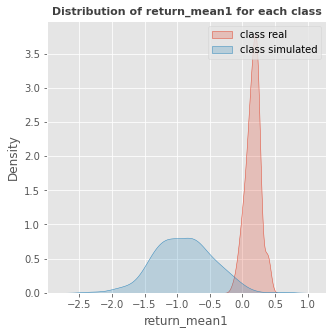

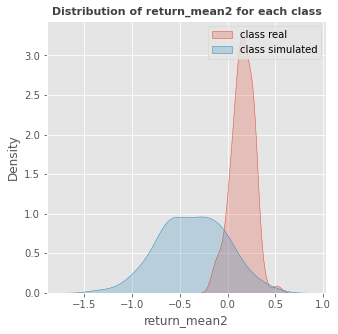

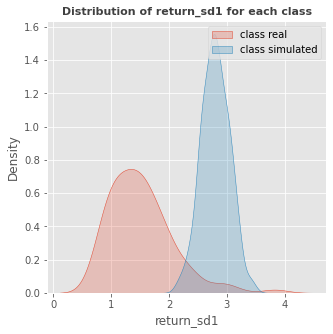

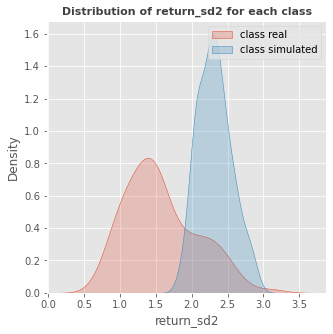

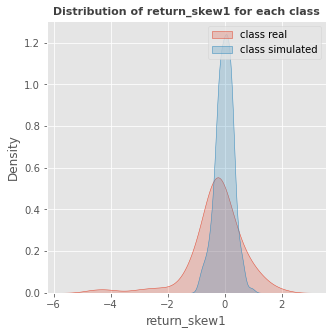

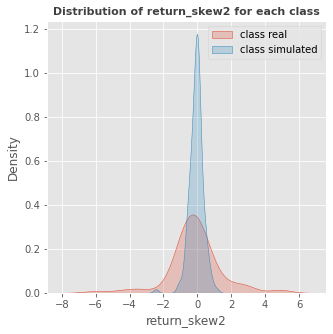

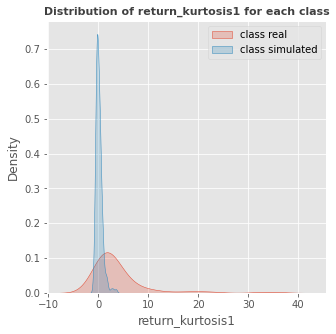

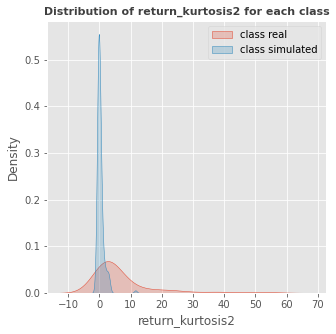

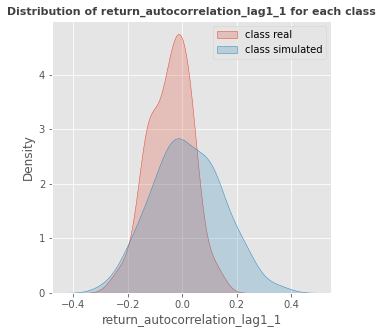

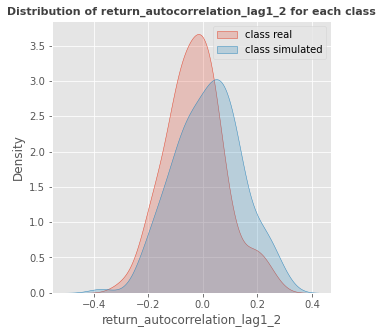

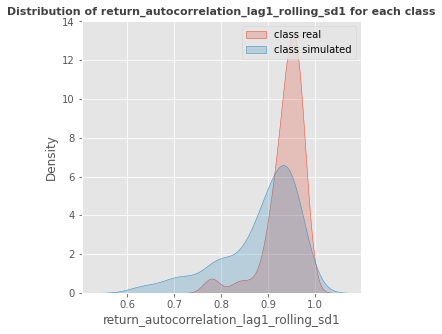

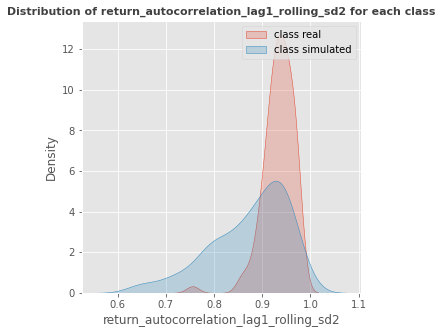

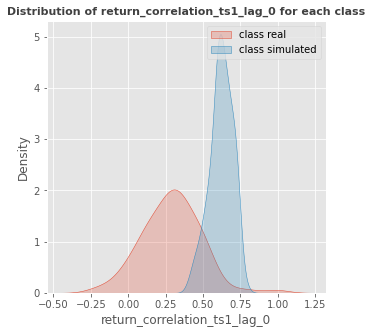

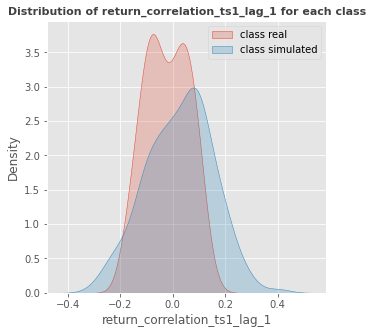

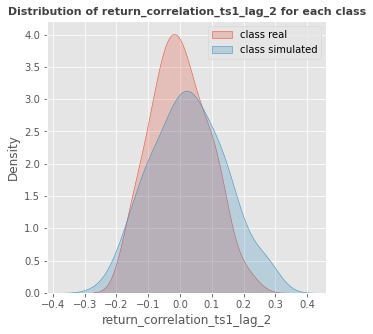

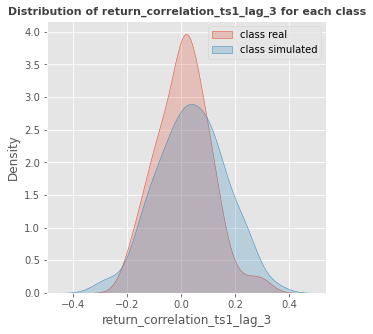

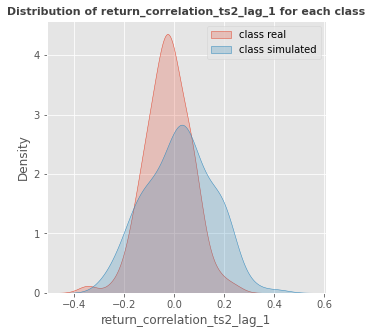

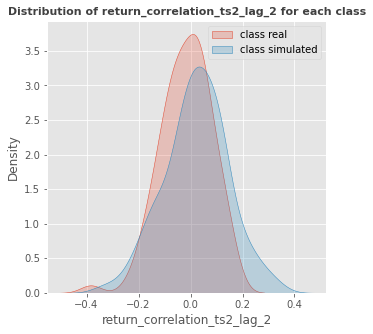

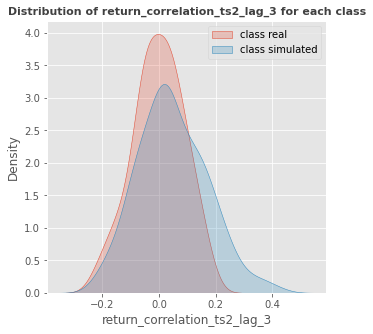

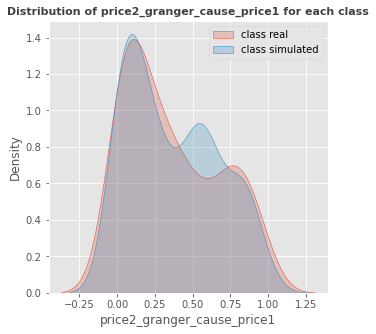

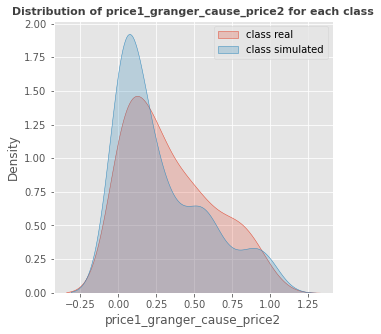

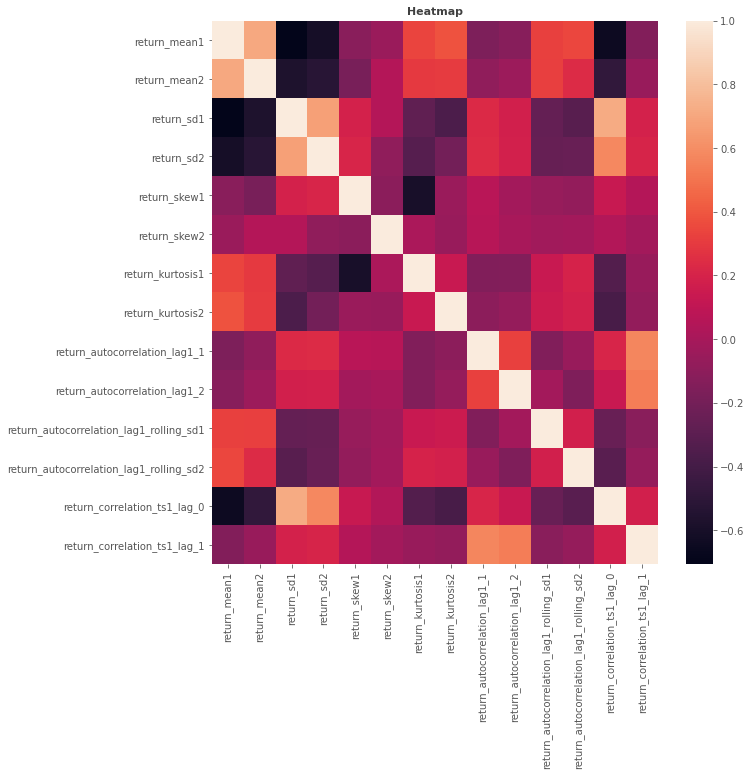

In [7]:
np.random.seed(9868)
num_iter = 10
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []

for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=random_seed, num_sim=248,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=alpha, 
        beta1=beta1, beta2=beta2, 
        delta0=delta0, 
        mu1=mu1, mu2=mu2, 
        lambda11=lambda11, lambda12=lambda12, 
        lambda21=lambda21, lambda22=lambda22,
        xinit_vec=xinit_vec, T0=T0, T=T/2, length=length/2)

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv")
    
    
    real_statistics = create_statistics(
        label="real", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_20190101_20190628/sp500_20190101_20190628_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_20190101_20190628/sp500_20190101_20190628_pair_prices.csv")
    real_statistics = real_statistics.iloc[0:124 ,:]
    
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:21]
    y = dataset.iloc[:, 21]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/ou_jump12_calibration_update_classification_EDA/AutoML_EDA")
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)
print(results)
print(accuracy_average)
print(accuracy_std)